# Lista 06 - Classificação Binária

> Yanna Torres Gonçalves
> 
> Matrícula: 587299
> 
> strado em Ciências da Computação

In [ ]:
!pip install faiss-gpu-cu12
!pip install scikit-learn fuzzywuzzy python-Levenshtein spacy nltk sentence_transformers emoji unidecode
!pip install imblearn

In [2]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 23.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
import pandas as pd
import numpy as np
import re

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
import spacy
from tqdm import tqdm
tqdm.pandas()

nltk.download('punkt')
nltk.download('stopwords')

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Parte 01: limpeza e pré-processamento dos dados

### a) Ler o dataset fakeTelegram.BR_2022.csv

In [4]:
data_url = "https://media.githubusercontent.com/media/yanna-torres/CKP9011-ciencia-de-dados/refs/heads/lista-01/data/fakeTelegram.BR_2022.csv"

df = pd.read_csv(data_url)

In [5]:
df.describe()

dataset_info_id  score_sentiment  score_misinformation    id_message
count         557586.0    444157.000000         167238.000000  5.575860e+05
mean               5.0         0.017330              0.312245  4.450617e+05
std                0.0         0.464165              0.293699  4.860211e+05
min                5.0        -1.000000              0.000003  2.000000e+00
25%                5.0        -0.177900              0.078454  2.127500e+04
50%                5.0         0.000000              0.197577  1.210935e+05
75%                5.0         0.318200              0.490351  9.726045e+05
max                5.0         0.999200              1.000000  1.516436e+06

### b) Remova os trava-zaps, as linhas repetidas e textos com menos de 5 palavras

#### Removando trava-zaps

In [6]:
def has_trava_zap(message):
    if not isinstance(message, str):
        return False  # Garante que só analisa strings

    # Regra 1: muito longo
    if len(message) > 10000:
        return True

    # Regra 2: caracteres invisíveis
    invisible = ''.join(chr(c) for c in range(0x200B, 0x200F + 1)) + '\uFEFF'
    if sum(message.count(c) for c in invisible) > 100:
        return True

    # Regra 3: emojis repetidos
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                              "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    emojis = emoji_pattern.findall(message)
    if any(len(e) > 20 for e in emojis):
        return True

    # Regra 4: baixa diversidade
    unique = set(message)
    if len(unique) < 10 and len(message) > 500:
        return True

    return False

In [7]:
df['trava_zap'] = df['text_content_anonymous'].apply(has_trava_zap)
df_clean = df[df['trava_zap'] == False]
df_clean.drop(columns=['trava_zap'], inplace=True)

/tmp/ipykernel_12735/1981750910.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['trava_zap'], inplace=True)


#### Removendo as linhas repetidas


In [8]:
df_clean = df_clean.drop_duplicates()

#### Removendo textos com menos de 5 palavras

In [9]:
df_clean = df_clean[df_clean['text_content_anonymous'].str.split().str.len() >= 5]

### c) Agrupe as linhas com postagens iguais ou semelhantes

In [10]:
df_clean.columns

Index(['date_message', 'id_member_anonymous', 'id_group_anonymous', 'media',
       'media_type', 'media_url', 'has_media', 'has_media_url',
       'text_content_anonymous', 'dataset_info_id', 'date_system',
       'score_sentiment', 'score_misinformation', 'id_message', 'message_type',
       'messenger', 'media_name', 'media_md5'],
      dtype='object')

In [11]:
import emoji
import unidecode

def normalize_text(text):
    text = str(text).lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = emoji.replace_emoji(text, " ")
    text = re.sub(r"[^\w\sÀ-ÿ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [12]:
df_clean['text_normalized'] = df_clean['text_content_anonymous'].progress_apply(normalize_text)

100%|██████████| 338045/338045 [01:01<00:00, 5533.87it/s]


In [13]:
df_clean = df_clean[df_clean['text_normalized'].notnull()]
df_clean = df_clean[df_clean['text_normalized'] != ""]
df_clean = df_clean[df_clean['text_normalized'].str.split().str.len() >= 5]

In [14]:
print("Data length:")
print(len(df_clean))

Data length:
334780


In [15]:
# Remove exact duplicates and count occurrences as "shares"
df_grouped = (
    df_clean.groupby('text_normalized', as_index=False)
      .agg({
            'date_message': 'min',
            'id_member_anonymous': 'first',
            **{col: 'first' for col in df_clean.columns if col != 'text_normalized' and col != 'date_message'}
      })
)

In [16]:
share_counts = df_clean['text_content_anonymous'].value_counts().to_dict()
df_grouped['shares'] = df_grouped['text_content_anonymous'].map(share_counts)

In [17]:
print("New Data length:")
print(len(df_grouped))

New Data length:
213677


In [18]:
df_grouped.head(5)

text_normalized         date_message  \
0                            0 31 dos votos contados  2022-10-02 20:25:52   
1                            0 48 dos votos contados  2022-10-02 20:27:10   
2  0 75 em alta o payroll de setembro 263 mil vei...  2022-10-07 12:51:35   
3  0 800 n a n a alaia azzedine paris france 011 ...  2022-10-02 02:53:42   
4          0 a 10 vai ter 2o turno o que vocês acham  2022-10-03 00:11:39   

  id_member_anonymous                id_group_anonymous  \
0                None  ca8d6cc94923d0967c15917812bb71bb   
1                None  ca8d6cc94923d0967c15917812bb71bb   
2                None  2ff252ad4422e11a6a8abfaa747abb55   
3                None  6e4192de8ce3464c5263b0a937e53529   
4                None  b11f2df64ac19aad47a50accf32052d6   

                                  media media_type          media_url  \
0  5db8d948c7921ad7ea5db4d54b1551f5.jpg  image/jpg               None   
1  b5911be07ab3e1d22ec41c9d4c3c02d2.jpg  image/jpg               None   
2                                  None       None  t.me/alexeconomia   
3                                  None       None               None   
4                                  None       None               None   

   has_media  has_media_url  \
0       True          False   
1       True          False   
2      False           True   
3      False          False   
4      False          False   

                              text_content_anonymous  dataset_info_id  \
0                      🗳📃 — 0,31% dos votos contados                5   
1                       📃 — 0,48% dos votos contados                5   
2  0,75 EM ALTA - O payroll de setembro (263 mil)...                5   
3  ,,"0 800","N/A","N/A",\n\n"Alaia, Azzedine","P...                5   
4     0 a 10   vai ter 2o turno, o que vocês acham ?                5   

                  date_system  score_sentiment  score_misinformation  \
0  2022-10-03 05:10:41.408186           0.0000                   NaN   
1  2022-10-03 05:10:43.398983           0.0000                   NaN   
2  2022-10-07 12:51:46.727848          -0.3753              0.005815   
3  2022-10-03 04:54:51.879906           0.0000              0.003349   
4  2022-10-03 05:18:48.986706           0.0000                   NaN   

   id_message message_type messenger media_name  \
0       12118       Imagem  telegram       None   
1       12120       Imagem  telegram       None   
2       49312        Texto  telegram       None   
3       19900        Texto  telegram       None   
4      154118        Texto  telegram       None   

                          media_md5  shares  
0  5db8d948c7921ad7ea5db4d54b1551f5       1  
1  b5911be07ab3e1d22ec41c9d4c3c02d2       1  
2                              None       1  
3                              None       1  
4                              None       1

In [19]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device=device)

/opt/conda/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-07-27 20:26:57.881197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753648017.898631   12735 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753648017.903077   12735 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory 

cuda


In [20]:
# Get embeddings (batch-processed on GPU)
texts = df_grouped['text_normalized'].tolist()
print("Encoding texts into embeddings...")
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, device=device)
df_grouped['embedding'] = embeddings.tolist()

Encoding texts into embeddings...


Batches:   0%|          | 0/3339 [00:00<?, ?it/s]

In [21]:
df_grouped = df_grouped.reset_index(drop=True)
embeddings_array = np.array(df_grouped['embedding'].tolist())

In [22]:
import faiss

faiss.normalize_L2(embeddings)
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings)

In [23]:
from collections import defaultdict

similarity_threshold = 0.9
k = 1000

clusters = defaultdict(list)
removed_indices = set()

for i in tqdm(range(len(df_grouped))):
    if i in removed_indices:
        continue
    vec = embeddings[i].reshape(1, -1)
    D, I = index.search(vec, k)
    for sim, j in zip(D[0][1:], I[0][1:]):
        if j == -1 or j == i or j in removed_indices:
            continue
        if sim >= similarity_threshold:
            clusters[i].append(j)
            removed_indices.add(j)

100%|██████████| 213677/213677 [2:02:07<00:00, 29.16it/s]  


In [24]:
results = []
used = set()

for base_idx, sim_indices in tqdm(clusters.items()):
    if base_idx in used:
        continue
    total_count = df_grouped.iloc[base_idx]['shares']
    used.add(base_idx)
    for sim_idx in sim_indices:
        total_count += df_grouped.iloc[sim_idx]['shares']
        used.add(sim_idx)
    row = df_grouped.iloc[base_idx].copy()
    row['shares'] = total_count
    results.append(row)

# Add remaining unmatched
remaining = df_grouped.loc[~df_grouped.index.isin(used)].copy()
final_df = pd.concat([pd.DataFrame(results), remaining], ignore_index=True)

100%|██████████| 10353/10353 [00:03<00:00, 2647.11it/s]


In [25]:
final_df.drop(columns=['embedding']).to_csv("grouped_by_similarity.csv")

### d) Colunas Auxiliares

Para facilitar a recuperação de dados em alguns casos, vamos criar colunas auxiliares.

In [26]:
import regex

def is_latin_only(text):
    # This keeps only rows that are entirely Latin script (with punctuation, digits, spaces)
    return bool(regex.fullmatch(r'[\p{Latin}\d\s\p{P}\p{S}]+', str(text)))

cleaned_df = final_df[final_df['text_normalized'].apply(is_latin_only)]

In [27]:
stop_words = set(stopwords.words('portuguese', 'english'))

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text_no_punct = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text_no_punct)
    filtered = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered)

cleaned_df['text_no_stopwords'] = cleaned_df['text_normalized'].progress_apply(clean_text)

100%|██████████| 177088/177088 [00:23<00:00, 7682.63it/s] 
/tmp/ipykernel_12735/3109209680.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['text_no_stopwords'] = cleaned_df['text_normalized'].progress_apply(clean_text)


In [28]:
cleaned_df['word_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
cleaned_df['character_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x) if pd.notnull(x) else 0)

100%|██████████| 177088/177088 [00:00<00:00, 259214.83it/s]
/tmp/ipykernel_12735/433556474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['word_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
100%|██████████| 177088/177088 [00:00<00:00, 627736.38it/s]
/tmp/ipykernel_12735/433556474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['character_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x) if pd.notn

In [29]:
def classify_misinformation(score):
    if score >= 0.66:
        return 'Misinformation'
    elif score >= 0.33:
        return 'Neutral'
    else:
        return 'Non-misinformation'

cleaned_df['misinformation_category'] = cleaned_df['score_misinformation'].progress_apply(classify_misinformation)

100%|██████████| 177088/177088 [00:00<00:00, 965480.95it/s]
/tmp/ipykernel_12735/224180667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['misinformation_category'] = cleaned_df['score_misinformation'].progress_apply(classify_misinformation)


In [30]:
cleaned_df['sentiment_category'] = cleaned_df['score_sentiment'].progress_apply(lambda x: "Positive" if x >= 0.05 else ("Negative" if x <= -0.05 else "Neutral"))

100%|██████████| 177088/177088 [00:00<00:00, 990462.77it/s]
/tmp/ipykernel_12735/984165960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['sentiment_category'] = cleaned_df['score_sentiment'].progress_apply(lambda x: "Positive" if x >= 0.05 else ("Negative" if x <= -0.05 else "Neutral"))


In [31]:
cleaned_df.drop(columns=['embedding']).to_csv("grouped_cleaned.csv")

#### Gerar os diferentes embeddings

##### TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=300)
X_tfidf = tfidf.fit_transform(cleaned_df['text_normalized']).toarray()

cleaned_df['tfidf_embedding'] = list(X_tfidf)

/tmp/ipykernel_12735/1211592424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['tfidf_embedding'] = list(X_tfidf)


##### BoW

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=300)
X_bow = bow.fit_transform(cleaned_df['text_normalized']).toarray()

cleaned_df['bow_embedding'] = list(X_bow)

/tmp/ipykernel_12735/2677070252.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['bow_embedding'] = list(X_bow)


##### Word2Vec

In [39]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

tokenized_texts = cleaned_df['text_normalized'].progress_apply(word_tokenize)
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

100%|██████████| 177088/177088 [00:22<00:00, 7817.05it/s] 


In [40]:
import numpy as np

def get_avg_word2vec(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model.wv]
    if valid_tokens:
        return np.mean(model.wv[valid_tokens], axis=0)
    else:
        return np.zeros(vector_size)

cleaned_df['word2vec_embedding'] = tokenized_texts.progress_apply(lambda tokens: get_avg_word2vec(tokens, w2v_model, 100))

100%|██████████| 177088/177088 [00:13<00:00, 13248.96it/s]
/tmp/ipykernel_12735/1752296396.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['word2vec_embedding'] = tokenized_texts.progress_apply(lambda tokens: get_avg_word2vec(tokens, w2v_model, 100))


## Parte 02: Modelo Preditivo (Classificador Binário)

Utilizando os dados referente a postagens no Telegram, crie um modelo preditivo (classificador binário) para classificar uma mensagem em duas classes possíveis: “viral” (classe positiva) ou “não viral” (classe negativa).

Para rotular as mensagens únicas (agrupadas) nas classes, “viral” e “não viral”, utilize a seguinte estratégia: Calcule um limiar (threshold).

Por exemplo, mediana do número de compartilhamentos mais dois desvios padrões. As mensagens com quantidade de compartilhamentos maiores ou iguais ao limiar definido devem ser rotuladas como “virais”.

As demais mensagens devem ser rotuladas como “não virais”.

In [49]:
cleaned_df[["shares", "text_content_anonymous"]].sort_values(by='shares', ascending=False).head(50)

shares                             text_content_anonymous
5088     17423  Grupo a diretoria bloqueado:\n\nEstá comunidad...
2627      1607  Comentarios de Anderson Martinho de 29 años. B...
46        1425  1, pressione o botão abaixo dentro de 3 Minuto...
9308      1282  Welcome, 00\n\n🔸 [USER] — professional tool fo...
7095      1256  Olá 1...2...3...5...8...13...21...34...55...89...
7165      1090  🚨Olá SEJA bem vindo(a) 1- ao grupo Especulando...
7098       724  Olá 182 (-) \n\nSeja bem vindo(a) ao grupo DIR...
4573       698  Feedback de Afonso Rico 27 ​​anos.  Brasil, Li...
9333       627  Welcome, A MARCOLINO Maranata\n\n🔸 [USER] — pr...
2160       534  Bom ter você por aqui, 1. 🇧🇷\n\nConsulte as me...
9315       527  Welcome, 27061 Alicia\n\n🔸 [USER] — profession...
4570       517  Feedback de Adriana fenado 38 anos. Brazil, SO...
2638       485  Comentários de Danail Fábio, 56 anos. Brasil, ...
7097       448  Olá 18132 (-) \n\nSeja bem vindo(a) ao grupo D...
1821       364  ⚠️ BEM-VINDO! ⚠️\n\nEste Grupo é Para Juntar e...
31342      358  Bem vindo(a) ao grupo Ipirá Notícias. \n\nComp...
9325       339  Welcome, 81235 Ana Silva\n\n🔸 [USER] — profess...
9314       332  Welcome, 20372 Florencio Barros\n\n🔸 [USER] — ...
8273       330             Screenshot (1 de nov de 2022 01:53:14)
70         323  12899, pressione o botão abaixo dentro de 5 Mi...
8358       320  Seja bem vindo ao grupo 10krnzin 📚 Este grupo ...
181        319  48733, pressione o botão abaixo dentro de 2 Mi...
334        295  *A ESQUERDA ESTA AGINDO NOS GRUPOS DE WHATSAPP...
9338       285  Welcome, Aakanksha Gupta\n\n🔸 [USER] — profess...
9339       279  Welcome, Aaldea BertoMeu\n\n🔸 [USER] — profess...
9326       249  Welcome, 97039 Paulo Moreira\n\n🔸 [USER] — pro...
8123       208  Regras do Grupo \n\n1° Regra do grupo é respei...
9372       207  Welcome, Adilio Santos\n\n🔸 [USER] — professio...
6131       204  Meu povo, ânimo! A vida segue!\n\n\n\nPara que...
4329       201  Eu disse Há infiltrados AQUI e é VERDADE     ....
7343       200  #panorama [USER]\n\n▪️ 01/11/2022 - 00:00 \nEs...
172264     195                     Vídeo de AVANY FERREIRA MULLER
9329       191  Welcome, A Costa\n\n🔸 [USER] — professional to...
172388     189                   Vídeo de Maria Teresa D  Valente
7344       185  #panorama [USER] \n #commodities \n▪️ 01/11/20...
74850      184                    Foto de Maria Teresa D  Valente
958        183  *AMANHÃ DIA TODO\n02/11/2022\n\nVAMOS LEVANTAR...
2642       178  Comentários de Maria \n35 anos. Brasil, Rio Gr...
9419       174  Welcome, Alejandra Vasquez\n\n🔸 [USER] — profe...
9312       174  Welcome, 18 Luis\n\n🔸 [USER] — professional to...
172425     171                           Vídeo de R A S G A N D O
19         163  [1/11 10:00] 🌻🌻🌻: Bom dia!! Sou advogada e vou...
9311       158  Welcome, 152 Carlos Augusto Kohl\n\n🔸 [USER] —...
102        151  [19/10 15:45] Frank: Já que lula colocou um mi...
684        149  Adilson Joao, pressione o botão abaixo dentro ...
109        147  [2/11 08:46] Madson Psi: *VAMOS SEGUIR O INSTA...
2657       146  COMIGO COMIGO RECEBEM MAIS TARDE✅, SEU LUCRO E...
2630       145  Comentarios de Paulo Barroso 30 años. Brasil, ...
9336       144  Welcome, AA%#es\n\n🔸 [USER] — professional too...
7345       144  #panorama [USER] \n #criptomoedas \n▪️ 01/11/2...

In [54]:
cleaned_df[["shares", "text_content_anonymous"]][cleaned_df['shares'] <= 100].sort_values(by='shares', ascending=False).head(50)

shares                             text_content_anonymous
4216       100  Estou muito feliz com esta plataforma Fiz um i...
148         99  🇧🇷 2º Turno - Compartilhe 🇧🇷\n\nLista atualiza...
2669        97  .COMO COMEÇAR\n\n  1. Prepare seus fundos.\n\n...
8359        97  Seja bem vindo ao grupo 3rr0 📚 Este grupo é li...
2474        96  *CDBr INFORMA:*\n\n*VAMOS MOSTRAR AOS PETRALHA...
6213        95  🌒 MODO NOTURNO INICIADO\n\n❌ A partir deste mo...
9381        94  Welcome, Adriana Martins\n\n🔸 [USER] — profess...
7077        93  Ola! Tudo bem? A nossa enquete eleitoral esta ...
438         91  https://youtu.be/u-ZGL90PfeIJUNTE-SE A NÓS TAM...
9402        91  Welcome, Ajay Kumar\n\n🔸 [USER] — professional...
9351        91  Welcome, Abedalrhman Sarsour\n\n🔸 [USER] — pro...
9422        91  Welcome, Alex lefevre\n\n🔸 [USER] — profession...
18354       90  ⚡️🇧🇷 Actus Liberandi - Ordem De Cristo 🇧🇷\n\n✨...
5487        90  INVISTA CONOSCO E RECEBA✅\n   A SEU LUCRO ESTÁ...
3189        89  Cuidado pessoal tão postando em todos os grupo...
2020        84  Bolsonaro está perto de fazer 3 milhões e meio...
8           83                                           [04/1...
388         83  A hora é agora .. Nas ruas e Já mandei por e-m...
3828        83  ENTRA EM MIM\n\n   OLÁ\n\n   OLÁ\n\n   Com lic...
9332        82  Welcome, A. J.\n\n🔸 [USER] — professional tool...
2724        81  🇧🇷🔆🇧🇷🔆🇧🇷🔆🇧🇷🔆 🇧🇷💥🇧🇷💥🇧🇷💥🇧🇷 COMPARTILHE.............
5103        80  grupo [USER] venha edificar sua fé para se tor...
2636        80  Comentários de Antônio Luiz \n41 anos. Brasil,...
9405        76  Welcome, ALAIDES GIMENES\n\n🔸 [USER] — profess...
84908       76  Irmãos de DIREITA, COMPARTILHEM o MÁXIMO, VAMO...
657         76  Acompanhando  a matemática q percebo agora. An...
1602        76  Atenção Pessoal orientação do nosso amigo da P...
2797        75  Congrats & Thank you very much for your wonder...
9257        75                        Vídeo de Ana Mello Vianna 💞
4053        74  ESTA FALTANDO BRASILEIROS QUE VOTOU NO BOLSONA...
3865        74  ENVIE O SEU PEDIDO AGORA, ESTAMOS ABERTOS\n\nc...
250         74  _Só repassando _\nATENÇÃO🇧🇷\n\nUm jornalista d...
172276      73                     Vídeo de Cecília Lima De Moura
9069        73  [USER] [1001117563] está floodando. \nAção: Ad...
9391        73  Welcome, Afonso Pereira\n\n🔸 [USER] — professi...
6128        72  meu grande investidor está testemunhando como ...
4629        72  Feedback de Marcos  23 anos. Brasil, Diadema.\...
20          72  [1/11 13:37] +55 [PHONE]: Oficiais do exército...
7116        71  Olá Alexandra (-) \n\nSeja bem vindo(a) ao gru...
4596        71  Feedback de David Henriques 27 anos. Brazil, F...
533         70  A suspeita é que nas vésperas, uns 2 dias ante...
9252        69                                   Vídeo de A Í D A
96          69  16200 [656109889] está floodando. \nAção: Adve...
9401        68  Welcome, Airon Oliveiraa\n\n🔸 [USER] — profess...
4592        68  Feedback de Cleiton \n41 anos. Brasil, Alagoas...
7100        68  Olá a todos, Acabei de receber o pagamento e e...
4956        68  Gente precisam entender isso PATRIOTA LEIAM O ...
9330        67  Welcome, A.D.C\n\n🔸 [USER] — professional tool...
6284        67  Muitas vidas se transformaram aqui, muitas vid...
194         66  🥀 [5334705226] para participar neste grupo, po...

In [55]:
training_final_df = cleaned_df[cleaned_df['shares'] <= 100]

In [58]:
len(training_final_df)

177012

### Features

In [59]:
limiar = training_final_df["shares"].median() + 2 * training_final_df["shares"].std()
training_final_df["is_viral"] = (training_final_df["shares"] >= limiar).astype(int)  # 1 = viral, 0 = não viral

/tmp/ipykernel_12735/477685284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df["is_viral"] = (training_final_df["shares"] >= limiar).astype(int)  # 1 = viral, 0 = não viral


In [61]:
training_final_df[["shares", "text_content_anonymous", "is_viral"]].sort_values(by='shares', ascending=False).head()

shares                             text_content_anonymous  is_viral
4216     100  Estou muito feliz com esta plataforma Fiz um i...         1
148       99  🇧🇷 2º Turno - Compartilhe 🇧🇷\n\nLista atualiza...         1
2669      97  .COMO COMEÇAR\n\n  1. Prepare seus fundos.\n\n...         1
8359      97  Seja bem vindo ao grupo 3rr0 📚 Este grupo é li...         1
2474      96  *CDBr INFORMA:*\n\n*VAMOS MOSTRAR AOS PETRALHA...         1

In [62]:
training_final_df["date_message"] = pd.to_datetime(training_final_df["date_message"])
training_final_df["hour"] = training_final_df["date_message"].dt.hour
training_final_df["day_of_week"] = training_final_df["date_message"].dt.dayofweek

/tmp/ipykernel_12735/4185041234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df["date_message"] = pd.to_datetime(training_final_df["date_message"])
/tmp/ipykernel_12735/4185041234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df["hour"] = training_final_df["date_message"].dt.hour
/tmp/ipykernel_12735/4185041234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [63]:
from sklearn.preprocessing import LabelEncoder

for col in ["media_type", "sentiment_category", "misinformation_category"]:
    training_final_df[col] = training_final_df[col].fillna("unknown")
    training_final_df[col] = LabelEncoder().fit_transform(training_final_df[col])

/tmp/ipykernel_12735/1949680538.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df[col] = training_final_df[col].fillna("unknown")
/tmp/ipykernel_12735/1949680538.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df[col] = LabelEncoder().fit_transform(training_final_df[col])
/tmp/ipykernel_12735/1949680538.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [64]:
feature_cols = [
    "word_count", "character_count", "score_sentiment", "score_misinformation",
    "has_media", "sentiment_category", "misinformation_category",
    "hour", "day_of_week"
]

In [65]:
training_final_null_df = training_final_df.dropna(subset=feature_cols)

In [66]:
training_final_null_df.isnull().sum()

text_normalized                0
date_message                   0
id_member_anonymous        47645
id_group_anonymous             0
media                      62237
media_type                     0
media_url                  66633
has_media                      0
has_media_url                  0
text_content_anonymous         0
dataset_info_id                0
date_system                    0
score_sentiment                0
score_misinformation           0
id_message                     0
message_type                   0
messenger                      0
media_name                 82135
media_md5                  62237
shares                         0
embedding                      0
text_no_stopwords              0
word_count                     0
character_count                0
misinformation_category        0
sentiment_category             0
tfidf_embedding                0
bow_embedding                  0
word2vec_embedding             0
is_viral                       0
hour      

In [69]:
embedding_matrix_tfidf = np.vstack(training_final_null_df["tfidf_embedding"])
embedding_matrix_bow = np.vstack(training_final_null_df["bow_embedding"])
embedding_matrix_word2vec = np.vstack(training_final_null_df["word2vec_embedding"])

In [70]:
X_base = training_final_null_df[feature_cols].values
X_tfidf = np.hstack([X_base, embedding_matrix_tfidf])
X_bow = np.hstack([X_base, embedding_matrix_bow])
X_word2vec = np.hstack([X_base, embedding_matrix_word2vec])
y = training_final_null_df["is_viral"]

#### Visualizações

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

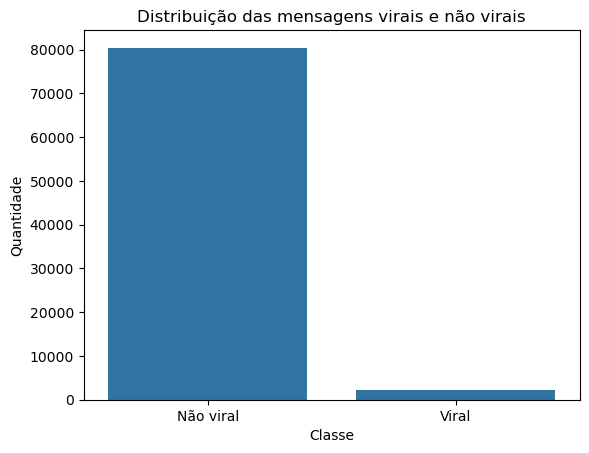

In [72]:
sns.countplot(x="is_viral", data=training_final_null_df)
plt.title("Distribuição das mensagens virais e não virais")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.xticks([0, 1], ["Não viral", "Viral"])
plt.show()

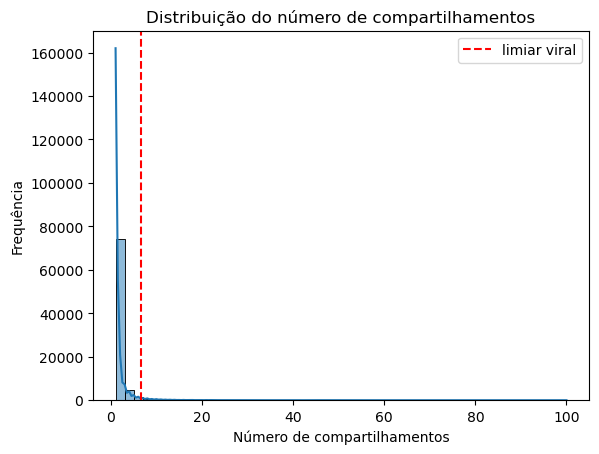

In [73]:
sns.histplot(training_final_null_df["shares"], bins=50, kde=True)
plt.axvline(limiar, color="red", linestyle="--", label="limiar viral")
plt.title("Distribuição do número de compartilhamentos")
plt.xlabel("Número de compartilhamentos")
plt.ylabel("Frequência")
plt.legend()
plt.show()

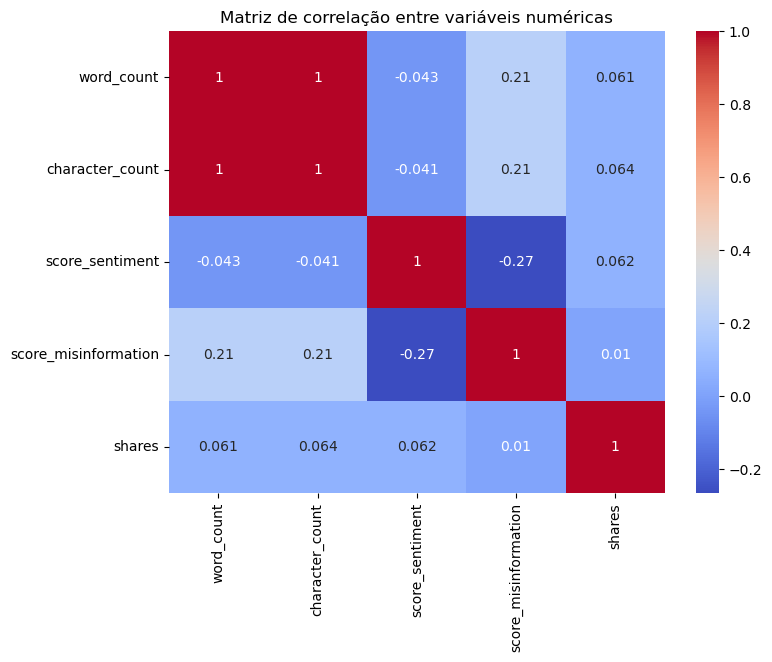

In [74]:
numeric_cols = [
    "word_count", "character_count", "score_sentiment", "score_misinformation", "shares"
]

corr = training_final_null_df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlação entre variáveis numéricas")
plt.show()

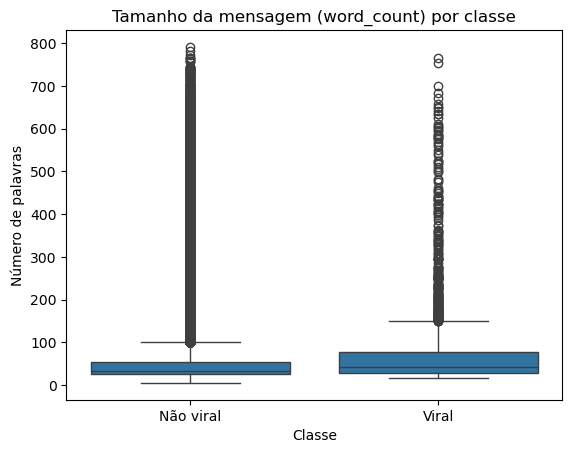

In [75]:
sns.boxplot(x="is_viral", y="word_count", data=training_final_null_df)
plt.title("Tamanho da mensagem (word_count) por classe")
plt.xlabel("Classe")
plt.ylabel("Número de palavras")
plt.xticks([0, 1], ["Não viral", "Viral"])
plt.show()

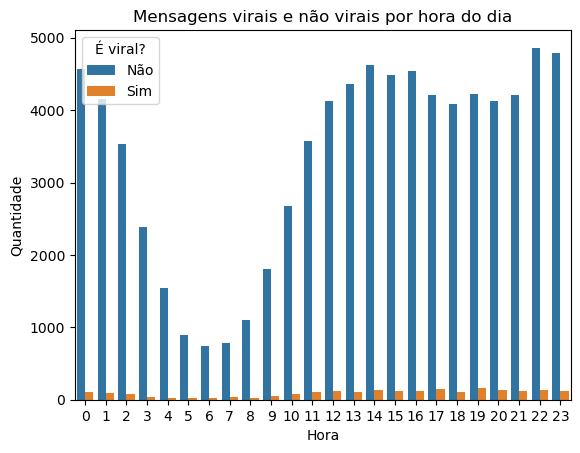

In [76]:
sns.countplot(x="hour", hue="is_viral", data=training_final_null_df)
plt.title("Mensagens virais e não virais por hora do dia")
plt.xlabel("Hora")
plt.ylabel("Quantidade")
plt.legend(title="É viral?", labels=["Não", "Sim"])
plt.show()

### Treinamento

In [77]:
from sklearn.model_selection import train_test_split

X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    X_tfidf, y, stratify=y, test_size=0.2, random_state=42
)

X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(
    X_bow, y, stratify=y, test_size=0.2, random_state=42
)

X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test = train_test_split(
    X_word2vec, y, stratify=y, test_size=0.2, random_state=42
)

#### Regressão Logística

In [78]:
!pip install imblearn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [79]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report, roc_curve, auc, confusion_matrix
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
def run_logistic_experiment(
    X_train, X_test, y_train, y_test,
    balance_strategy=None,
    normalize=None,
    penalty="l2",
    solver="liblinear",
    class_weight=None,
    max_iter=1000,
    l1_ratio=None,
    verbose=True
):
    print(f"\n🔧 Config: balance={balance_strategy}, normalize={normalize}, penalty={penalty}, weight={class_weight}")

    # Normalize
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Balance
    if balance_strategy == "smote":
        sampler = SMOTE(random_state=42)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=42)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=42)
    else:
        sampler = None

    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    # Train model
    model = LogisticRegression(
        solver=solver,
        penalty=penalty,
        class_weight=class_weight,
        max_iter=max_iter,
        l1_ratio=l1_ratio,   # ignored if not elasticnet
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    # Print report
    print("\n📊 Classification Report")
    report_dict = classification_report(y_test, y_pred, target_names=["Não viral", "Viral"], output_dict=True)
    print(classification_report(y_test, y_pred, target_names=["Não viral", "Viral"]))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Não viral", "Viral"], yticklabels=["Não viral", "Viral"])
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Plot curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Falso Positivo (FPR)")
    plt.ylabel("Verdadeiro Positivo (TPR)")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot métricas por classe
    df_plot = pd.DataFrame(report_dict).transpose().loc[["Não viral", "Viral"], ["precision", "recall", "f1-score"]]
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Greens")
    plt.title("Desempenho por Classe")
    plt.show()

    return report_dict

In [88]:
experiment_configs = [
    # Baseline
    {"normalize": None, "balance_strategy": None, "penalty": "l1", "class_weight": None},

    # Regularization
    {"normalize": "zscore", "balance_strategy": None, "penalty": "l1", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "penalty": "l2", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "penalty": "elasticnet", "class_weight": None},

    # Normalization variants
    {"normalize": "minmax", "balance_strategy": None, "penalty": "l2", "class_weight": None},

    # Class weighting
    {"normalize": "zscore", "balance_strategy": None, "penalty": "l2", "class_weight": "balanced"},

    # With balancing
    {"normalize": "zscore", "balance_strategy": "smote", "penalty": "l2", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "ros", "penalty": "l2", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "rus", "penalty": "l2", "class_weight": None},
]

##### TF-IDF


📌 Running Experiment 1/9
{'normalize': None, 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=None, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.00      0.00      0.00       448

    accuracy                           0.97     16533
   macro avg       0.49      0.50      0.49     16533
weighted avg       0.95      0.97      0.96     16533



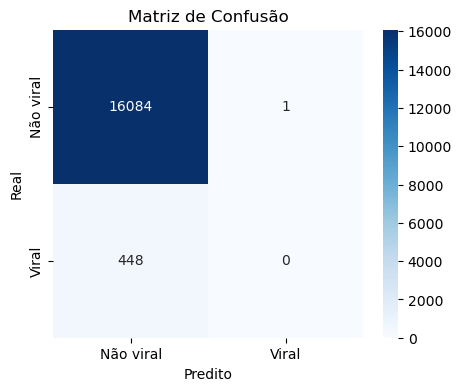

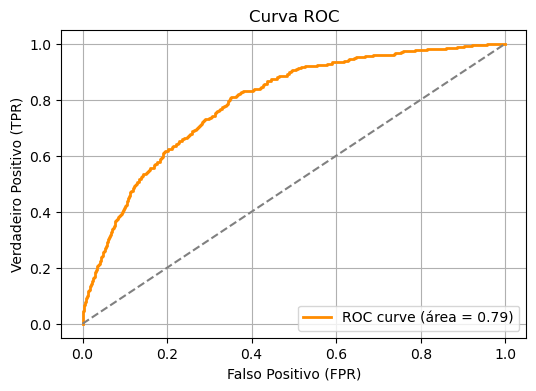

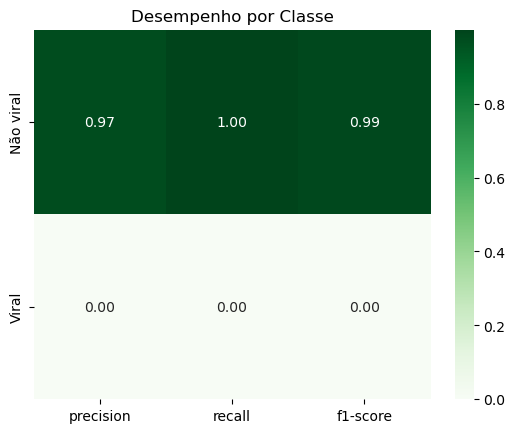


📌 Running Experiment 2/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.14      0.00      0.00       448

    accuracy                           0.97     16533
   macro avg       0.56      0.50      0.50     16533
weighted avg       0.95      0.97      0.96     16533



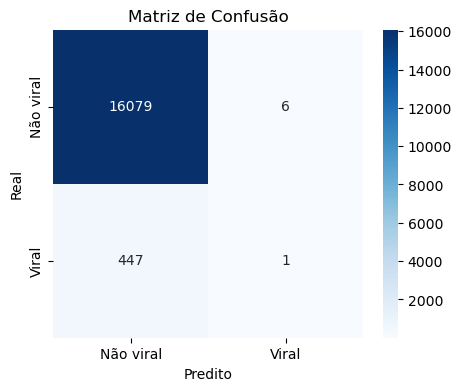

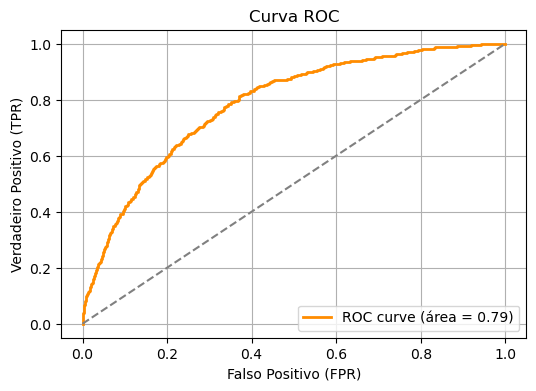

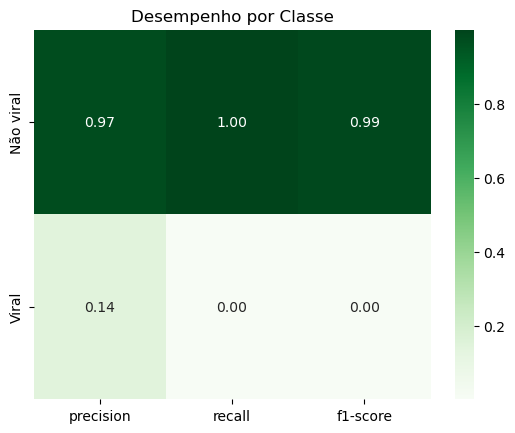


📌 Running Experiment 3/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.25      0.00      0.01       448

    accuracy                           0.97     16533
   macro avg       0.61      0.50      0.50     16533
weighted avg       0.95      0.97      0.96     16533



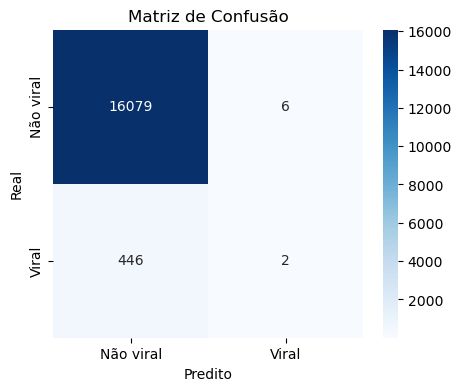

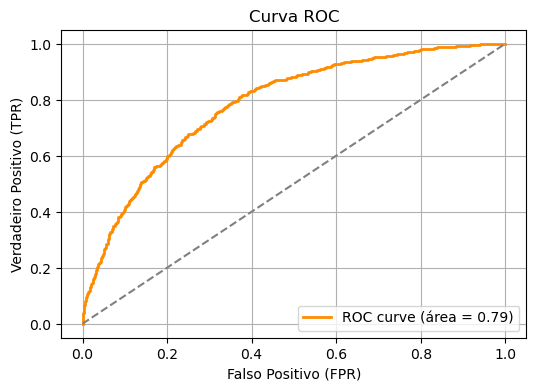

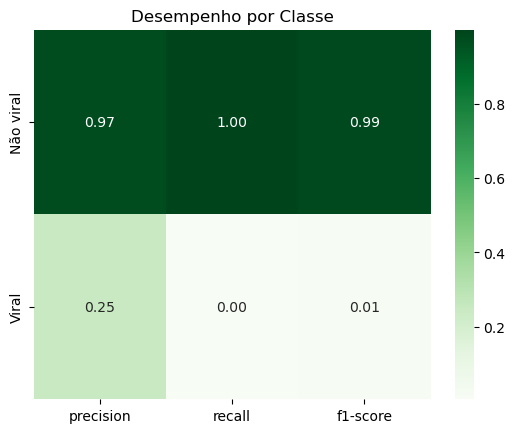


📌 Running Experiment 4/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'elasticnet', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=elasticnet, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.25      0.00      0.01       448

    accuracy                           0.97     16533
   macro avg       0.61      0.50      0.50     16533
weighted avg       0.95      0.97      0.96     16533



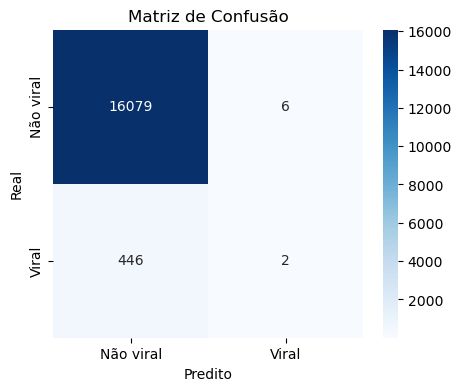

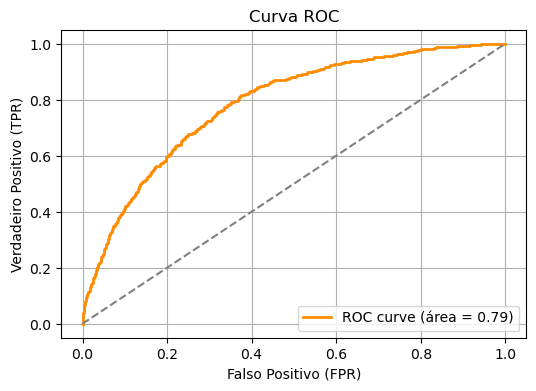

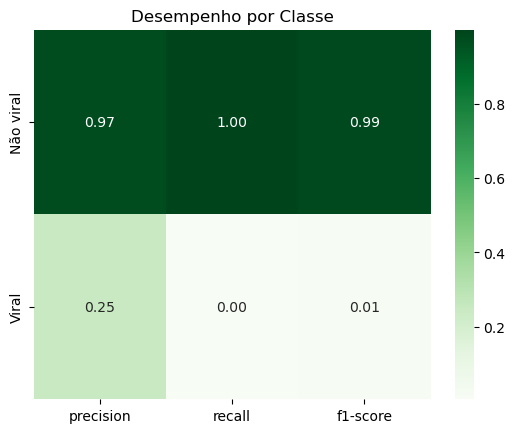


📌 Running Experiment 5/9
{'normalize': 'minmax', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=minmax, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.00      0.00      0.00       448

    accuracy                           0.97     16533
   macro avg       0.49      0.50      0.49     16533
weighted avg       0.95      0.97      0.96     16533



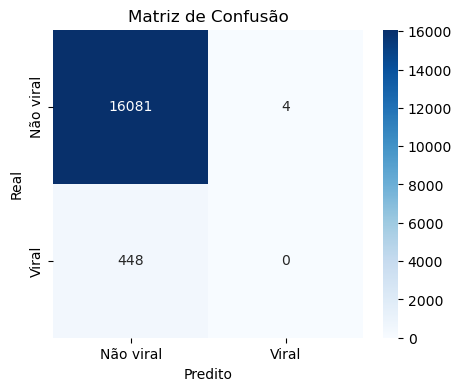

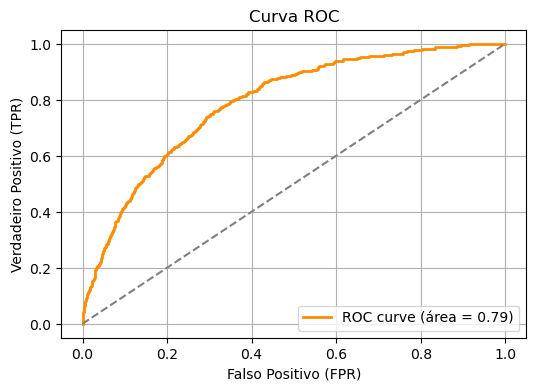

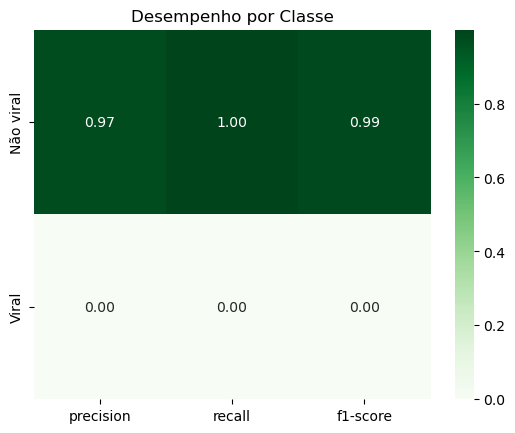


📌 Running Experiment 6/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': 'balanced'}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=balanced

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.74      0.85     16085
       Viral       0.07      0.68      0.12       448

    accuracy                           0.74     16533
   macro avg       0.53      0.71      0.49     16533
weighted avg       0.96      0.74      0.83     16533



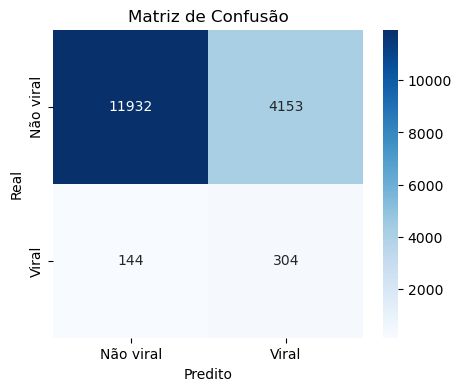

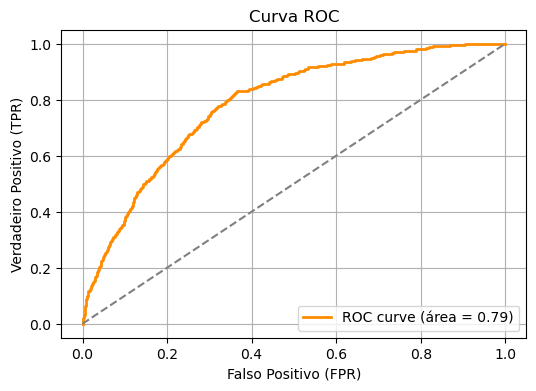

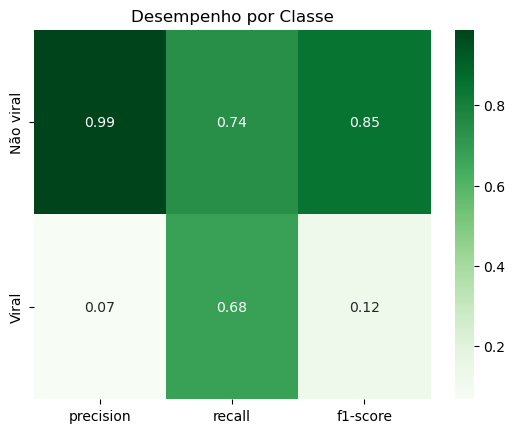


📌 Running Experiment 7/9
{'normalize': 'zscore', 'balance_strategy': 'smote', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=smote, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.81      0.89     16085
       Viral       0.07      0.52      0.12       448

    accuracy                           0.80     16533
   macro avg       0.53      0.66      0.50     16533
weighted avg       0.96      0.80      0.87     16533



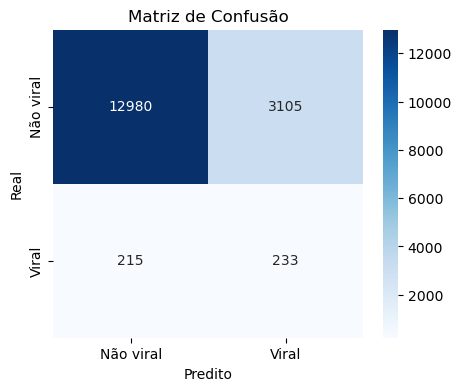

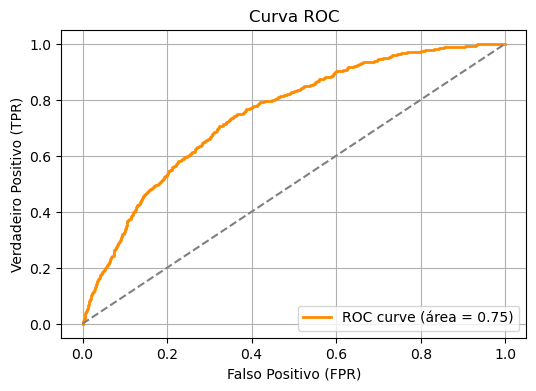

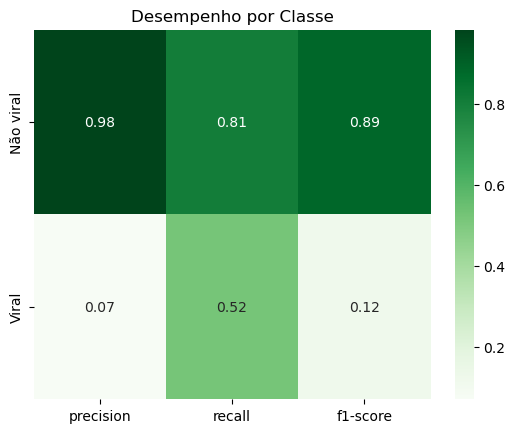


📌 Running Experiment 8/9
{'normalize': 'zscore', 'balance_strategy': 'ros', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=ros, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.74      0.85     16085
       Viral       0.07      0.67      0.12       448

    accuracy                           0.74     16533
   macro avg       0.53      0.71      0.49     16533
weighted avg       0.96      0.74      0.83     16533



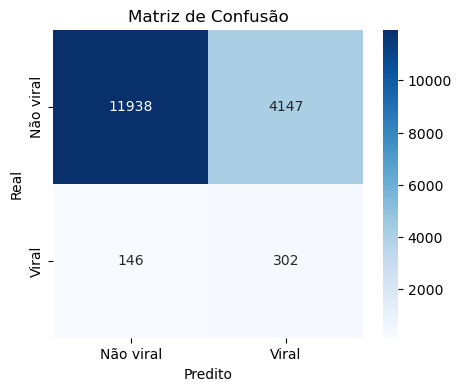

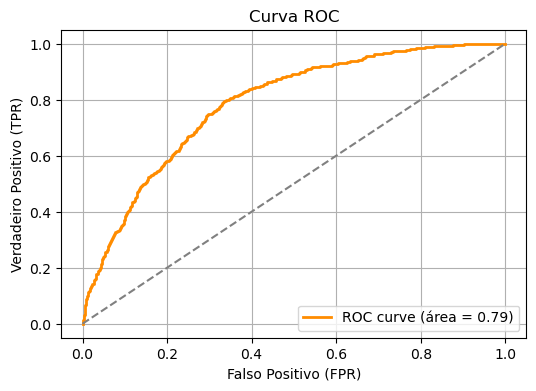

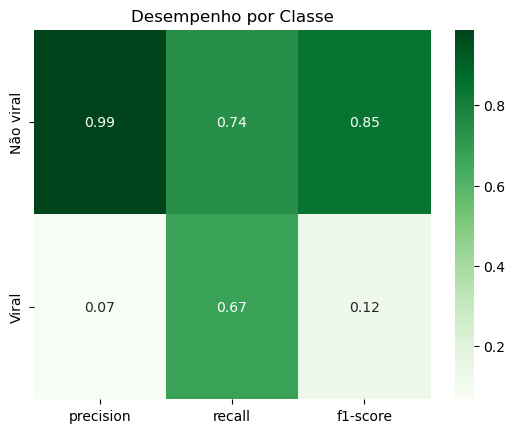


📌 Running Experiment 9/9
{'normalize': 'zscore', 'balance_strategy': 'rus', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=rus, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.70      0.82     16085
       Viral       0.06      0.71      0.11       448

    accuracy                           0.70     16533
   macro avg       0.53      0.71      0.47     16533
weighted avg       0.96      0.70      0.80     16533



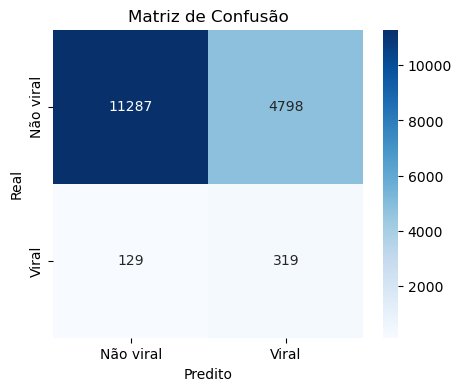

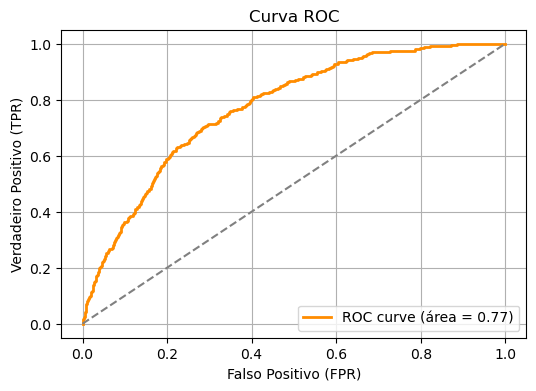

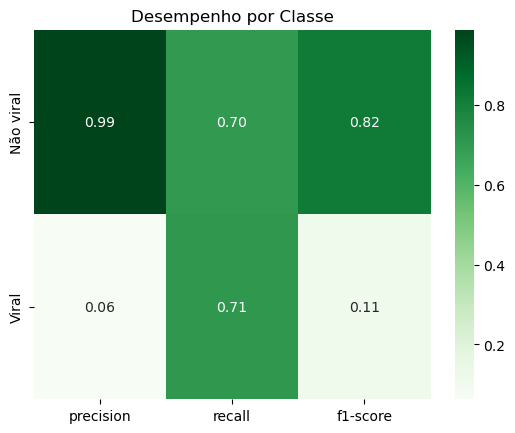

In [95]:
results_regression_tfidf = []

solver_for_penalty = {
    "l1": "liblinear",
    "l2": "liblinear",
    "elasticnet": "saga"
}

for i, config in enumerate(experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(experiment_configs)}")
    print(config)

    # Dynamically assign solver and l1_ratio
    penalty = config["penalty"]
    solver = solver_for_penalty[penalty]
    l1_ratio = 0.5 if penalty == "elasticnet" else None

    report_dict = run_logistic_experiment(
        X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        penalty=penalty,
        solver=solver,
        class_weight=config["class_weight"],
        l1_ratio=l1_ratio,
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results_regression.append({
        **config,
        "solver": solver,
        "l1_ratio": l1_ratio,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### BOW


📌 Running Experiment 1/9
{'normalize': None, 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=None, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.24      0.01      0.03       448

    accuracy                           0.97     16533
   macro avg       0.61      0.51      0.51     16533
weighted avg       0.95      0.97      0.96     16533



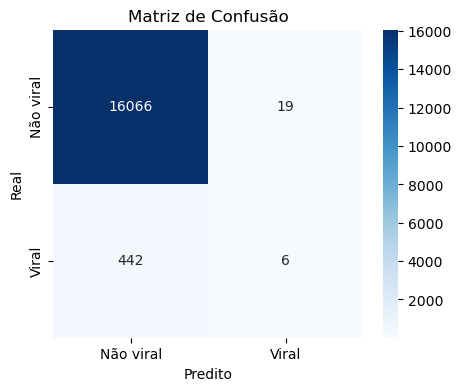

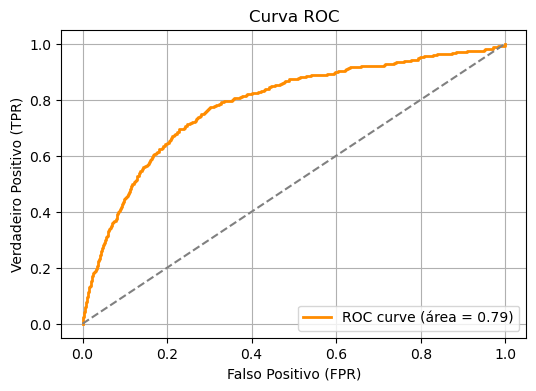

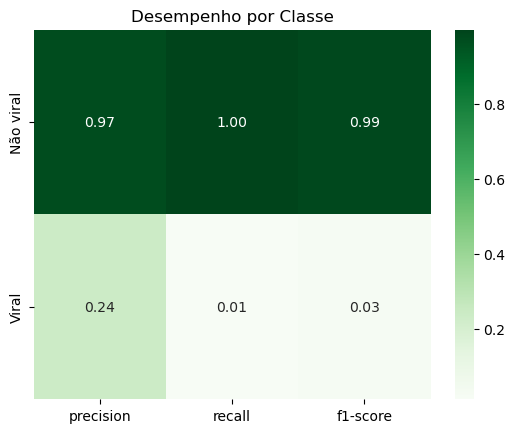


📌 Running Experiment 2/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.21      0.01      0.03       448

    accuracy                           0.97     16533
   macro avg       0.59      0.51      0.51     16533
weighted avg       0.95      0.97      0.96     16533



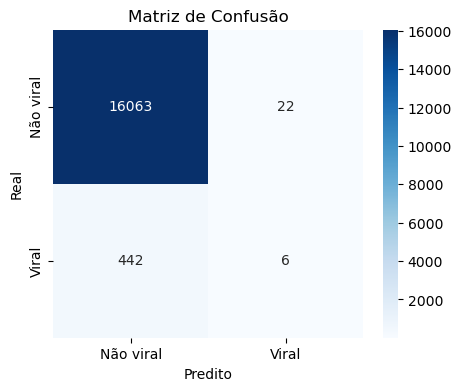

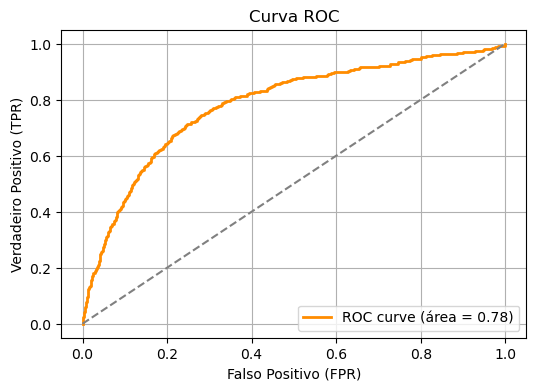

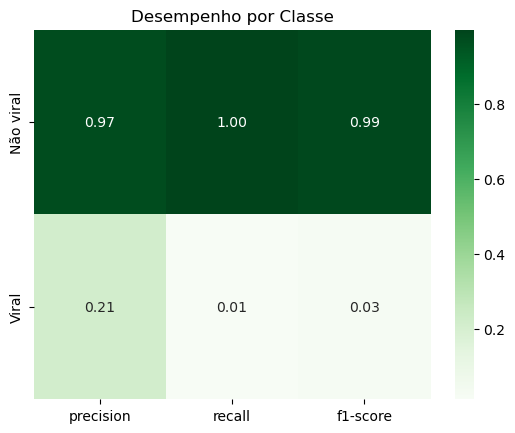


📌 Running Experiment 3/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.21      0.01      0.03       448

    accuracy                           0.97     16533
   macro avg       0.59      0.51      0.51     16533
weighted avg       0.95      0.97      0.96     16533



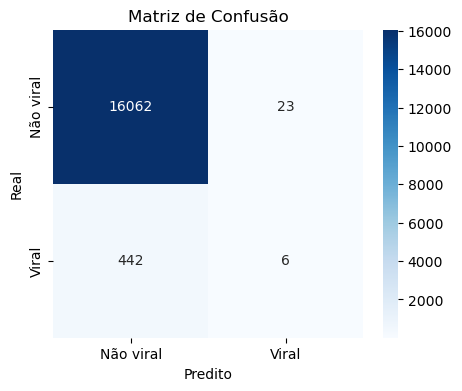

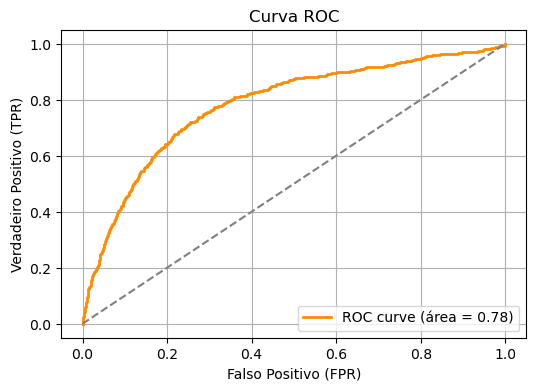

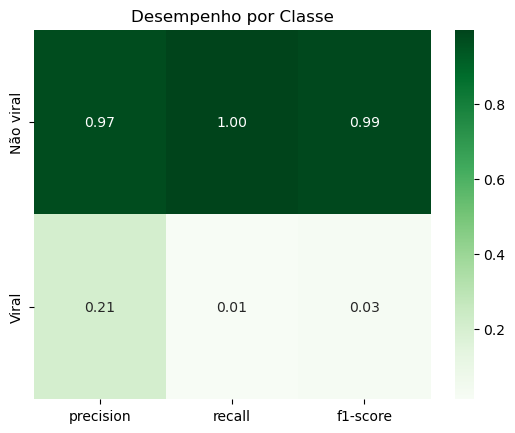


📌 Running Experiment 4/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'elasticnet', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=elasticnet, weight=None


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.20      0.01      0.03       448

    accuracy                           0.97     16533
   macro avg       0.59      0.51      0.51     16533
weighted avg       0.95      0.97      0.96     16533



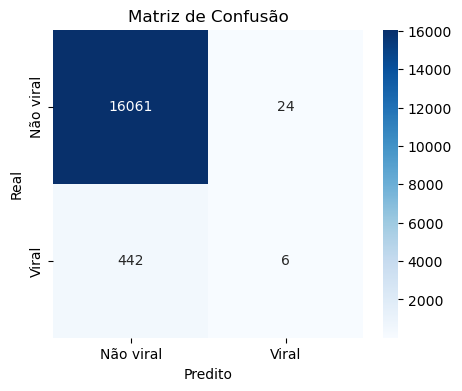

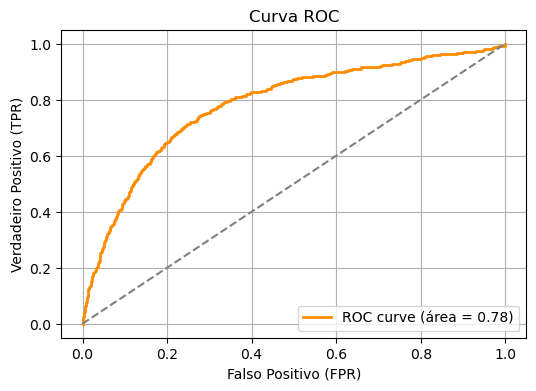

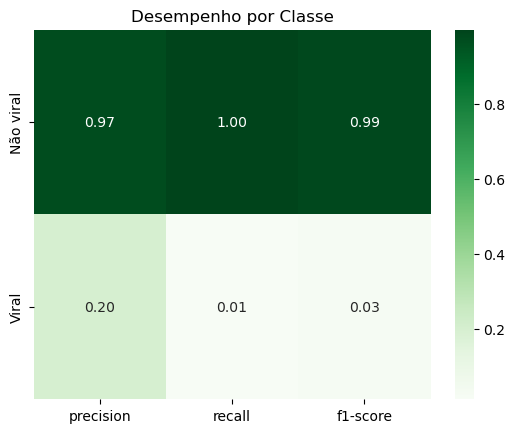


📌 Running Experiment 5/9
{'normalize': 'minmax', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=minmax, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.18      0.00      0.01       448

    accuracy                           0.97     16533
   macro avg       0.58      0.50      0.50     16533
weighted avg       0.95      0.97      0.96     16533



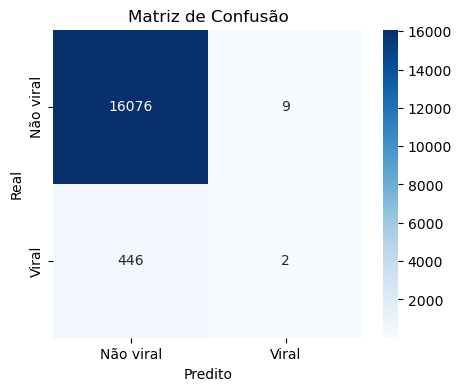

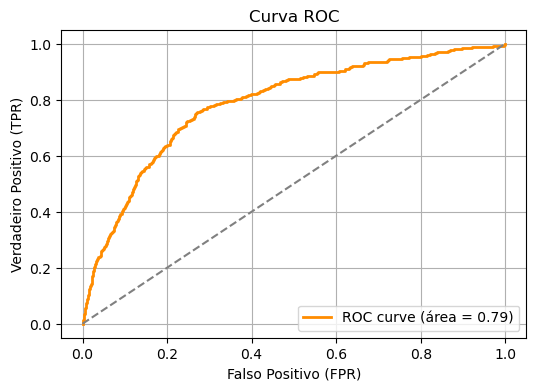

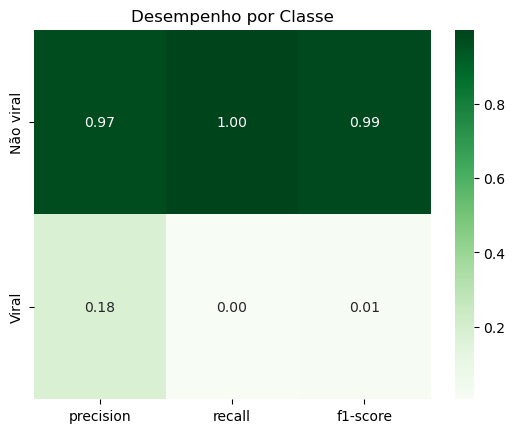


📌 Running Experiment 6/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': 'balanced'}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=balanced

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.76      0.86     16085
       Viral       0.07      0.71      0.13       448

    accuracy                           0.75     16533
   macro avg       0.53      0.73      0.50     16533
weighted avg       0.96      0.75      0.84     16533



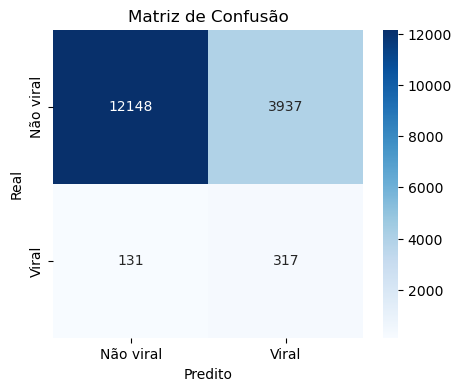

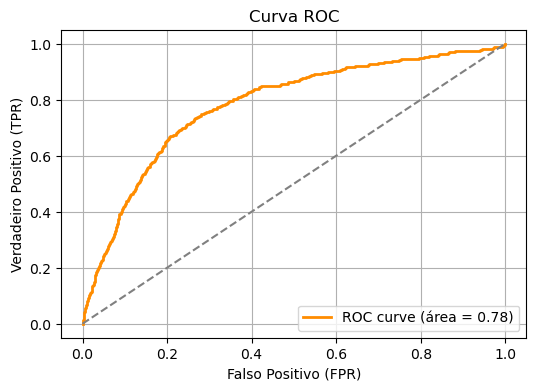

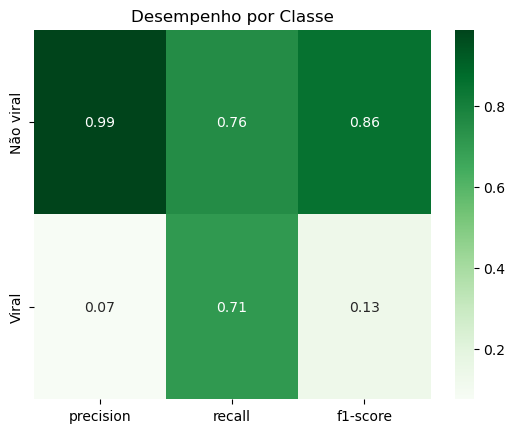


📌 Running Experiment 7/9
{'normalize': 'zscore', 'balance_strategy': 'smote', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=smote, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.77      0.86     16085
       Viral       0.07      0.67      0.13       448

    accuracy                           0.76     16533
   macro avg       0.53      0.72      0.50     16533
weighted avg       0.96      0.76      0.84     16533



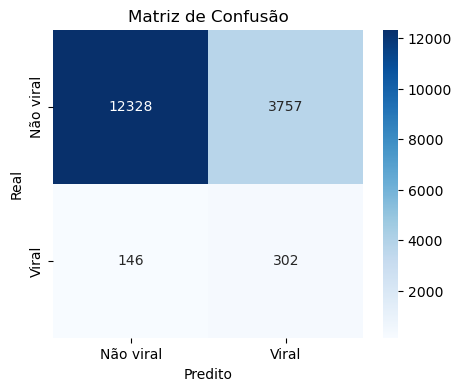

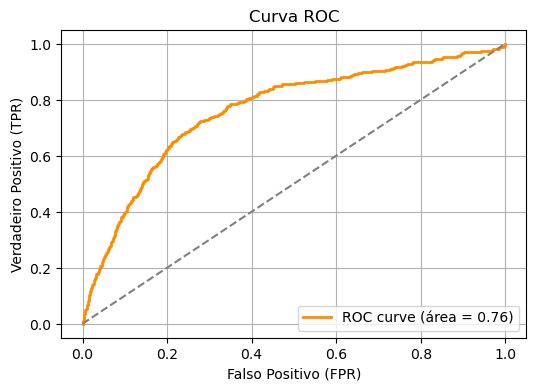

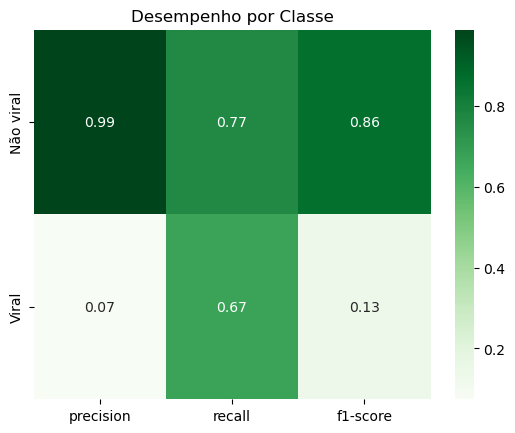


📌 Running Experiment 8/9
{'normalize': 'zscore', 'balance_strategy': 'ros', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=ros, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.75      0.86     16085
       Viral       0.07      0.70      0.13       448

    accuracy                           0.75     16533
   macro avg       0.53      0.73      0.49     16533
weighted avg       0.96      0.75      0.84     16533



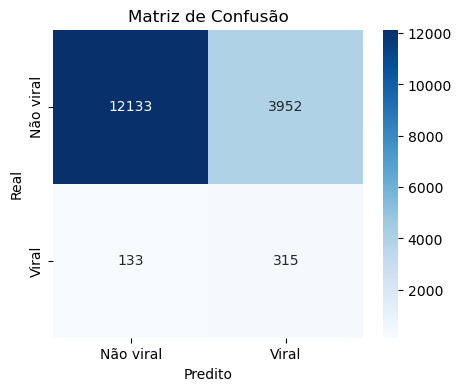

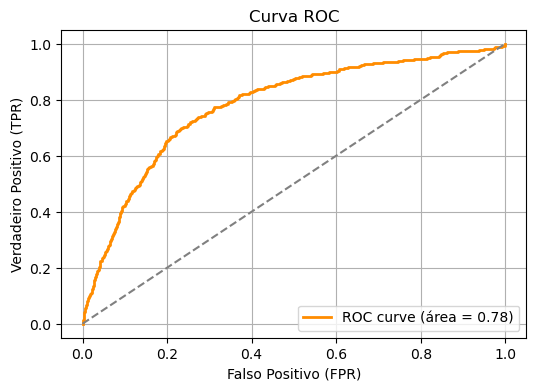

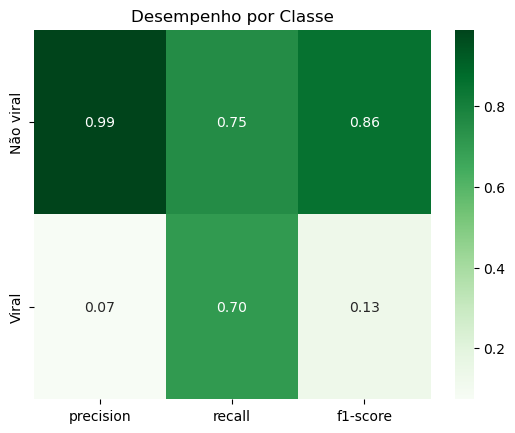


📌 Running Experiment 9/9
{'normalize': 'zscore', 'balance_strategy': 'rus', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=rus, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.71      0.83     16085
       Viral       0.07      0.72      0.12       448

    accuracy                           0.71     16533
   macro avg       0.53      0.72      0.48     16533
weighted avg       0.96      0.71      0.81     16533



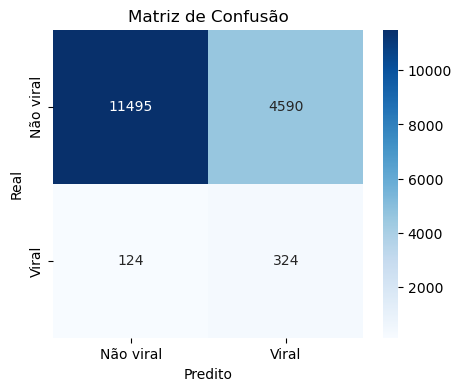

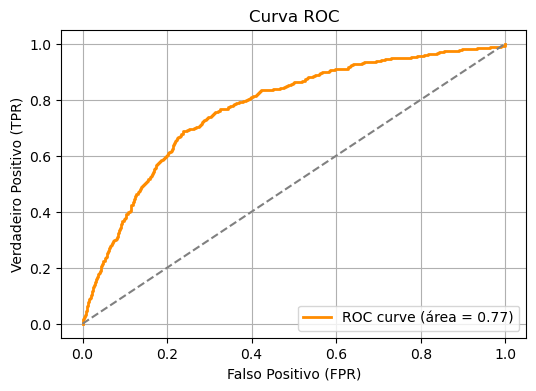

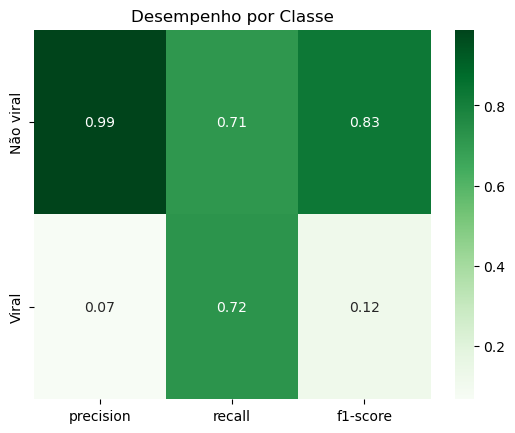

In [96]:
results_regression_bow = []

solver_for_penalty = {
    "l1": "liblinear",
    "l2": "liblinear",
    "elasticnet": "saga"
}

for i, config in enumerate(experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(experiment_configs)}")
    print(config)

    # Dynamically assign solver and l1_ratio
    penalty = config["penalty"]
    solver = solver_for_penalty[penalty]
    l1_ratio = 0.5 if penalty == "elasticnet" else None

    report_dict = run_logistic_experiment(
        X_bow_train, X_bow_test, y_bow_train, y_bow_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        penalty=penalty,
        solver=solver,
        class_weight=config["class_weight"],
        l1_ratio=l1_ratio,
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results_regression.append({
        **config,
        "solver": solver,
        "l1_ratio": l1_ratio,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### Word2Vec


📌 Running Experiment 1/9
{'normalize': None, 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=None, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.33      0.00      0.01       448

    accuracy                           0.97     16533
   macro avg       0.65      0.50      0.50     16533
weighted avg       0.96      0.97      0.96     16533



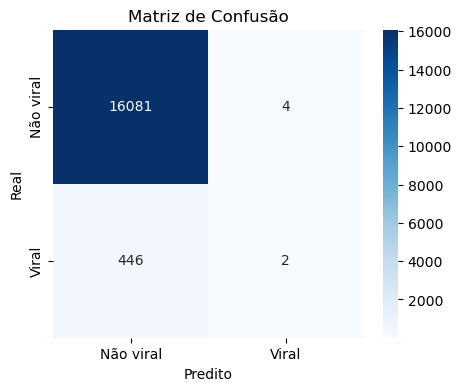

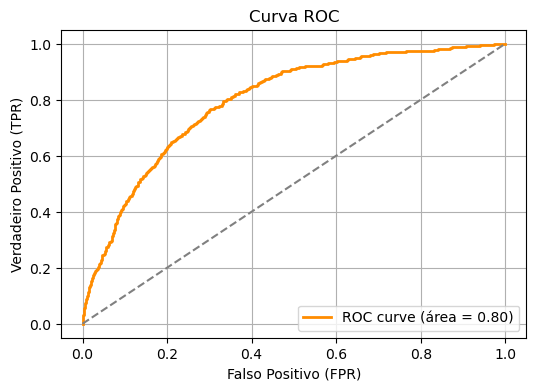

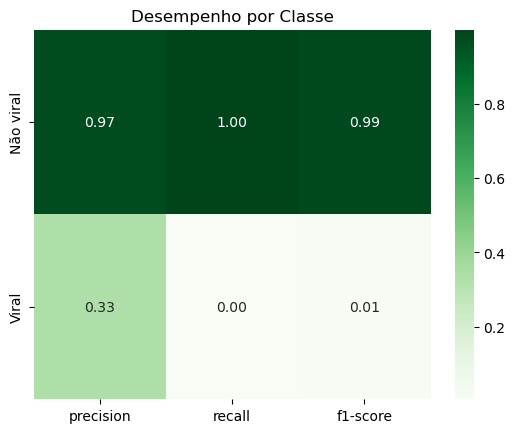


📌 Running Experiment 2/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.40      0.00      0.01       448

    accuracy                           0.97     16533
   macro avg       0.69      0.50      0.50     16533
weighted avg       0.96      0.97      0.96     16533



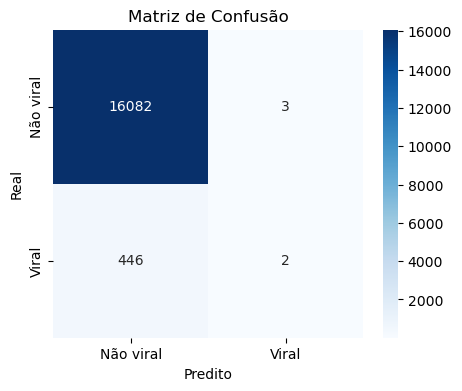

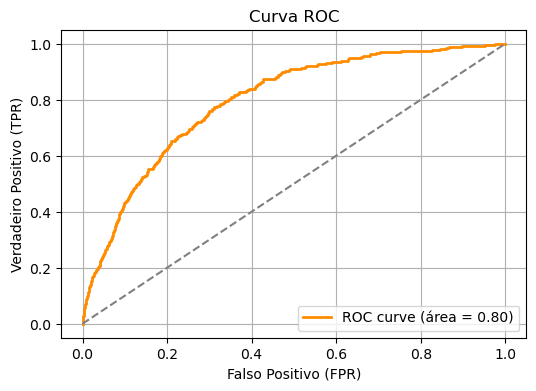

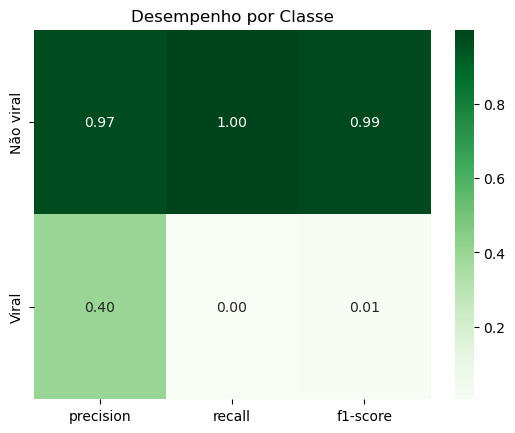


📌 Running Experiment 3/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.50      0.00      0.01       448

    accuracy                           0.97     16533
   macro avg       0.74      0.50      0.50     16533
weighted avg       0.96      0.97      0.96     16533



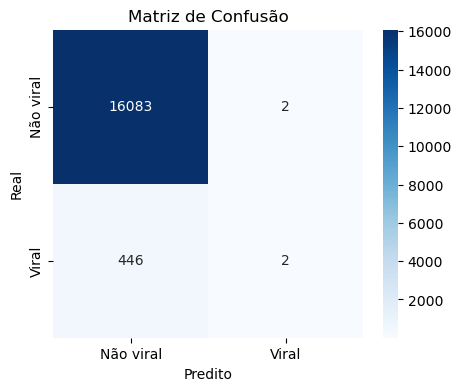

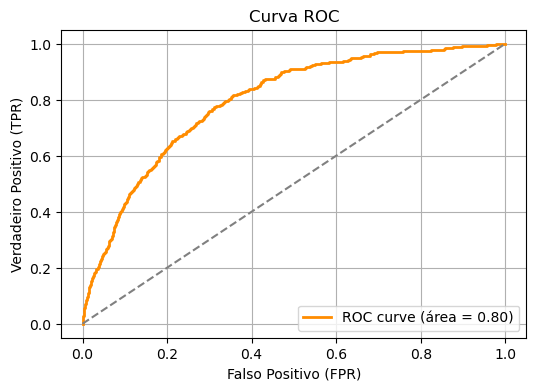

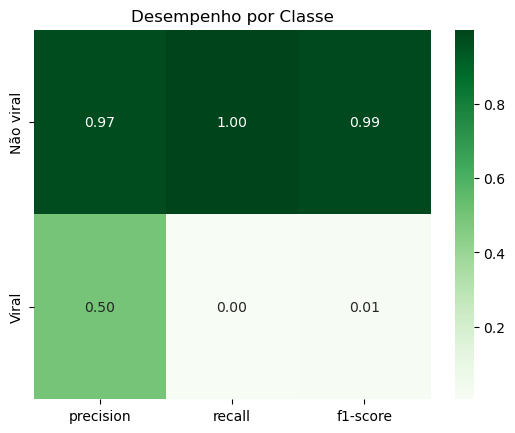


📌 Running Experiment 4/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'elasticnet', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=elasticnet, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.50      0.00      0.01       448

    accuracy                           0.97     16533
   macro avg       0.74      0.50      0.50     16533
weighted avg       0.96      0.97      0.96     16533



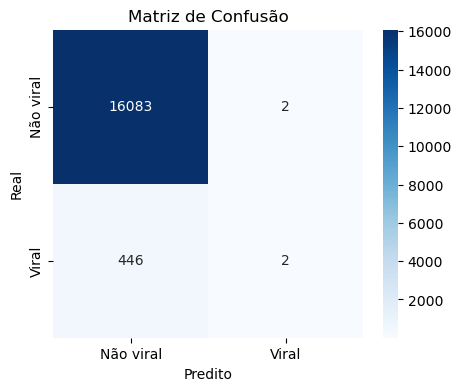

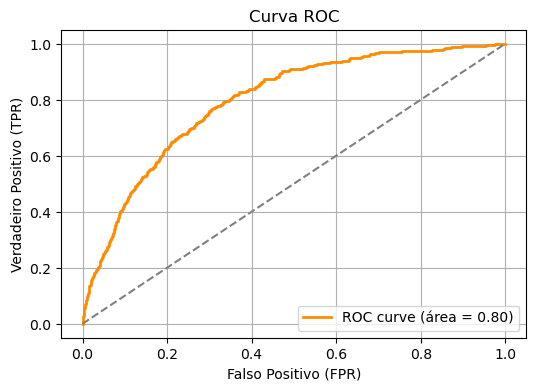

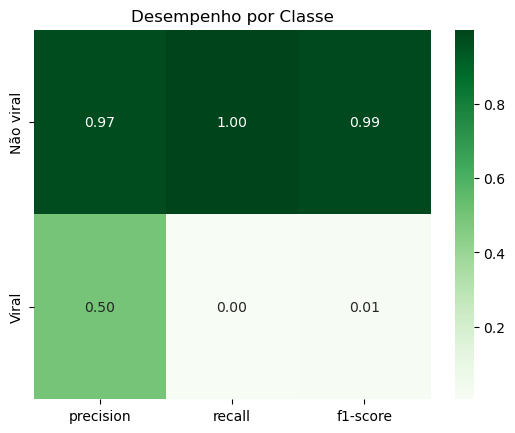


📌 Running Experiment 5/9
{'normalize': 'minmax', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=minmax, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.50      0.00      0.01       448

    accuracy                           0.97     16533
   macro avg       0.74      0.50      0.50     16533
weighted avg       0.96      0.97      0.96     16533



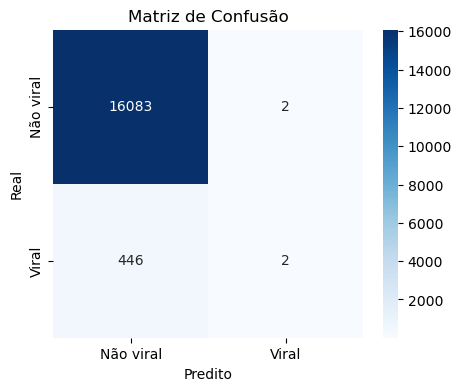

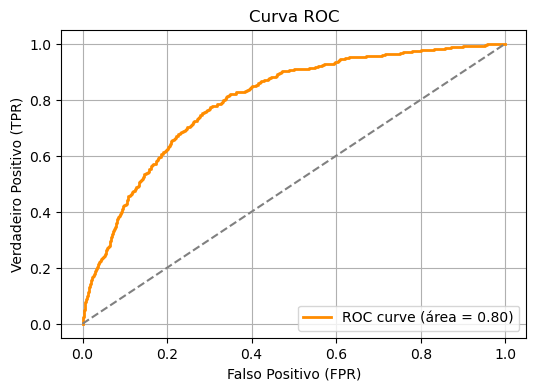

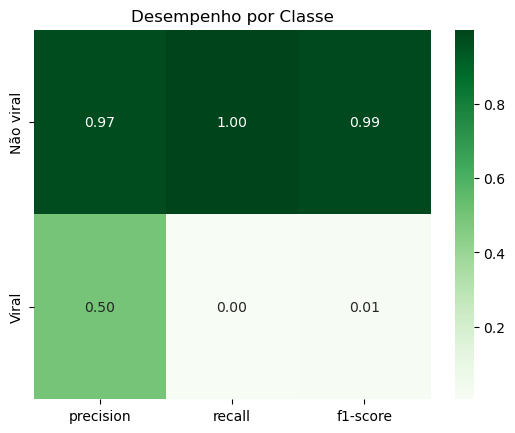


📌 Running Experiment 6/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': 'balanced'}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=balanced

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.73      0.84     16085
       Viral       0.07      0.72      0.13       448

    accuracy                           0.73     16533
   macro avg       0.53      0.73      0.49     16533
weighted avg       0.96      0.73      0.82     16533



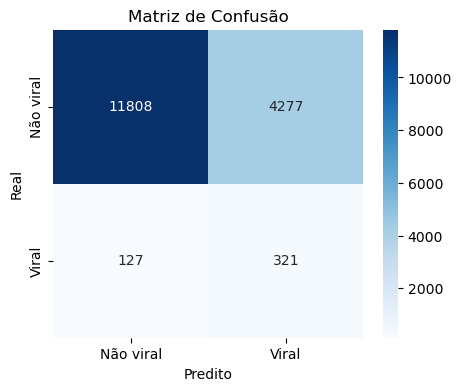

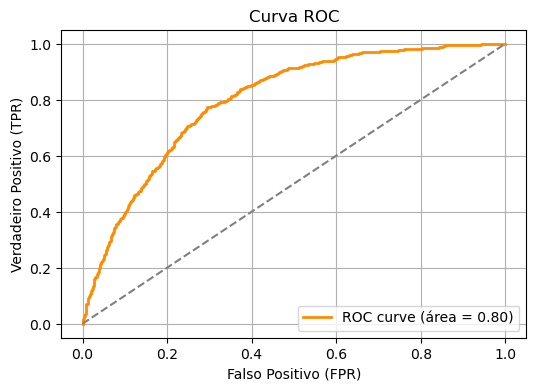

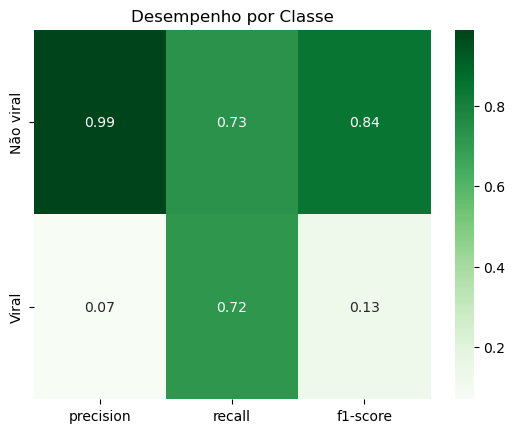


📌 Running Experiment 7/9
{'normalize': 'zscore', 'balance_strategy': 'smote', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=smote, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.74      0.85     16085
       Viral       0.07      0.70      0.13       448

    accuracy                           0.74     16533
   macro avg       0.53      0.72      0.49     16533
weighted avg       0.96      0.74      0.83     16533



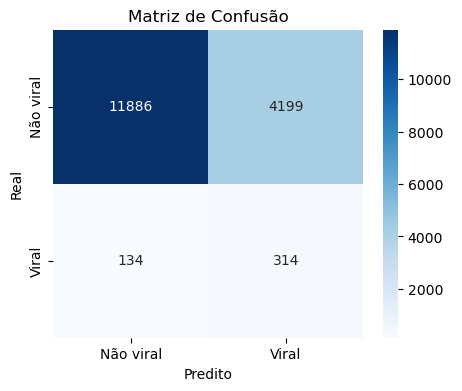

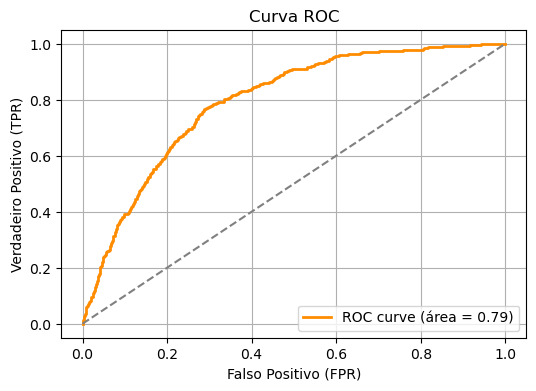

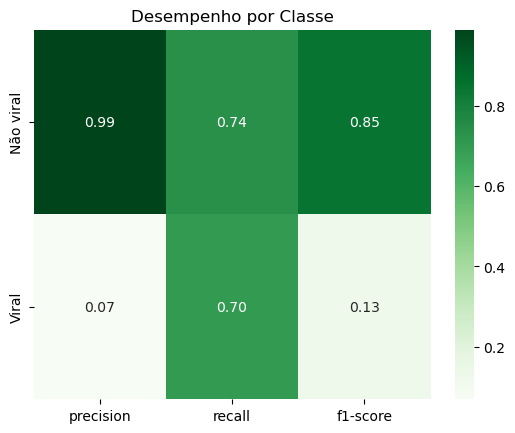


📌 Running Experiment 8/9
{'normalize': 'zscore', 'balance_strategy': 'ros', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=ros, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.73      0.84     16085
       Viral       0.07      0.72      0.13       448

    accuracy                           0.73     16533
   macro avg       0.53      0.73      0.49     16533
weighted avg       0.96      0.73      0.82     16533



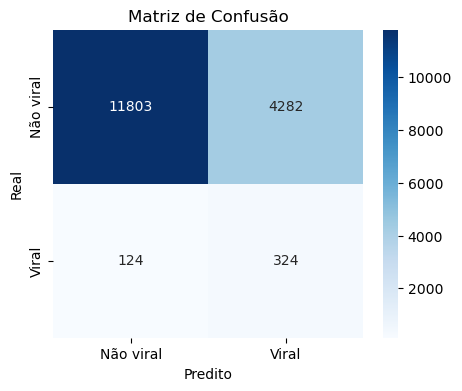

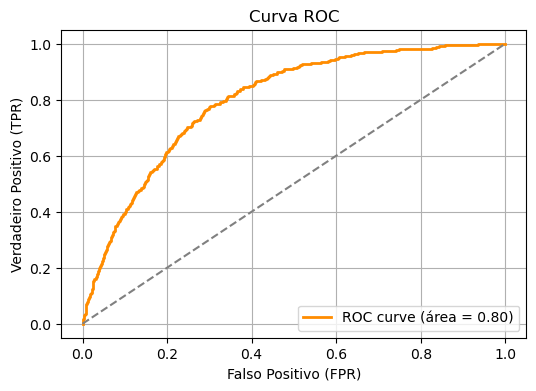

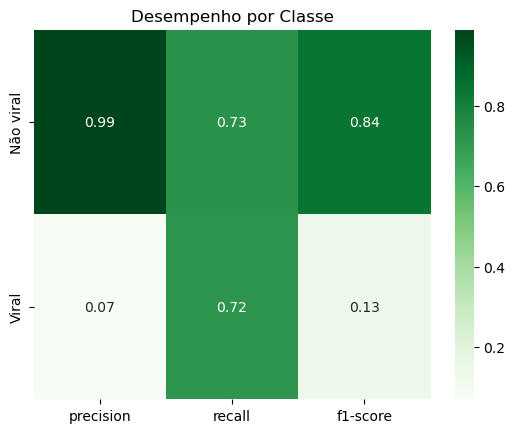


📌 Running Experiment 9/9
{'normalize': 'zscore', 'balance_strategy': 'rus', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=rus, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.71      0.83     16085
       Viral       0.07      0.75      0.12       448

    accuracy                           0.72     16533
   macro avg       0.53      0.73      0.48     16533
weighted avg       0.97      0.72      0.81     16533



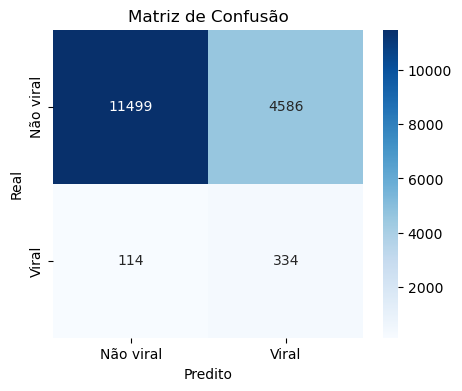

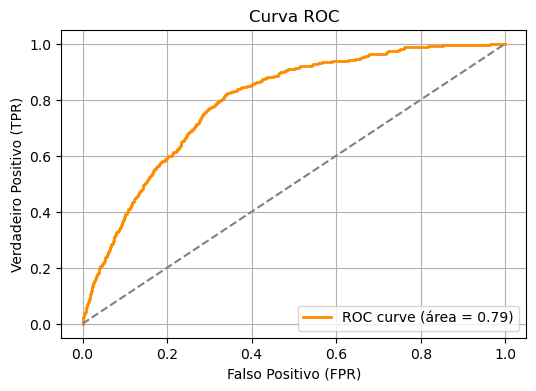

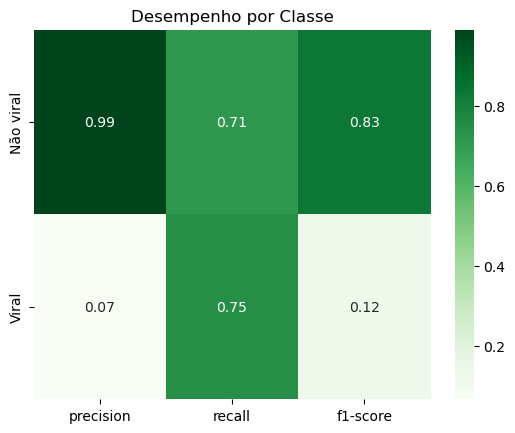

In [97]:
results_regression_word2vec = []

solver_for_penalty = {
    "l1": "liblinear",
    "l2": "liblinear",
    "elasticnet": "saga"
}

for i, config in enumerate(experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(experiment_configs)}")
    print(config)

    # Dynamically assign solver and l1_ratio
    penalty = config["penalty"]
    solver = solver_for_penalty[penalty]
    l1_ratio = 0.5 if penalty == "elasticnet" else None

    report_dict = run_logistic_experiment(
        X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        penalty=penalty,
        solver=solver,
        class_weight=config["class_weight"],
        l1_ratio=l1_ratio,
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results_regression.append({
        **config,
        "solver": solver,
        "l1_ratio": l1_ratio,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

#### Árvore de Decisão

In [93]:
from sklearn.tree import DecisionTreeClassifier

def run_decision_tree_experiment(
    X_train, X_test, y_train, y_test,
    balance_strategy=None,
    normalize=None,
    class_weight=None,
    max_depth=None,
    random_state=42,
    verbose=True
):
    print(f"\n🔧 Config DT: balance={balance_strategy}, normalize={normalize}, class_weight={class_weight}, max_depth={max_depth}")
    
    # Normalização igual ao run_logistic_experiment
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Balanceamento
    if balance_strategy == "smote":
        sampler = SMOTE(random_state=random_state)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=random_state)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        sampler = None
    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    model = DecisionTreeClassifier(
        class_weight=class_weight,
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Exemplo de classification_report
    print("\n📊 Classification Report")
    print(classification_report(y_test, y_pred, target_names=["Não viral", "Viral"]))
   
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Não viral", "Viral"], yticklabels=["Não viral", "Viral"])
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Plot curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Falso Positivo (FPR)")
    plt.ylabel("Verdadeiro Positivo (TPR)")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot métricas por classe
    df_plot = pd.DataFrame(report_dict).transpose().loc[["Não viral", "Viral"], ["precision", "recall", "f1-score"]]
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Greens")
    plt.title("Desempenho por Classe")
    plt.show()

    return classification_report(y_test, y_pred, target_names=["Não viral", "Viral"], output_dict=True)

In [94]:
dt_experiment_configs = [
    # Baseline
    {"normalize": None, "balance_strategy": None, "max_depth": None, "class_weight": None},

    # Variação de normalização
    {"normalize": "zscore", "balance_strategy": None, "max_depth": None, "class_weight": None},
    {"normalize": "minmax", "balance_strategy": None, "max_depth": None, "class_weight": None},

    # Class weighting
    {"normalize": "zscore", "balance_strategy": None, "max_depth": None, "class_weight": "balanced"},

    # Com balanceamento
    {"normalize": "zscore", "balance_strategy": "smote", "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "ros", "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "rus", "max_depth": None, "class_weight": None},

    # Testando profundidades diferentes
    {"normalize": "zscore", "balance_strategy": None, "max_depth": 5, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "max_depth": 10, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "max_depth": 20, "class_weight": None},
]

##### TF-IDF


📌 Running Experiment 1/10
{'normalize': None, 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=None, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.98     16085
       Viral       0.14      0.15      0.15       448

    accuracy                           0.95     16533
   macro avg       0.56      0.56      0.56     16533
weighted avg       0.95      0.95      0.95     16533



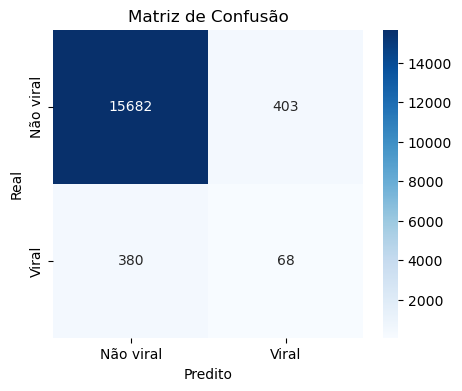

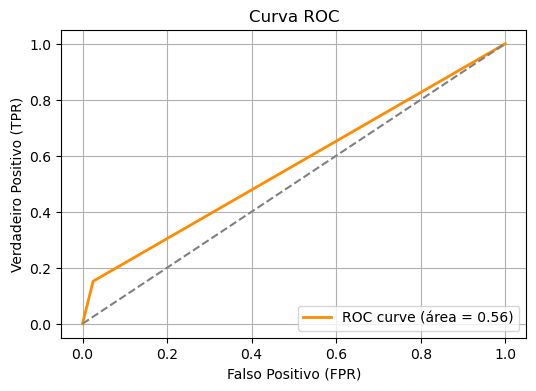

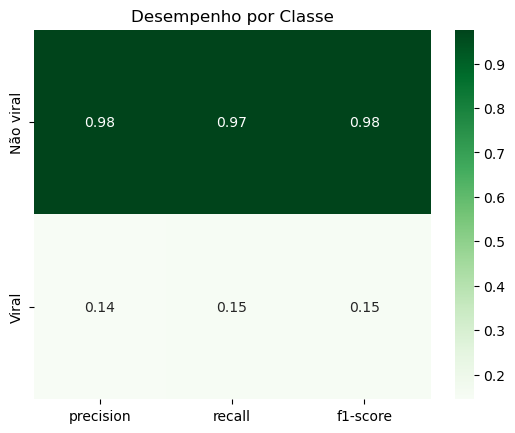


📌 Running Experiment 2/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.98     16085
       Viral       0.15      0.15      0.15       448

    accuracy                           0.95     16533
   macro avg       0.56      0.56      0.56     16533
weighted avg       0.95      0.95      0.95     16533



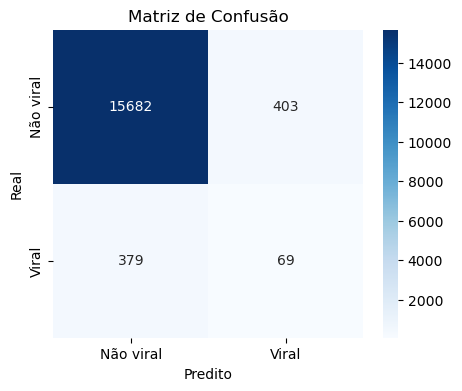

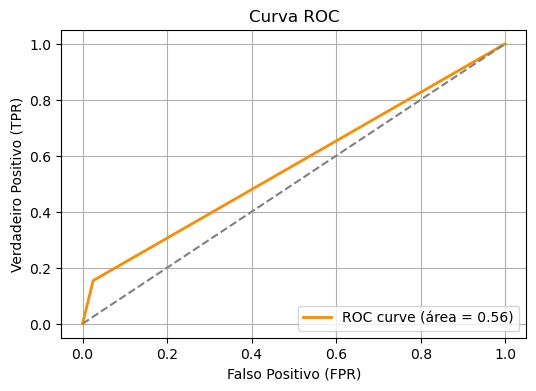

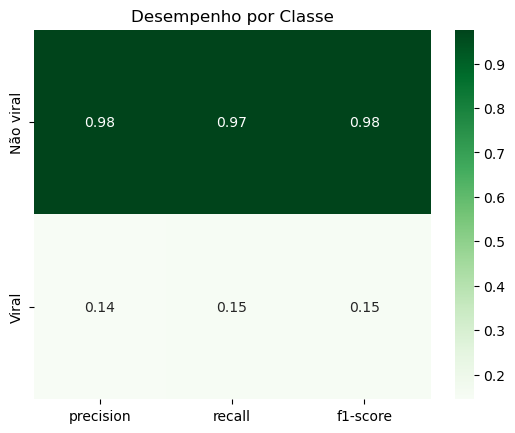


📌 Running Experiment 3/10
{'normalize': 'minmax', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=minmax, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.98     16085
       Viral       0.15      0.15      0.15       448

    accuracy                           0.95     16533
   macro avg       0.56      0.56      0.56     16533
weighted avg       0.95      0.95      0.95     16533



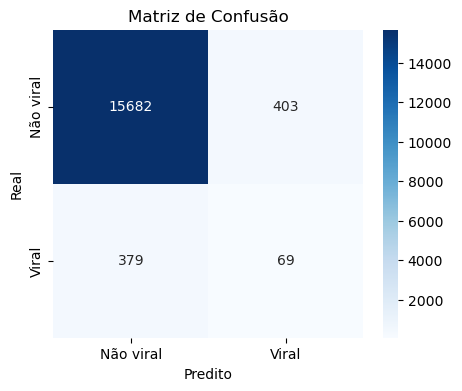

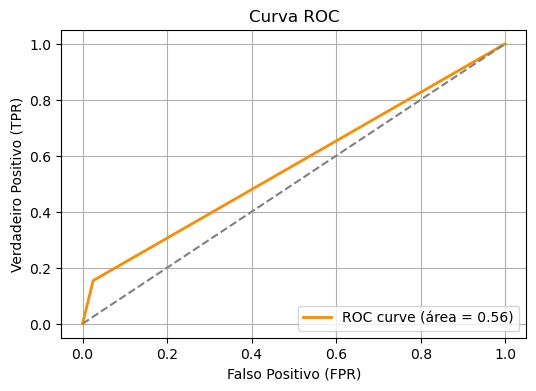

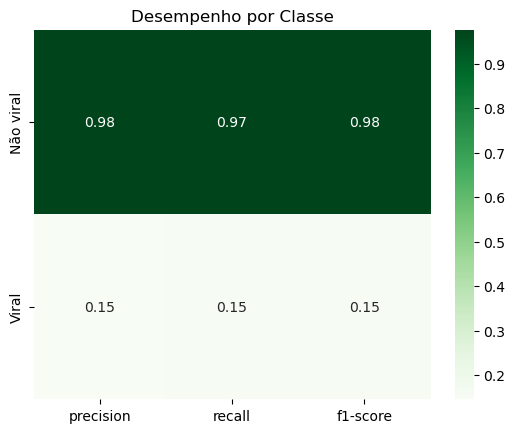


📌 Running Experiment 4/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config DT: balance=None, normalize=zscore, class_weight=balanced, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.97     16085
       Viral       0.11      0.15      0.12       448

    accuracy                           0.94     16533
   macro avg       0.54      0.56      0.55     16533
weighted avg       0.95      0.94      0.95     16533



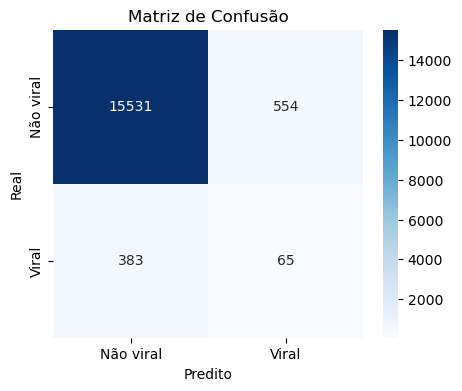

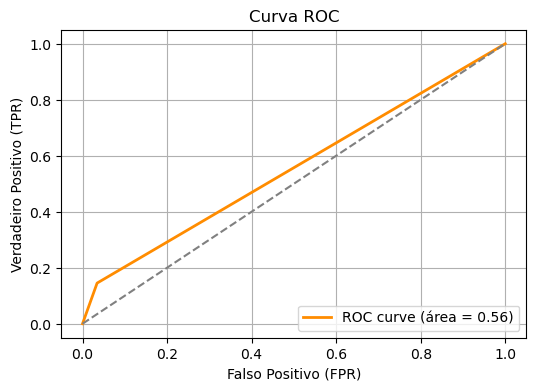

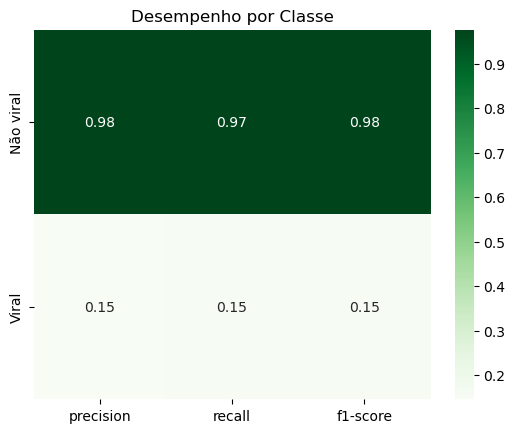


📌 Running Experiment 5/10
{'normalize': 'zscore', 'balance_strategy': 'smote', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=smote, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.96      0.97     16085
       Viral       0.11      0.16      0.13       448

    accuracy                           0.94     16533
   macro avg       0.54      0.56      0.55     16533
weighted avg       0.95      0.94      0.95     16533



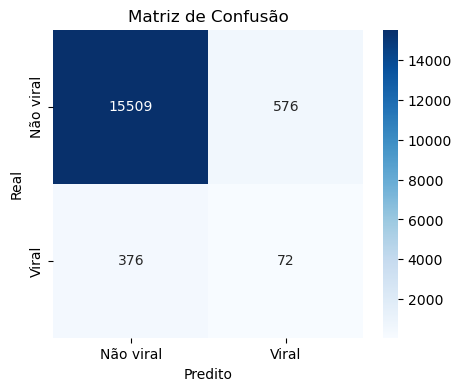

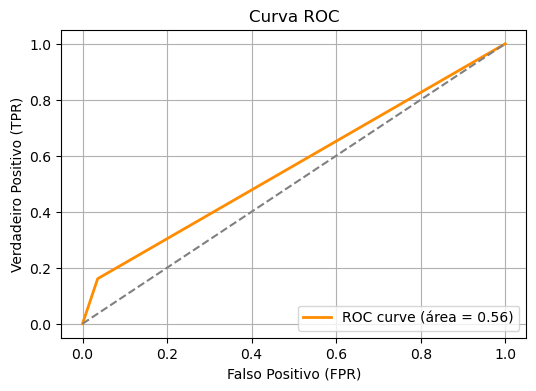

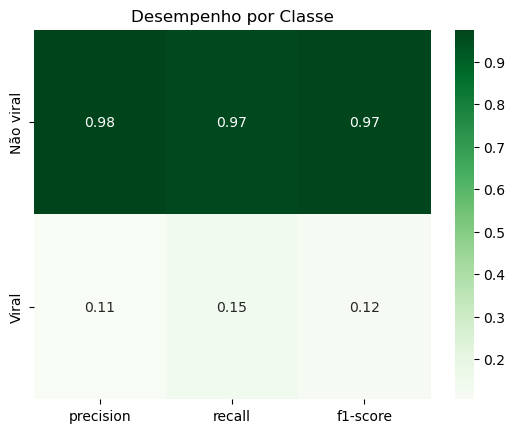


📌 Running Experiment 6/10
{'normalize': 'zscore', 'balance_strategy': 'ros', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=ros, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.97     16085
       Viral       0.09      0.12      0.10       448

    accuracy                           0.94     16533
   macro avg       0.53      0.54      0.53     16533
weighted avg       0.95      0.94      0.95     16533



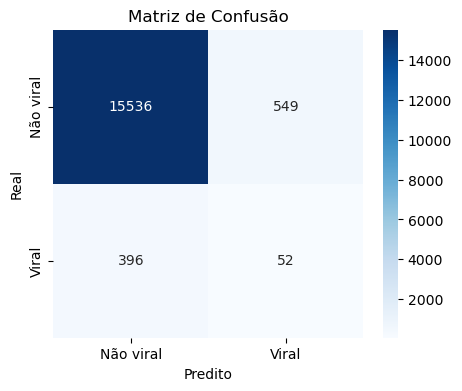

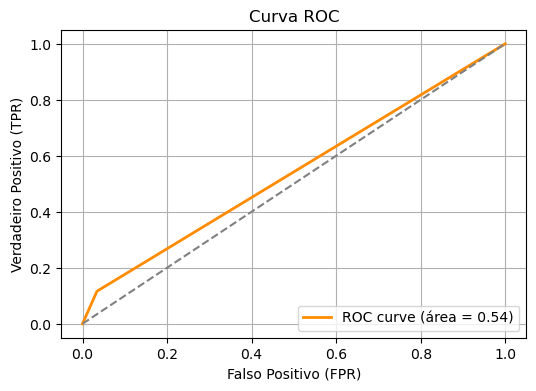

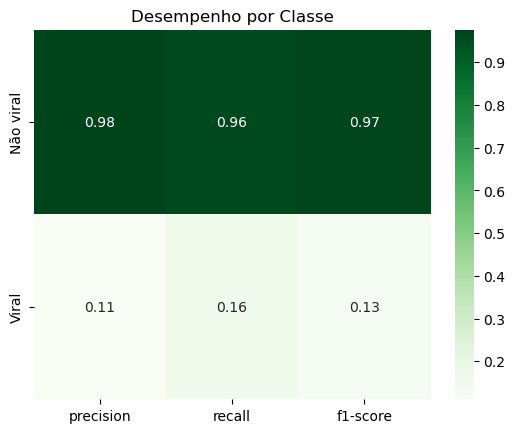


📌 Running Experiment 7/10
{'normalize': 'zscore', 'balance_strategy': 'rus', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=rus, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.65      0.78     16085
       Viral       0.05      0.65      0.09       448

    accuracy                           0.65     16533
   macro avg       0.52      0.65      0.44     16533
weighted avg       0.96      0.65      0.76     16533



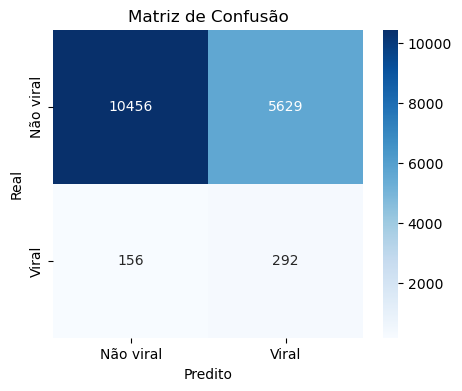

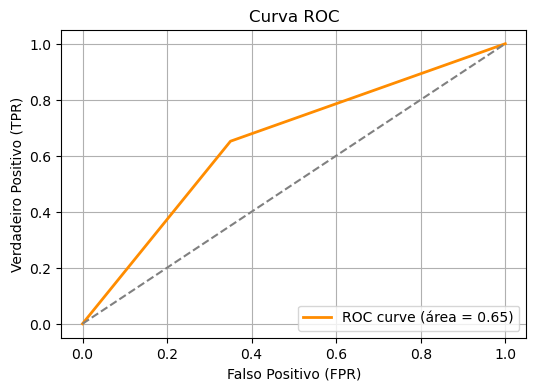

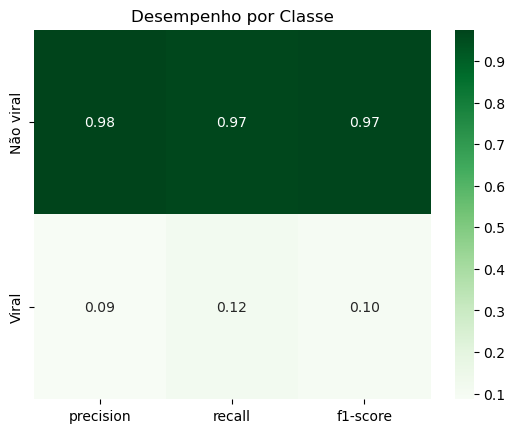


📌 Running Experiment 8/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 5, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=5

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.48      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.73      0.52      0.52     16533
weighted avg       0.96      0.97      0.96     16533



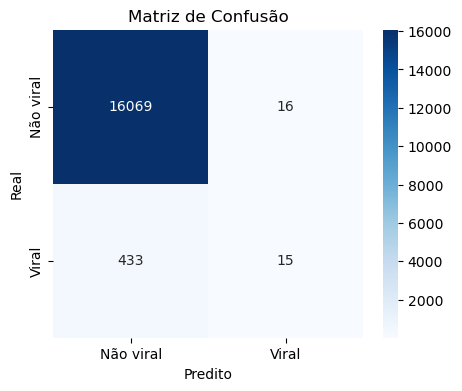

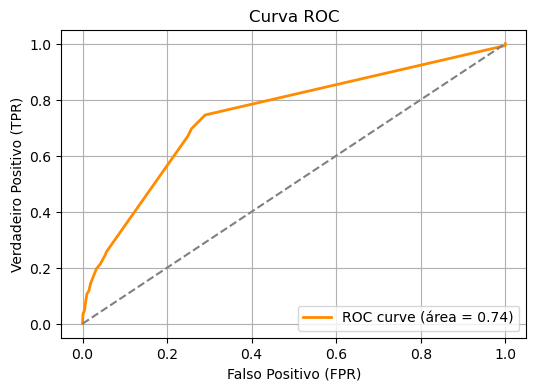

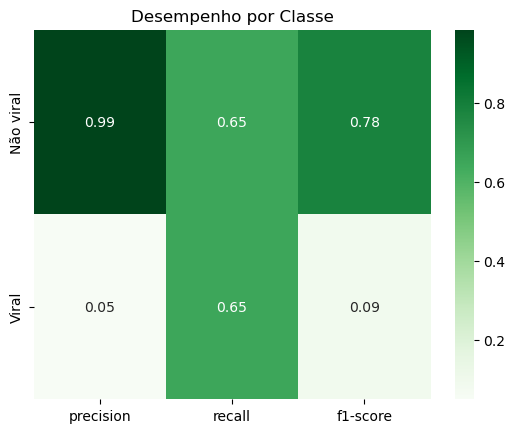


📌 Running Experiment 9/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 10, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=10

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.30      0.06      0.10       448

    accuracy                           0.97     16533
   macro avg       0.64      0.53      0.54     16533
weighted avg       0.96      0.97      0.96     16533



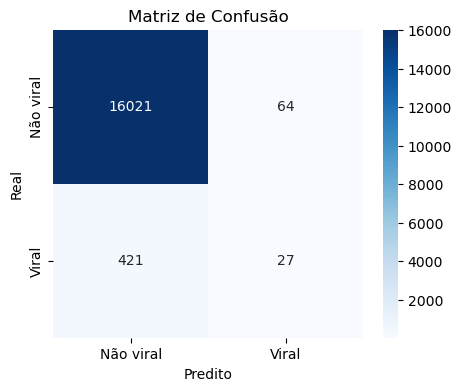

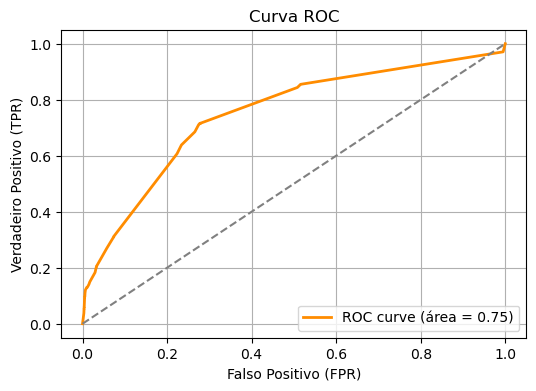

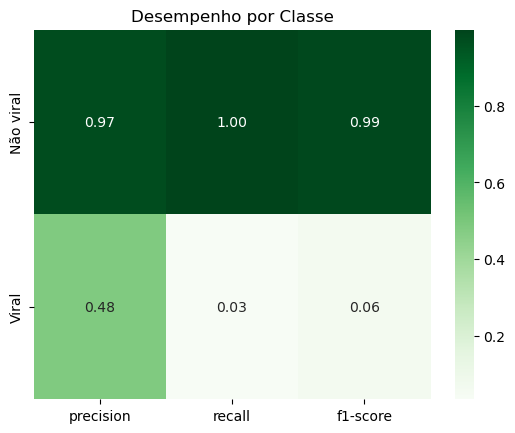


📌 Running Experiment 10/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 20, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=20

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.99      0.98     16085
       Viral       0.23      0.10      0.14       448

    accuracy                           0.97     16533
   macro avg       0.61      0.54      0.56     16533
weighted avg       0.96      0.97      0.96     16533



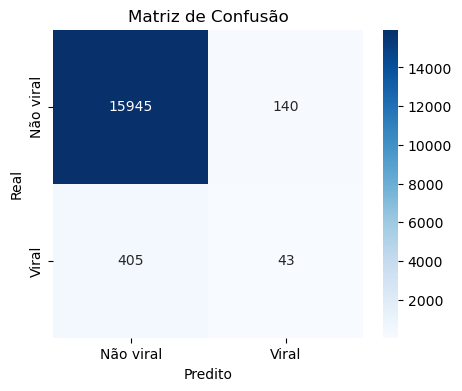

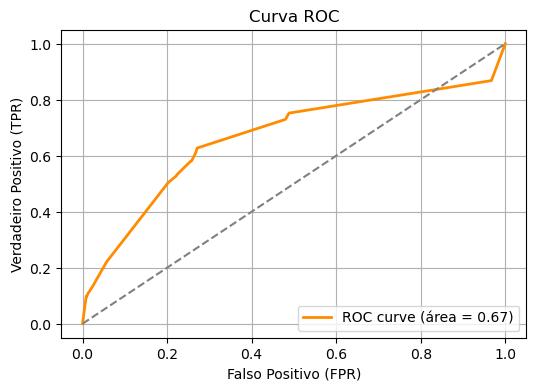

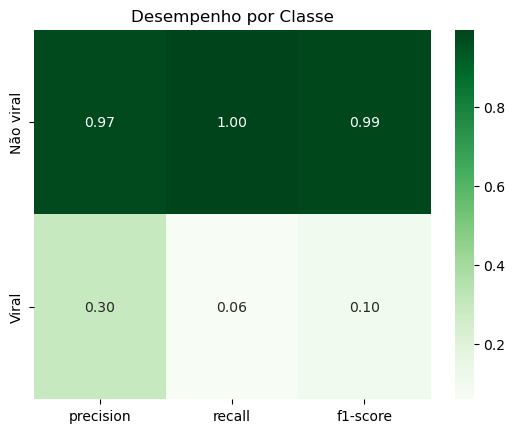

In [99]:
results_decision_tree_tfidf = []

for i, config in enumerate(dt_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(dt_experiment_configs)}")
    print(config)

    report_dict = run_decision_tree_experiment(
        X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results_decision_tree_tfidf.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### BOW


📌 Running Experiment 1/10
{'normalize': None, 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=None, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.98     16085
       Viral       0.15      0.16      0.15       448

    accuracy                           0.95     16533
   macro avg       0.56      0.57      0.56     16533
weighted avg       0.95      0.95      0.95     16533



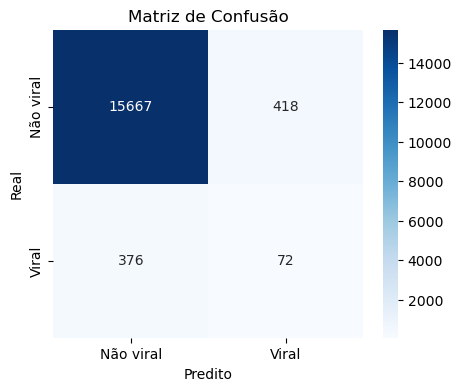

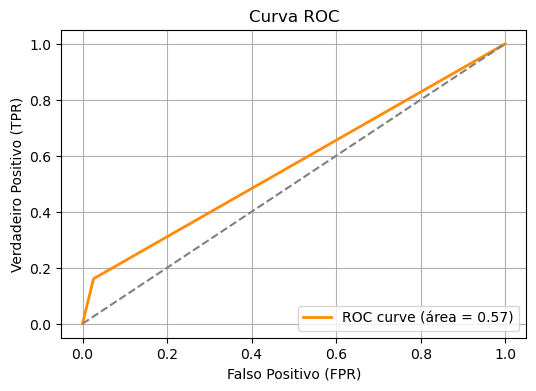

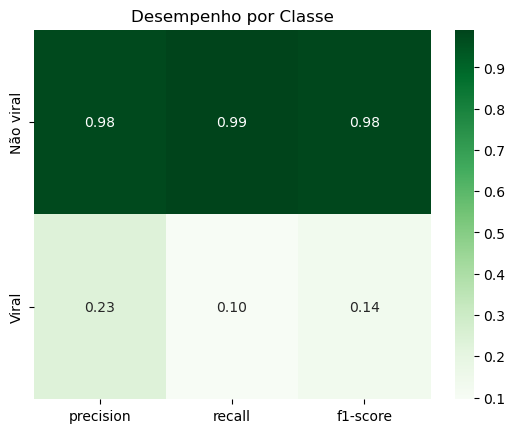


📌 Running Experiment 2/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.98     16085
       Viral       0.15      0.17      0.16       448

    accuracy                           0.95     16533
   macro avg       0.56      0.57      0.57     16533
weighted avg       0.95      0.95      0.95     16533



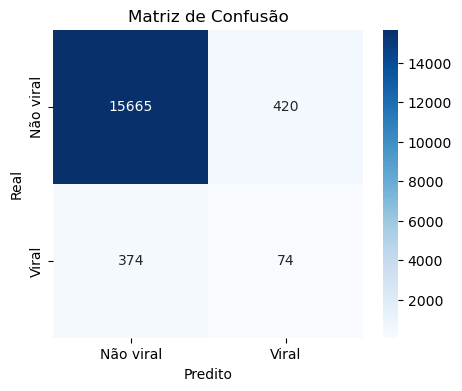

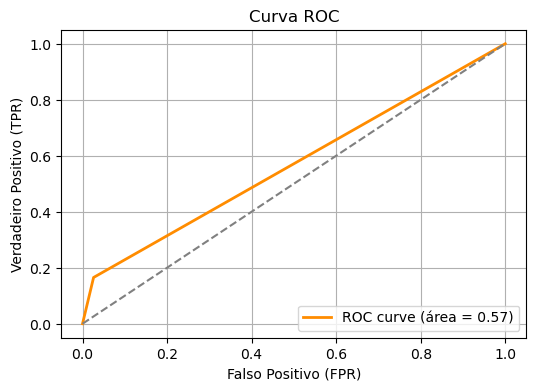

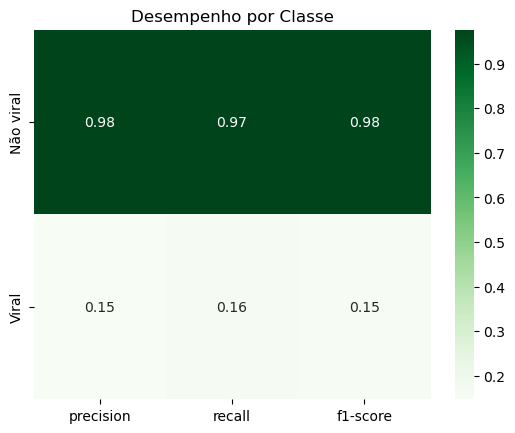


📌 Running Experiment 3/10
{'normalize': 'minmax', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=minmax, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.98     16085
       Viral       0.15      0.17      0.16       448

    accuracy                           0.95     16533
   macro avg       0.56      0.57      0.57     16533
weighted avg       0.95      0.95      0.95     16533



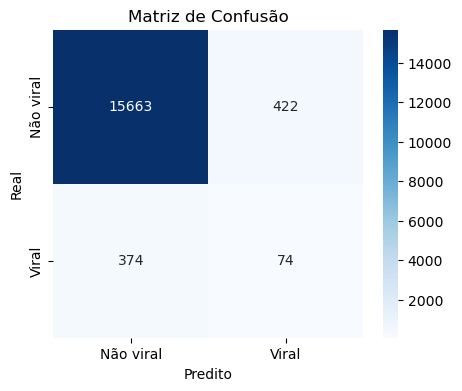

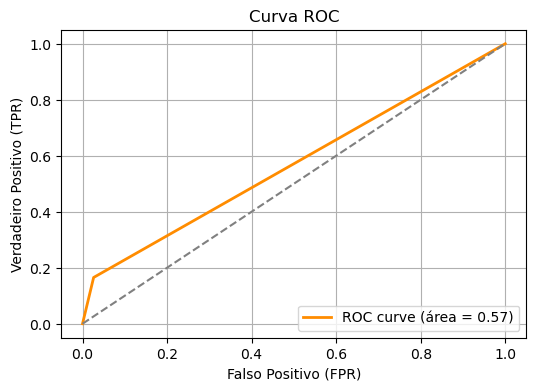

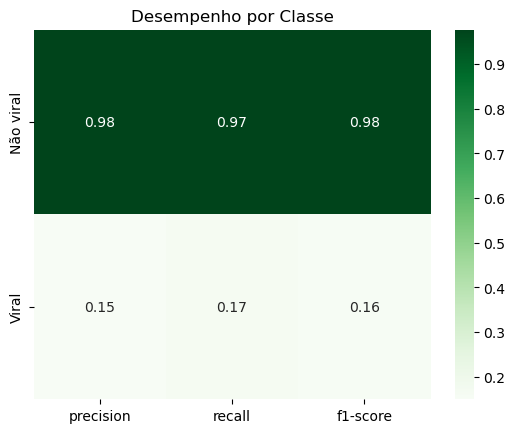


📌 Running Experiment 4/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config DT: balance=None, normalize=zscore, class_weight=balanced, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.96      0.97     16085
       Viral       0.10      0.14      0.11       448

    accuracy                           0.94     16533
   macro avg       0.54      0.55      0.54     16533
weighted avg       0.95      0.94      0.95     16533



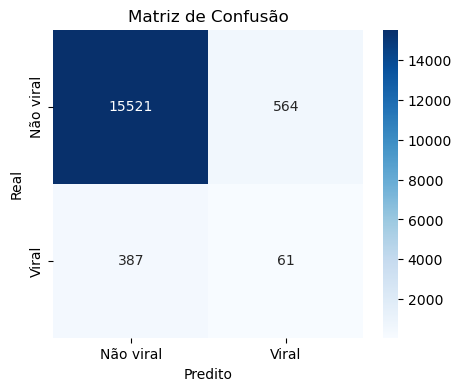

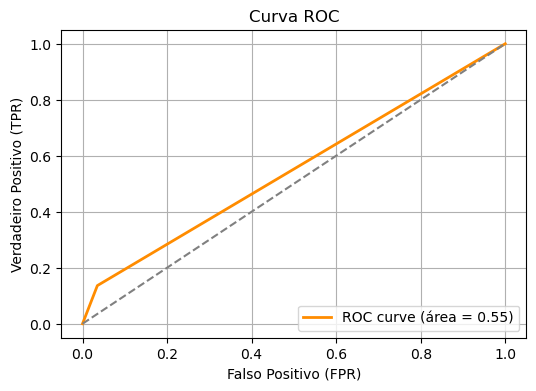

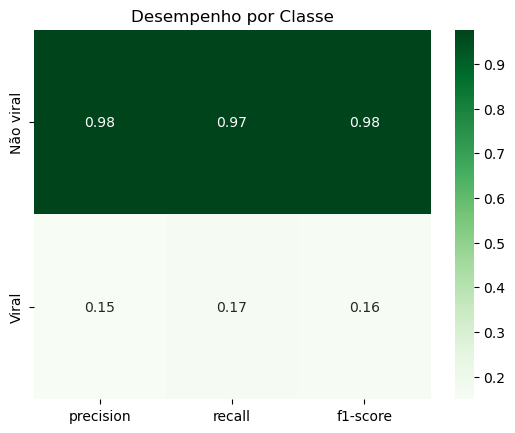


📌 Running Experiment 5/10
{'normalize': 'zscore', 'balance_strategy': 'smote', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=smote, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.97     16085
       Viral       0.12      0.14      0.13       448

    accuracy                           0.95     16533
   macro avg       0.55      0.56      0.55     16533
weighted avg       0.95      0.95      0.95     16533



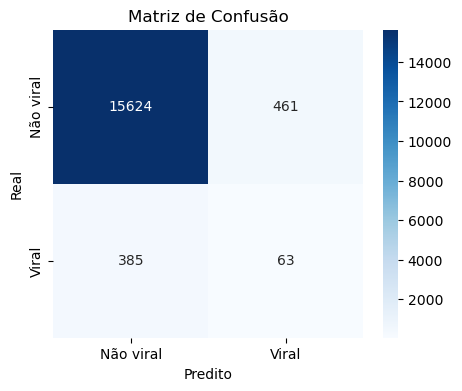

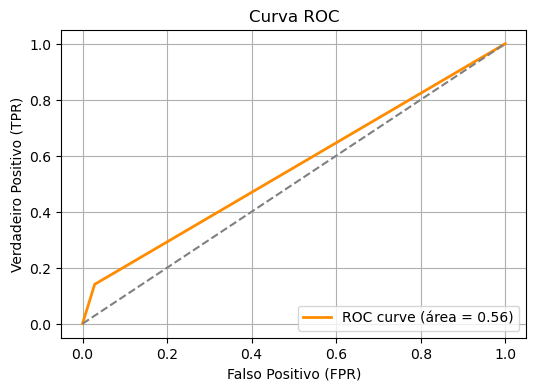

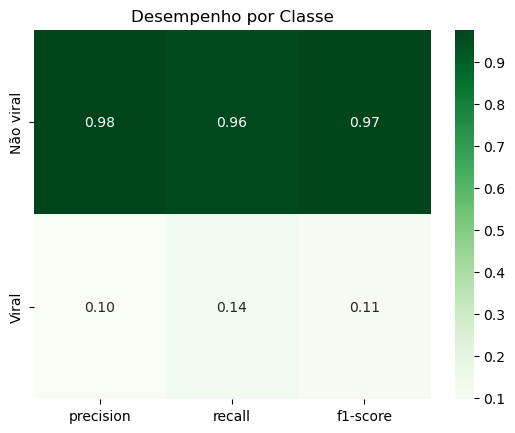


📌 Running Experiment 6/10
{'normalize': 'zscore', 'balance_strategy': 'ros', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=ros, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.97     16085
       Viral       0.09      0.11      0.10       448

    accuracy                           0.94     16533
   macro avg       0.53      0.54      0.54     16533
weighted avg       0.95      0.94      0.95     16533



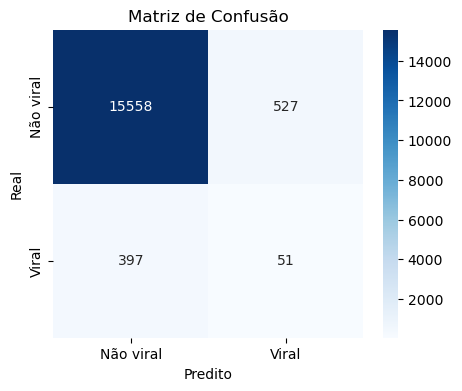

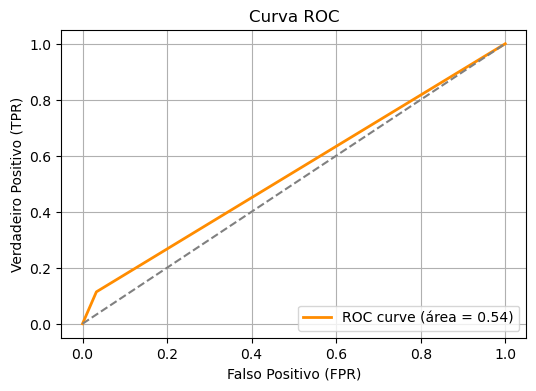

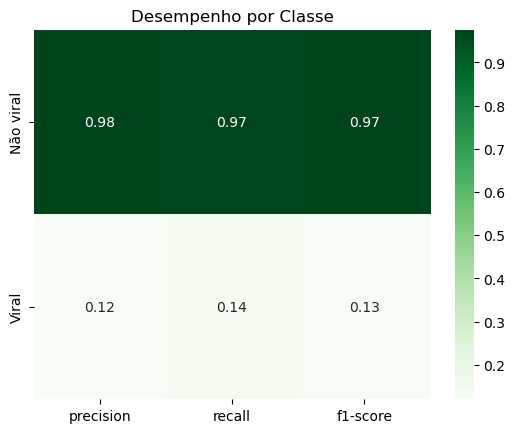


📌 Running Experiment 7/10
{'normalize': 'zscore', 'balance_strategy': 'rus', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=rus, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.63      0.77     16085
       Viral       0.05      0.66      0.09       448

    accuracy                           0.63     16533
   macro avg       0.52      0.65      0.43     16533
weighted avg       0.96      0.63      0.75     16533



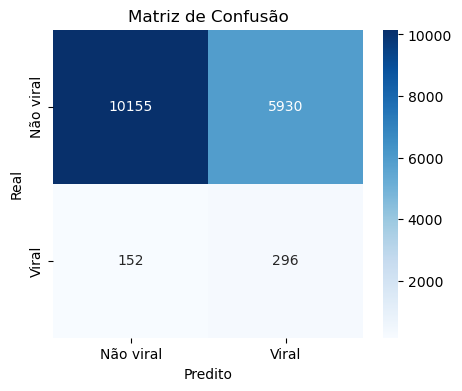

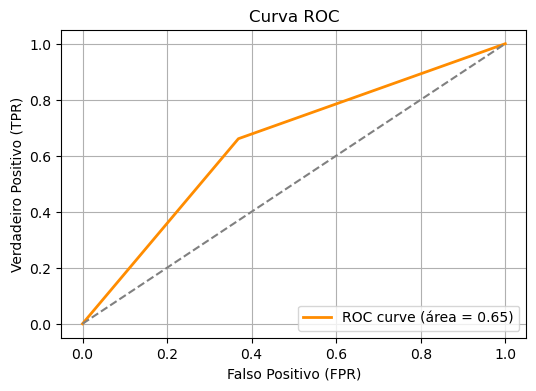

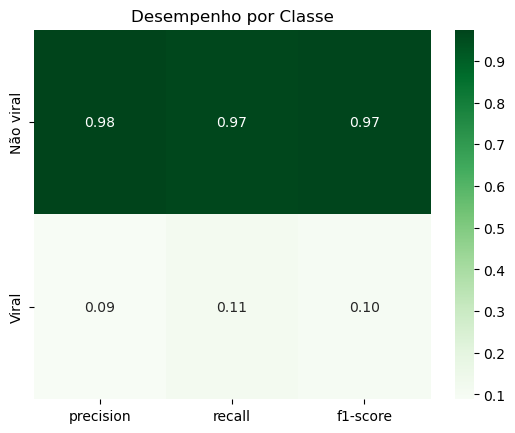


📌 Running Experiment 8/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 5, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=5

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.40      0.04      0.07       448

    accuracy                           0.97     16533
   macro avg       0.69      0.52      0.53     16533
weighted avg       0.96      0.97      0.96     16533



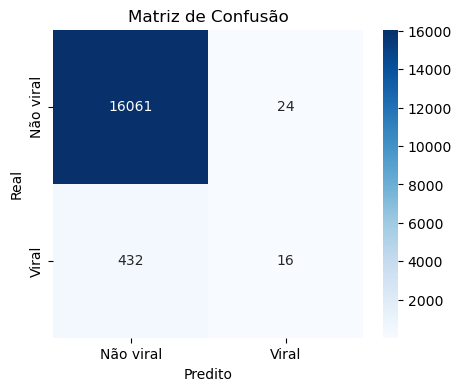

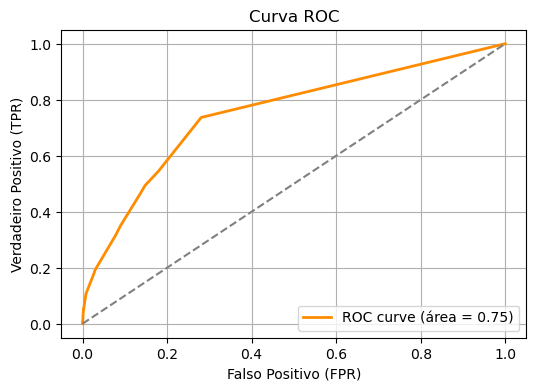

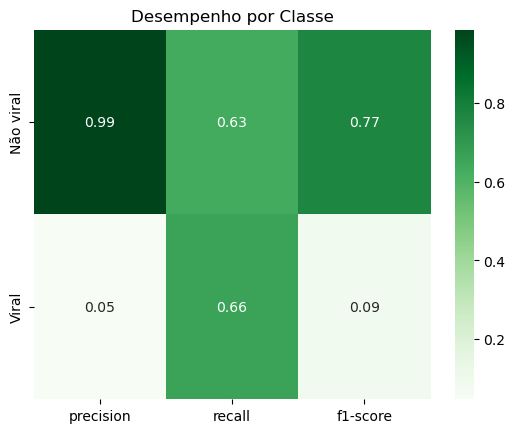


📌 Running Experiment 9/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 10, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=10

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.29      0.05      0.09       448

    accuracy                           0.97     16533
   macro avg       0.63      0.52      0.54     16533
weighted avg       0.96      0.97      0.96     16533



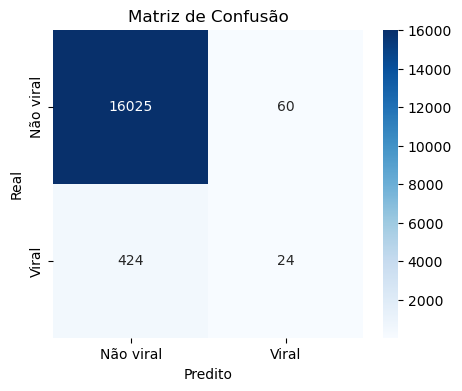

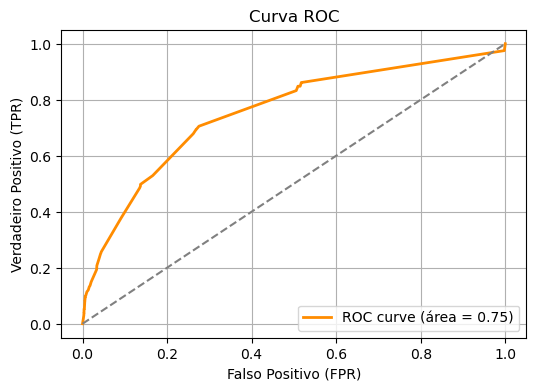

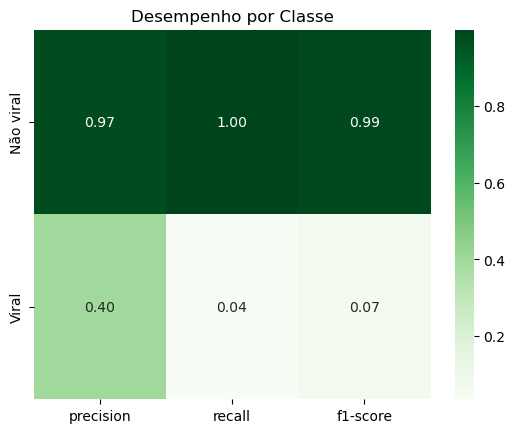


📌 Running Experiment 10/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 20, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=20

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.99      0.98     16085
       Viral       0.22      0.10      0.14       448

    accuracy                           0.97     16533
   macro avg       0.60      0.55      0.56     16533
weighted avg       0.96      0.97      0.96     16533



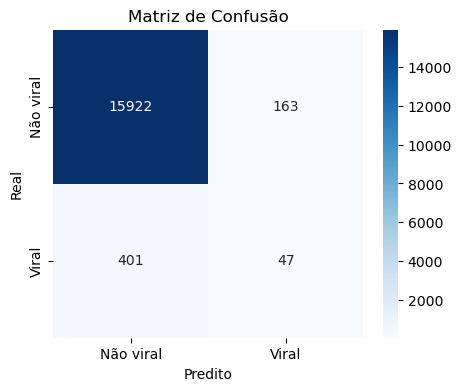

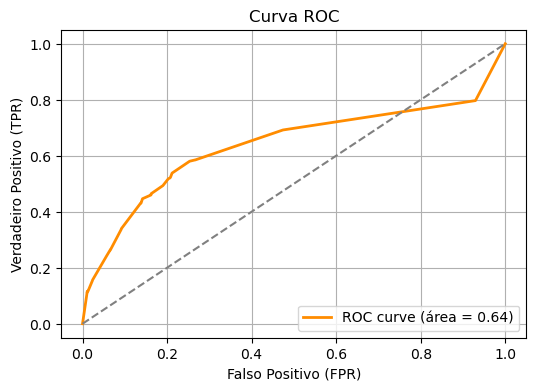

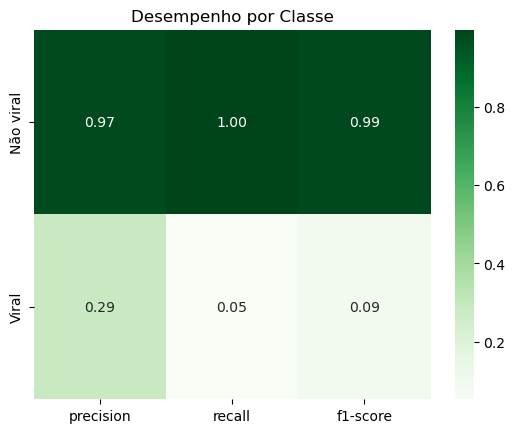

In [100]:
results_decision_tree_bow = []

for i, config in enumerate(dt_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(dt_experiment_configs)}")
    print(config)

    report_dict = run_decision_tree_experiment(
        X_bow_train, X_bow_test, y_bow_train, y_bow_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results_decision_tree_bow.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### Word2Vec


📌 Running Experiment 1/10
{'normalize': None, 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=None, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.97     16085
       Viral       0.10      0.13      0.11       448

    accuracy                           0.95     16533
   macro avg       0.54      0.55      0.54     16533
weighted avg       0.95      0.95      0.95     16533



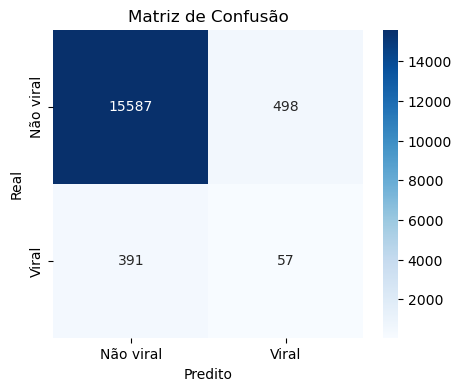

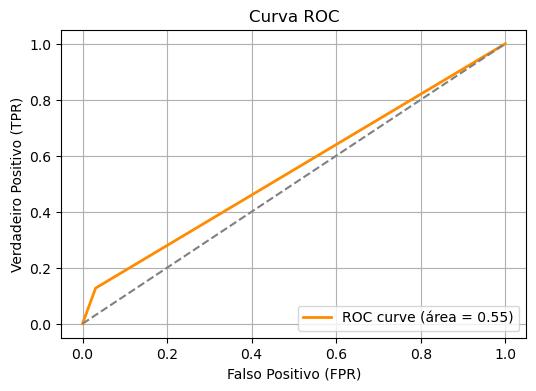

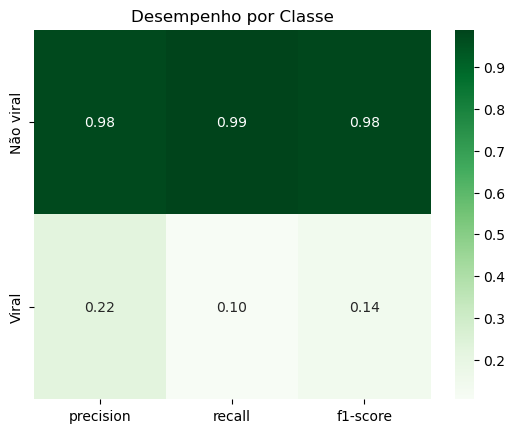


📌 Running Experiment 2/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      0.97      0.97     16085
       Viral       0.09      0.10      0.10       448

    accuracy                           0.95     16533
   macro avg       0.53      0.54      0.53     16533
weighted avg       0.95      0.95      0.95     16533



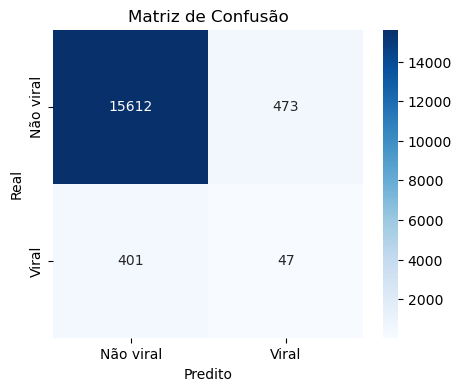

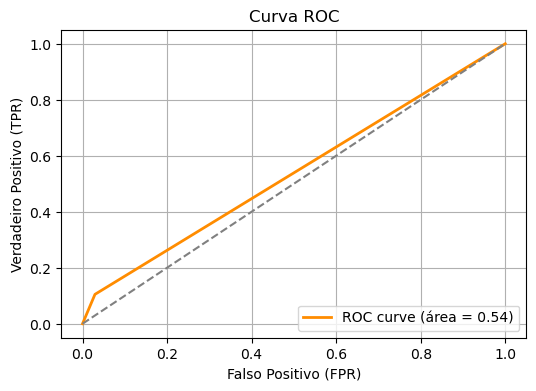

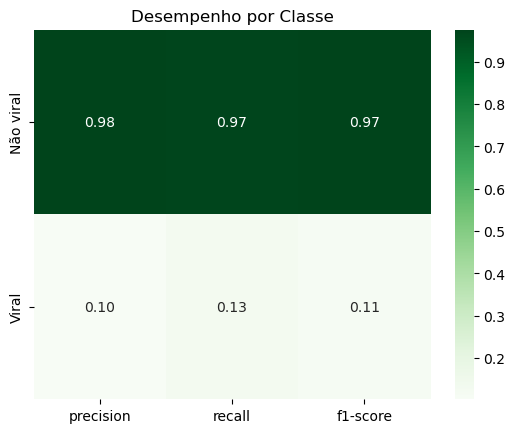


📌 Running Experiment 3/10
{'normalize': 'minmax', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=minmax, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.97      0.97     16085
       Viral       0.10      0.13      0.11       448

    accuracy                           0.95     16533
   macro avg       0.54      0.55      0.54     16533
weighted avg       0.95      0.95      0.95     16533



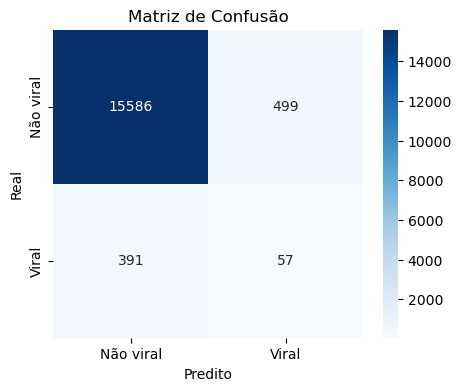

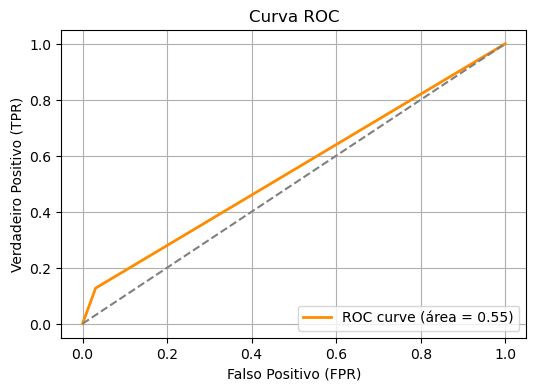

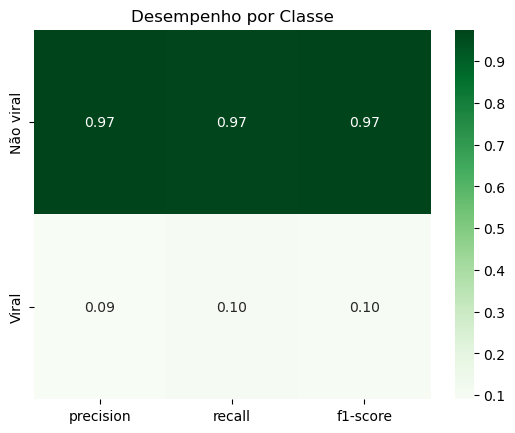


📌 Running Experiment 4/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config DT: balance=None, normalize=zscore, class_weight=balanced, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      0.97      0.97     16085
       Viral       0.08      0.08      0.08       448

    accuracy                           0.95     16533
   macro avg       0.53      0.53      0.53     16533
weighted avg       0.95      0.95      0.95     16533



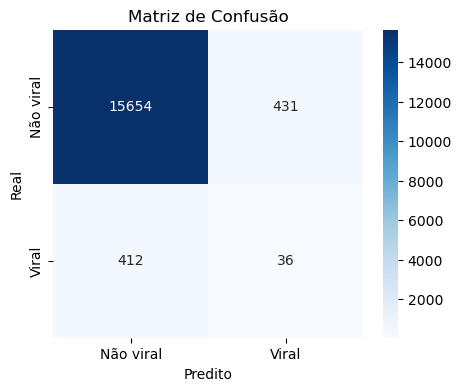

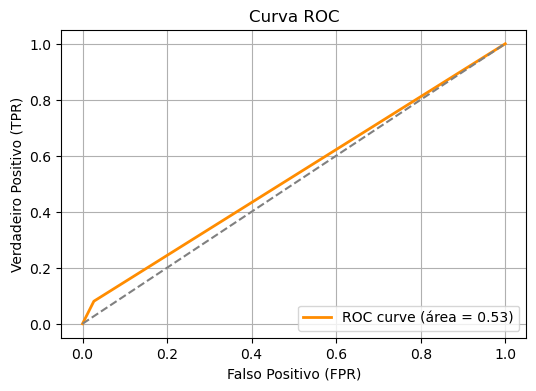

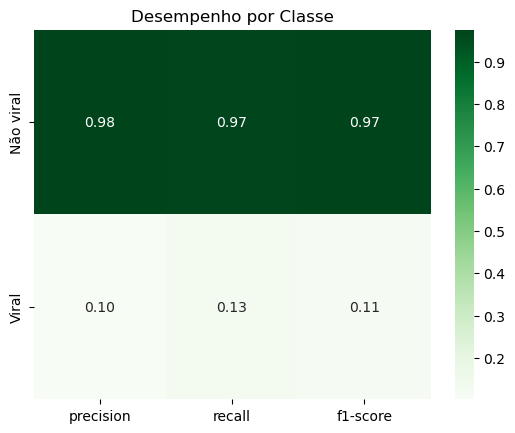


📌 Running Experiment 5/10
{'normalize': 'zscore', 'balance_strategy': 'smote', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=smote, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.93      0.95     16085
       Viral       0.07      0.19      0.11       448

    accuracy                           0.91     16533
   macro avg       0.52      0.56      0.53     16533
weighted avg       0.95      0.91      0.93     16533



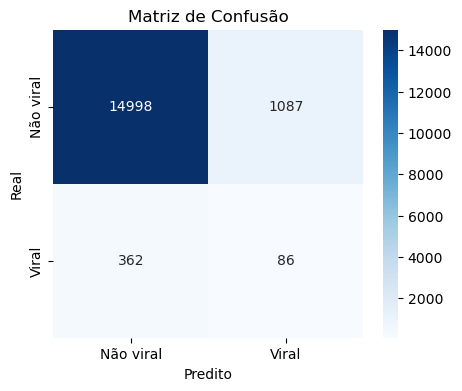

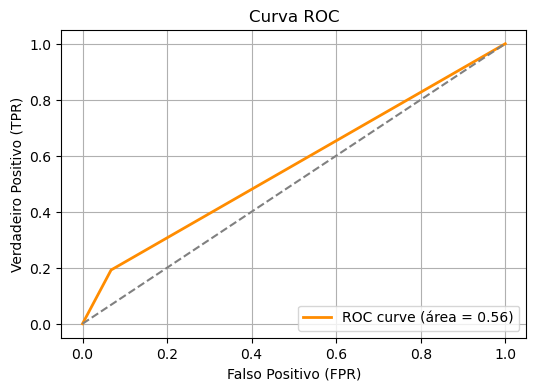

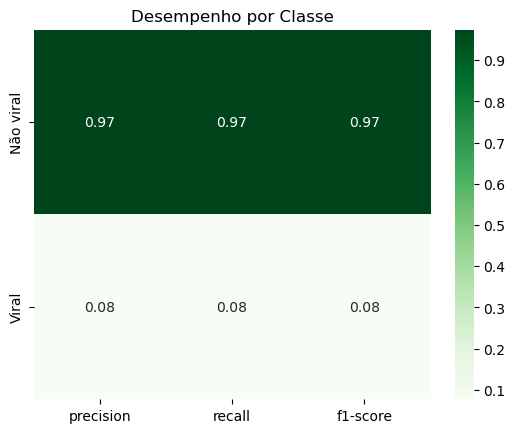


📌 Running Experiment 6/10
{'normalize': 'zscore', 'balance_strategy': 'ros', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=ros, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      0.97      0.97     16085
       Viral       0.08      0.08      0.08       448

    accuracy                           0.95     16533
   macro avg       0.53      0.53      0.53     16533
weighted avg       0.95      0.95      0.95     16533



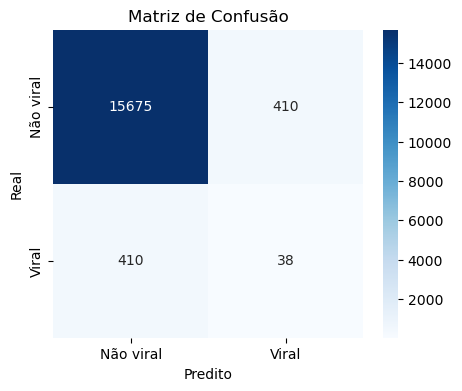

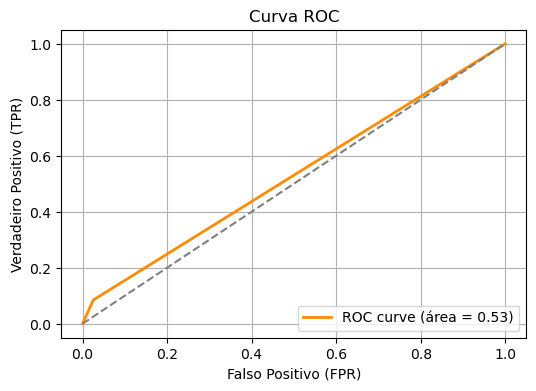

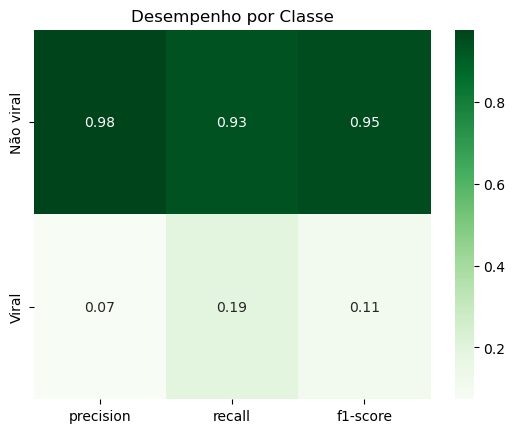


📌 Running Experiment 7/10
{'normalize': 'zscore', 'balance_strategy': 'rus', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=rus, normalize=zscore, class_weight=None, max_depth=None

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.68      0.80     16085
       Viral       0.05      0.61      0.09       448

    accuracy                           0.68     16533
   macro avg       0.52      0.65      0.45     16533
weighted avg       0.96      0.68      0.78     16533



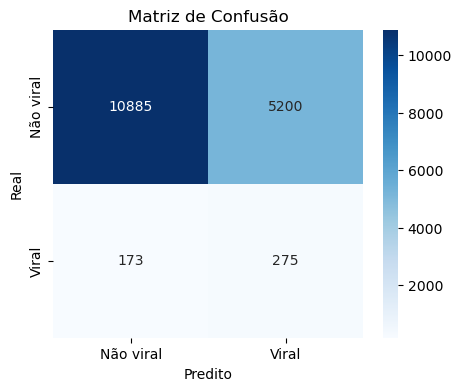

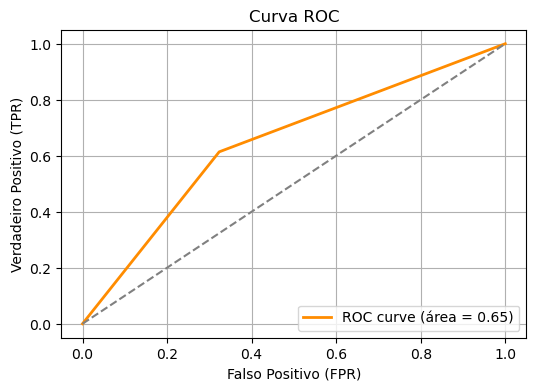

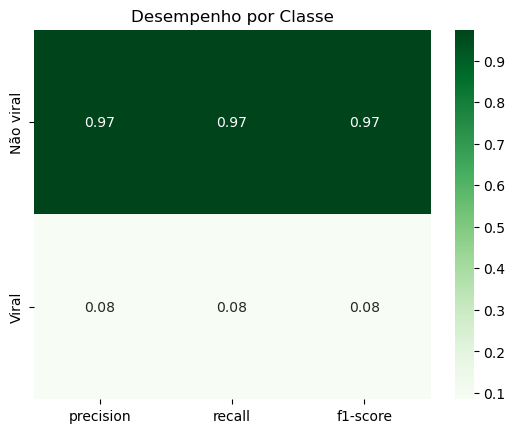


📌 Running Experiment 8/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 5, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=5

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.25      0.02      0.04       448

    accuracy                           0.97     16533
   macro avg       0.61      0.51      0.51     16533
weighted avg       0.95      0.97      0.96     16533



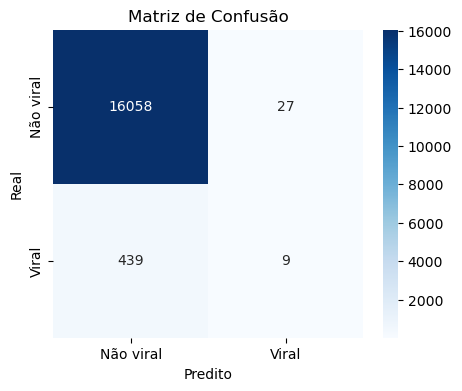

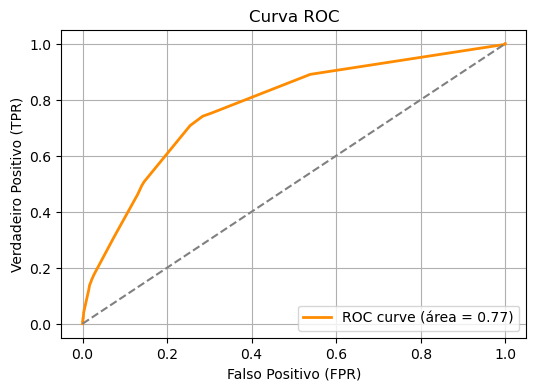

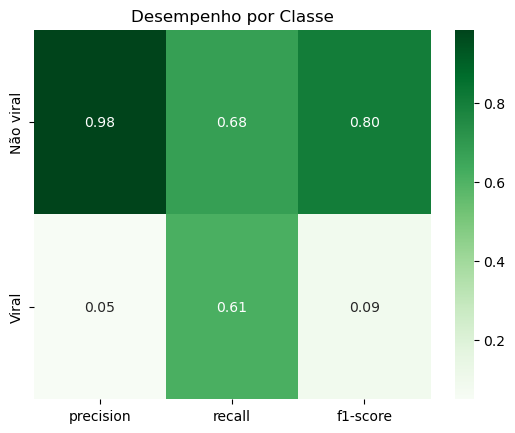


📌 Running Experiment 9/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 10, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=10

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.28      0.06      0.09       448

    accuracy                           0.97     16533
   macro avg       0.63      0.53      0.54     16533
weighted avg       0.96      0.97      0.96     16533



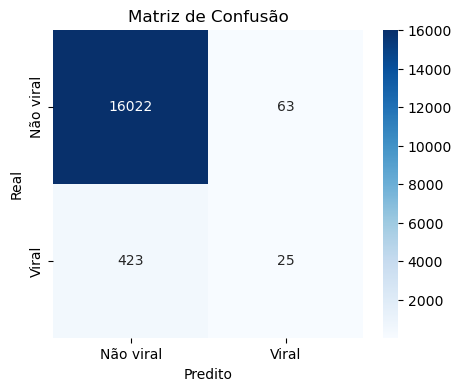

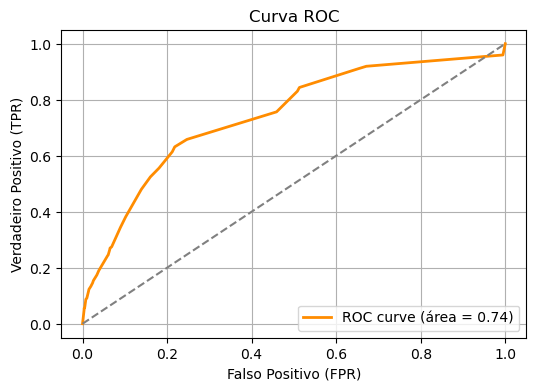

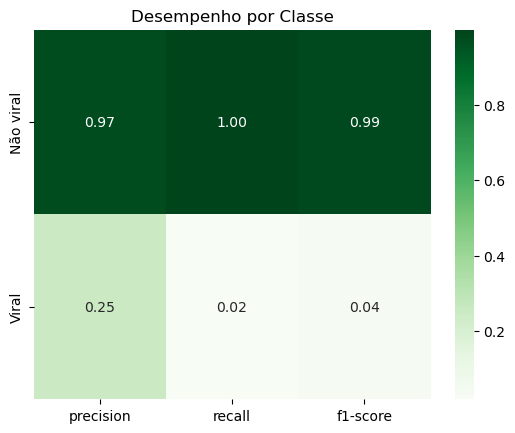


📌 Running Experiment 10/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 20, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=20

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.98      0.98     16085
       Viral       0.15      0.10      0.12       448

    accuracy                           0.96     16533
   macro avg       0.56      0.54      0.55     16533
weighted avg       0.95      0.96      0.96     16533



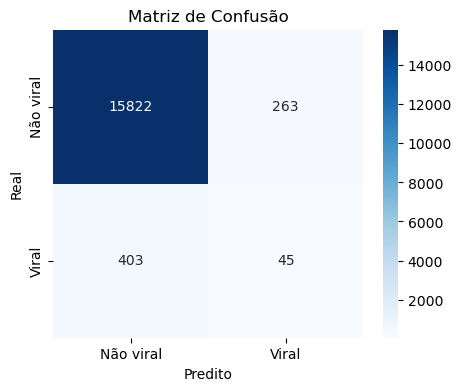

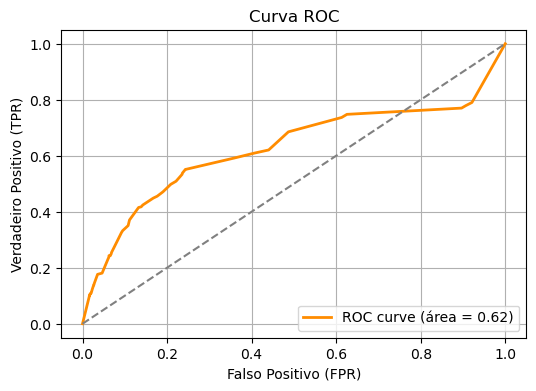

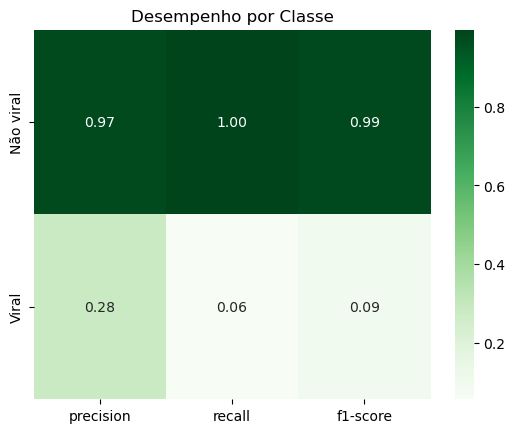

In [101]:
results_decision_tree_word2vec = []

for i, config in enumerate(dt_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(dt_experiment_configs)}")
    print(config)

    report_dict = run_decision_tree_experiment(
        X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results_decision_tree_word2vec.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

#### Ensemble

In [102]:
from sklearn.ensemble import RandomForestClassifier

def run_random_forest_experiment(
    X_train, X_test, y_train, y_test,
    balance_strategy=None,
    normalize=None,
    class_weight=None,
    n_estimators=100,
    max_depth=None,
    random_state=42,
    verbose=True
):
    print(f"\n🔧 Config RF: balance={balance_strategy}, normalize={normalize}, class_weight={class_weight}, n_estimators={n_estimators}")

    # Normalização e balanceamento idem acima
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if balance_strategy == "smote":
        sampler = SMOTE(random_state=random_state)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=random_state)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        sampler = None
    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight=class_weight,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    print("\n📊 Classification Report")
    print(classification_report(y_test, y_pred, target_names=["Não viral", "Viral"]))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Não viral", "Viral"], yticklabels=["Não viral", "Viral"])
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Plot curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Falso Positivo (FPR)")
    plt.ylabel("Verdadeiro Positivo (TPR)")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Plot métricas por classe
    df_plot = pd.DataFrame(report_dict).transpose().loc[["Não viral", "Viral"], ["precision", "recall", "f1-score"]]
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Greens")
    plt.title("Desempenho por Classe")
    plt.show()
    
    return classification_report(y_test, y_pred, target_names=["Não viral", "Viral"], output_dict=True)

In [103]:
rf_experiment_configs = [
    # Baseline
    {"normalize": None, "balance_strategy": None, "n_estimators": 100, "max_depth": None, "class_weight": None},

    # Variação de normalização
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": None, "class_weight": None},
    {"normalize": "minmax", "balance_strategy": None, "n_estimators": 100, "max_depth": None, "class_weight": None},

    # Class weighting
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": None, "class_weight": "balanced"},

    # Com balanceamento
    {"normalize": "zscore", "balance_strategy": "smote", "n_estimators": 100, "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "ros", "n_estimators": 100, "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "rus", "n_estimators": 100, "max_depth": None, "class_weight": None},

    # Variações de profundidade
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": 5, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": 10, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": 20, "class_weight": None},

    # Variação no número de estimadores
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 50, "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 200, "max_depth": None, "class_weight": None},
]

##### TF-IDF


📌 Running Experiment 1/12
{'normalize': None, 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=None, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.58      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.78      0.52      0.52     16533
weighted avg       0.96      0.97      0.96     16533



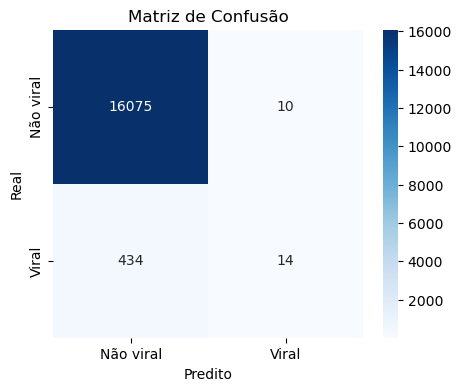

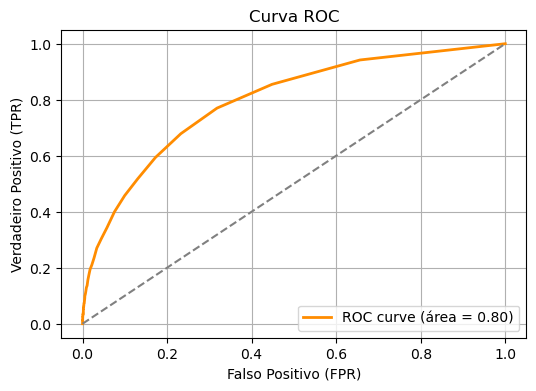

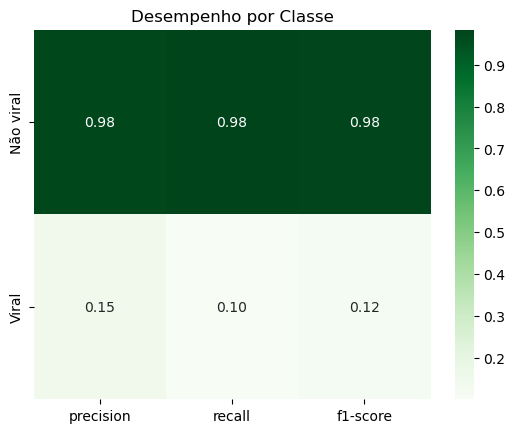


📌 Running Experiment 2/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.54      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.76      0.51      0.52     16533
weighted avg       0.96      0.97      0.96     16533



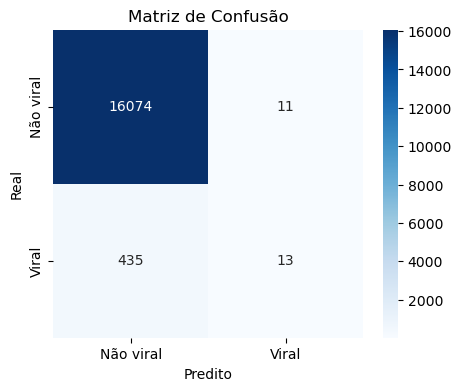

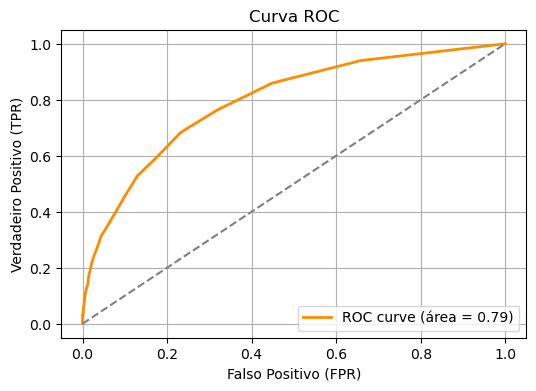

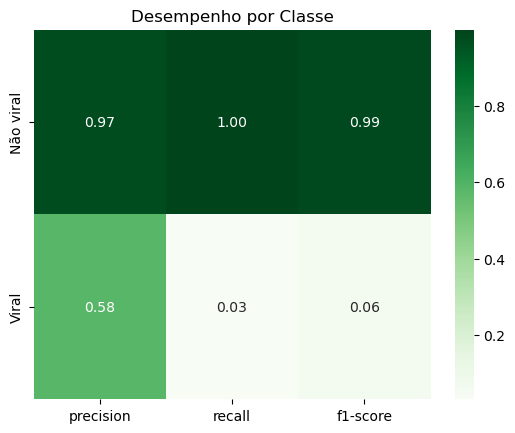


📌 Running Experiment 3/12
{'normalize': 'minmax', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=minmax, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.62      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.80      0.52      0.52     16533
weighted avg       0.96      0.97      0.96     16533



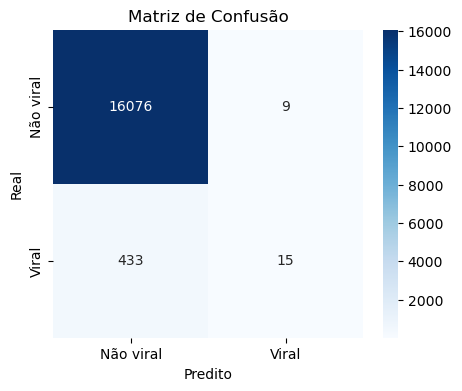

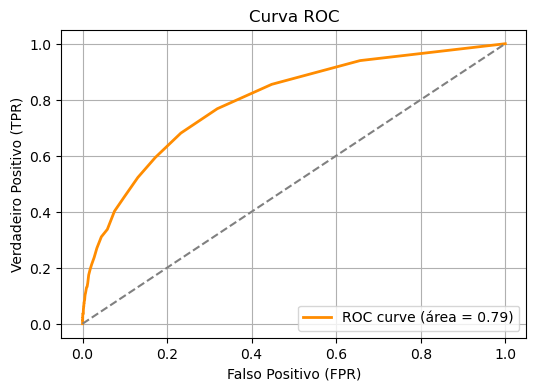

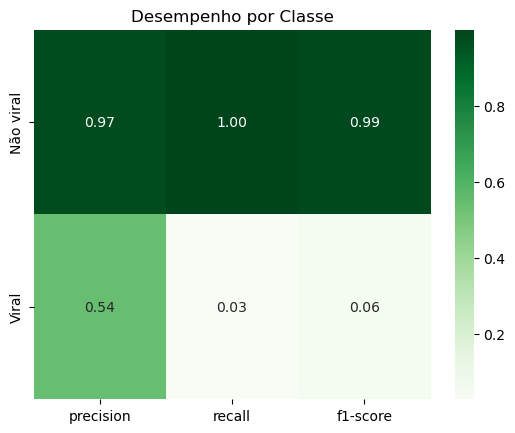


📌 Running Experiment 4/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config RF: balance=None, normalize=zscore, class_weight=balanced, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.46      0.03      0.05       448

    accuracy                           0.97     16533
   macro avg       0.72      0.51      0.52     16533
weighted avg       0.96      0.97      0.96     16533



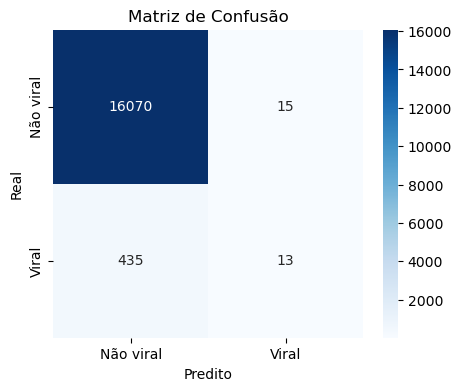

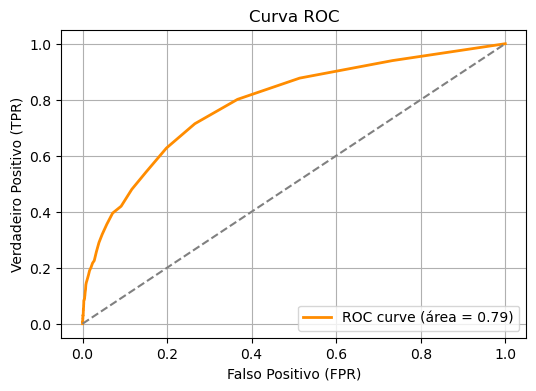

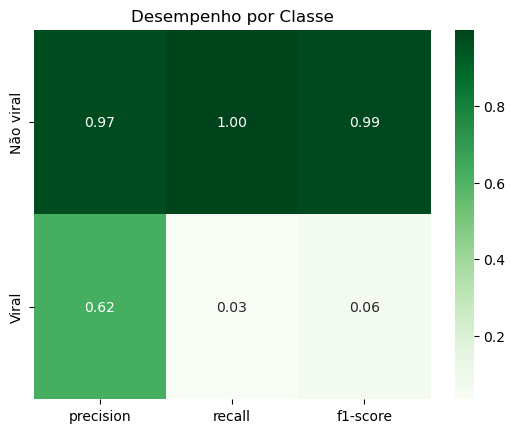


📌 Running Experiment 5/12
{'normalize': 'zscore', 'balance_strategy': 'smote', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=smote, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.33      0.08      0.12       448

    accuracy                           0.97     16533
   macro avg       0.65      0.54      0.55     16533
weighted avg       0.96      0.97      0.96     16533



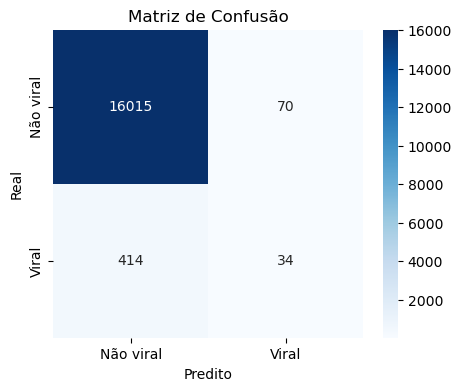

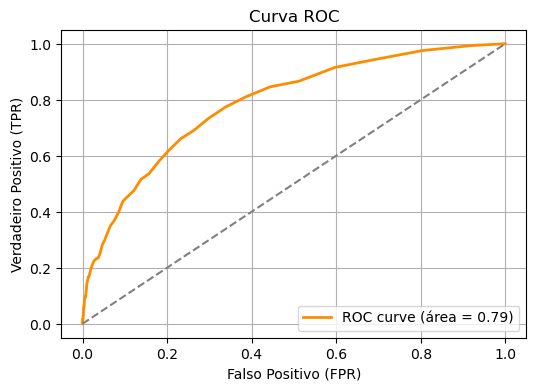

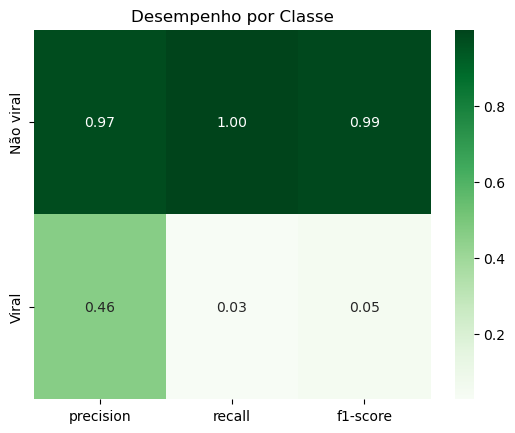


📌 Running Experiment 6/12
{'normalize': 'zscore', 'balance_strategy': 'ros', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=ros, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.38      0.05      0.09       448

    accuracy                           0.97     16533
   macro avg       0.68      0.52      0.54     16533
weighted avg       0.96      0.97      0.96     16533



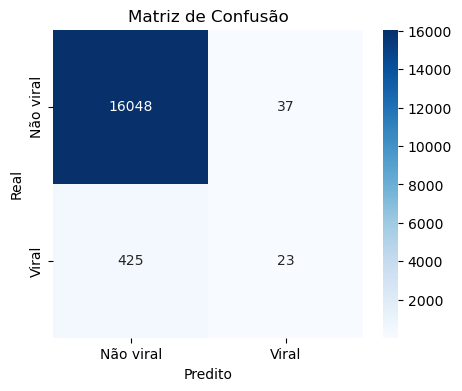

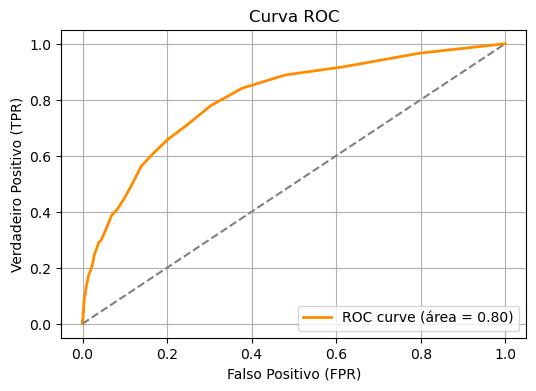

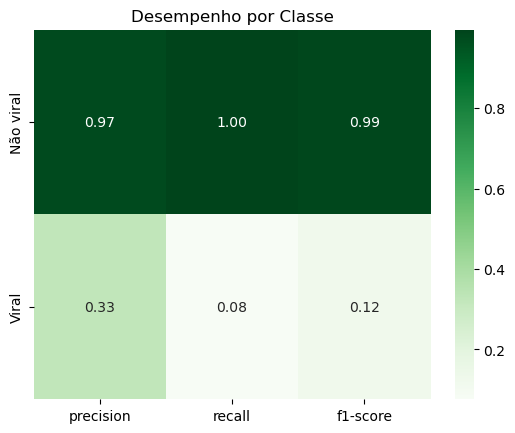


📌 Running Experiment 7/12
{'normalize': 'zscore', 'balance_strategy': 'rus', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=rus, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.71      0.83     16085
       Viral       0.07      0.78      0.13       448

    accuracy                           0.71     16533
   macro avg       0.53      0.75      0.48     16533
weighted avg       0.97      0.71      0.81     16533



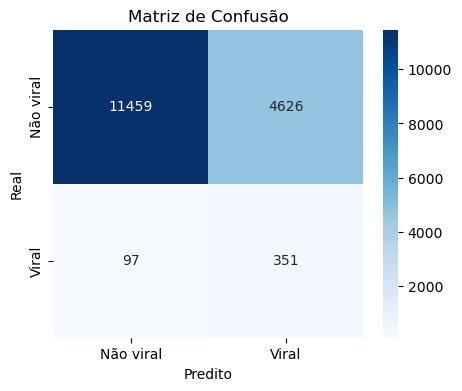

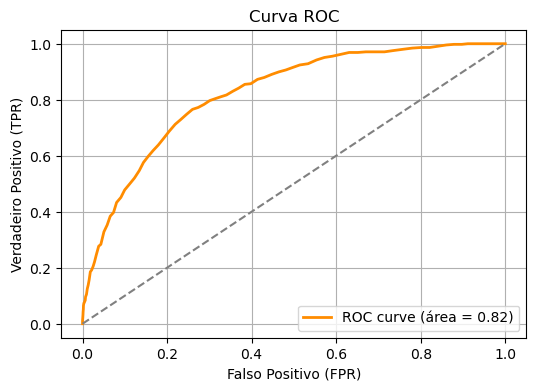

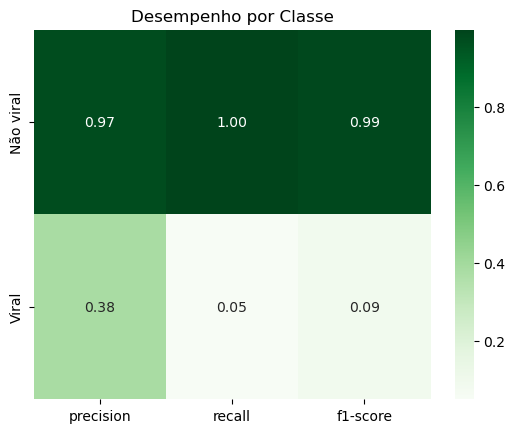


📌 Running Experiment 8/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 5, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.00      0.00      0.00       448

    accuracy                           0.97     16533
   macro avg       0.49      0.50      0.49     16533
weighted avg       0.95      0.97      0.96     16533



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


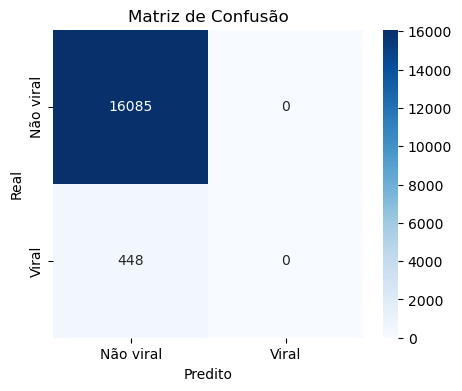

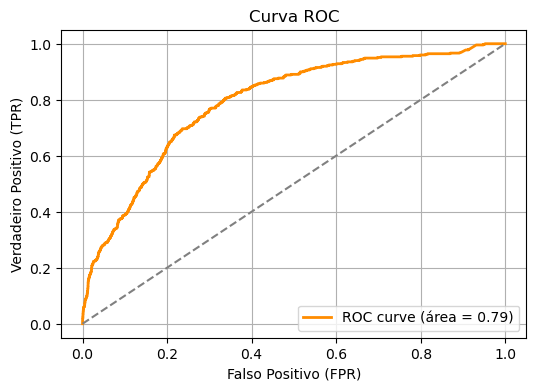

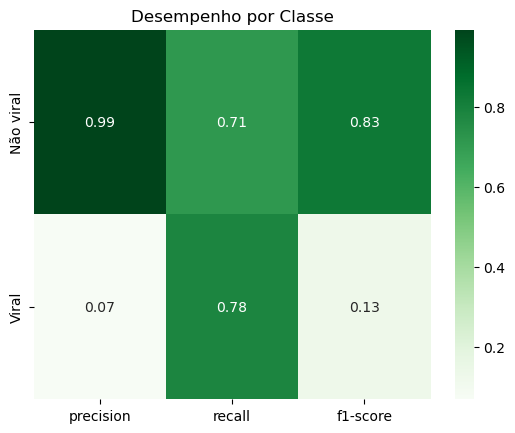

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📌 Running Experiment 9/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 10, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       1.00      0.01      0.02       448

    accuracy                           0.97     16533
   macro avg       0.99      0.51      0.50     16533
weighted avg       0.97      0.97      0.96     16533



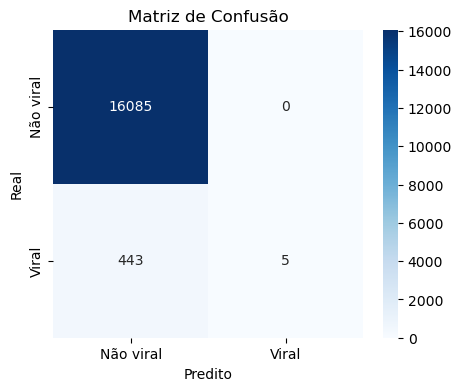

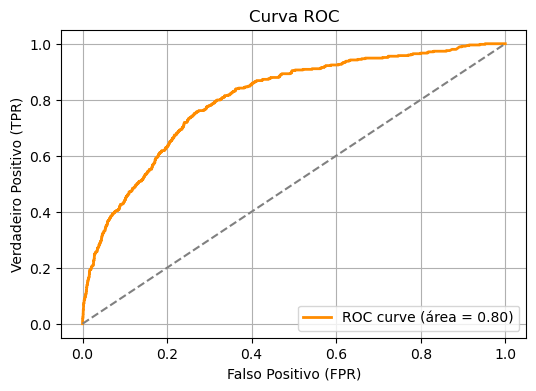

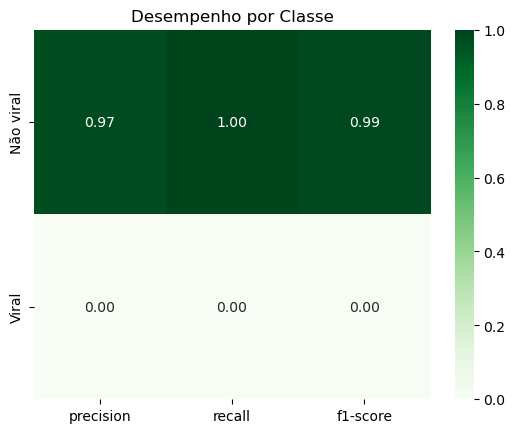


📌 Running Experiment 10/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 20, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.62      0.02      0.03       448

    accuracy                           0.97     16533
   macro avg       0.79      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



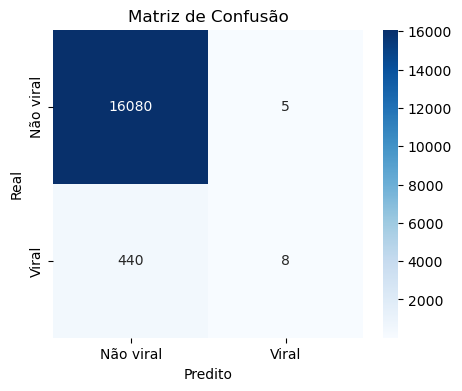

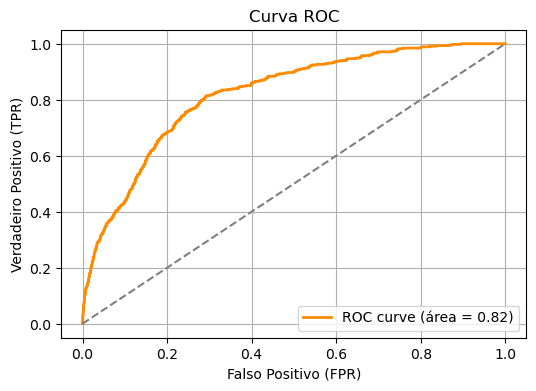

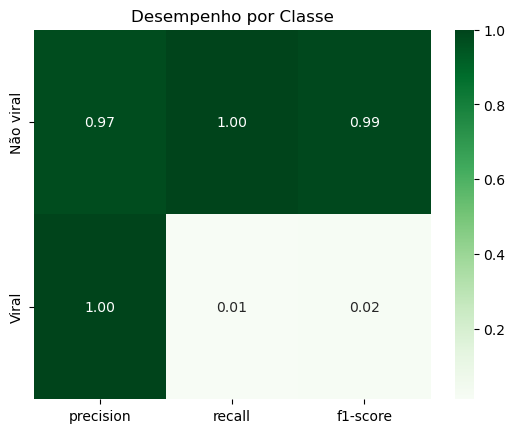


📌 Running Experiment 11/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 50, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=50

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.59      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.78      0.51      0.52     16533
weighted avg       0.96      0.97      0.96     16533



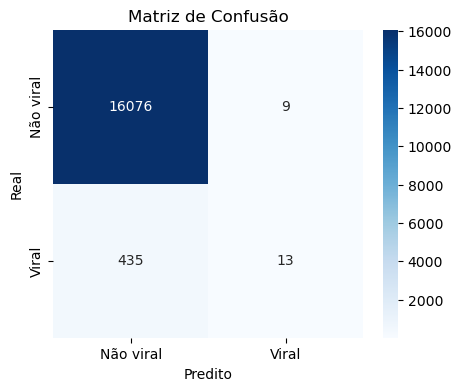

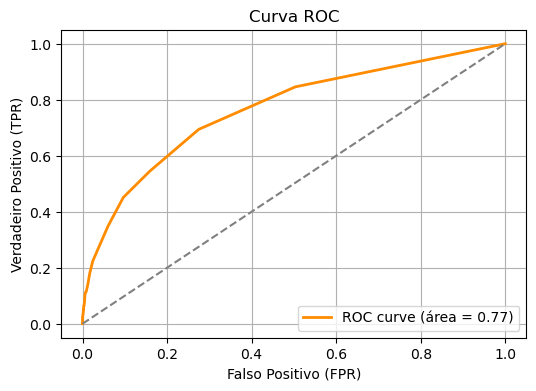

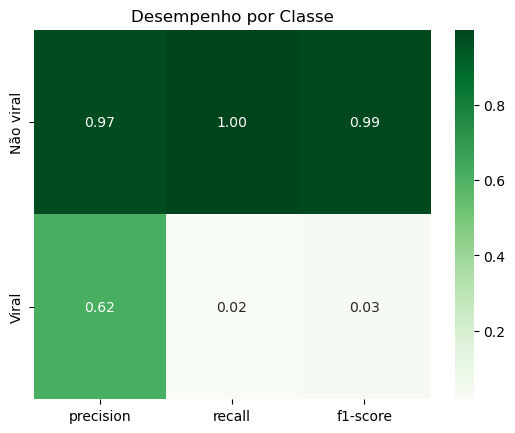


📌 Running Experiment 12/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 200, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=200

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.52      0.03      0.05       448

    accuracy                           0.97     16533
   macro avg       0.75      0.51      0.52     16533
weighted avg       0.96      0.97      0.96     16533



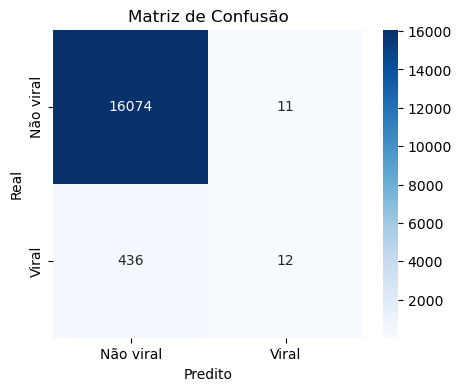

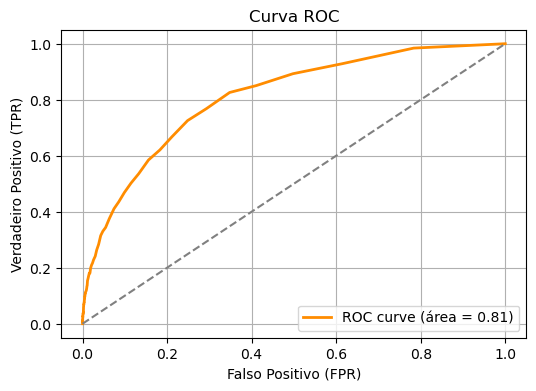

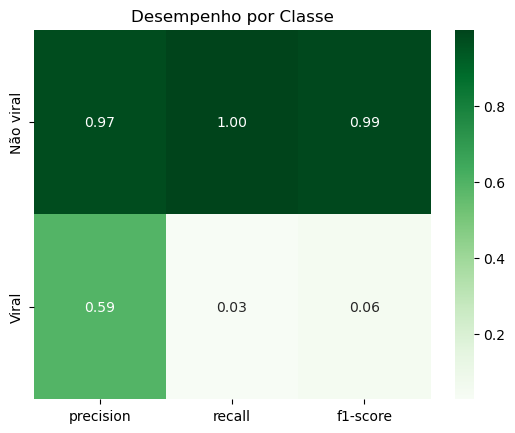

In [104]:
results_ensemble_tfidf = []

for i, config in enumerate(rf_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(rf_experiment_configs)}")
    print(config)

    report_dict = run_random_forest_experiment(
        X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results_ensemble_tfidf.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### BOW


📌 Running Experiment 1/12
{'normalize': None, 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=None, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.45      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.71      0.52      0.52     16533
weighted avg       0.96      0.97      0.96     16533



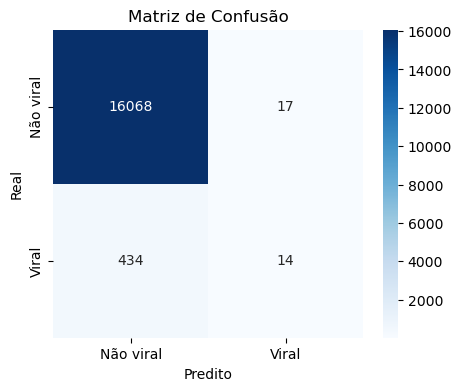

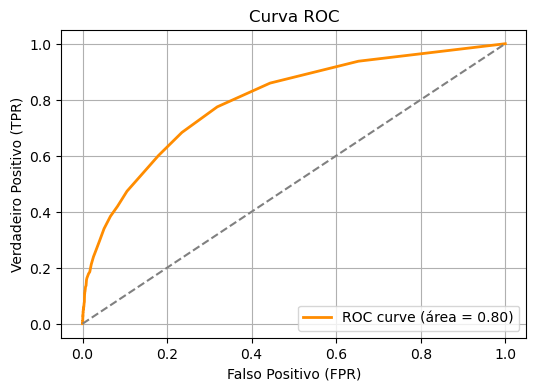

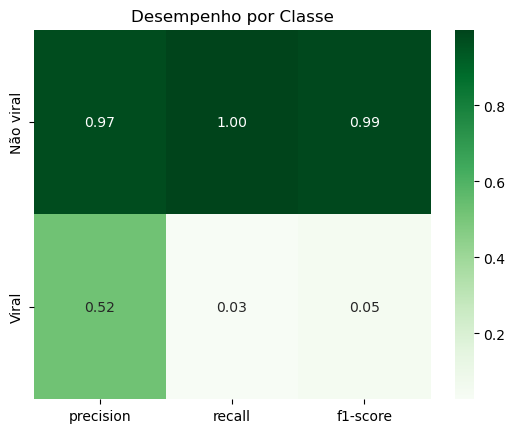


📌 Running Experiment 2/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.48      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.73      0.52      0.52     16533
weighted avg       0.96      0.97      0.96     16533



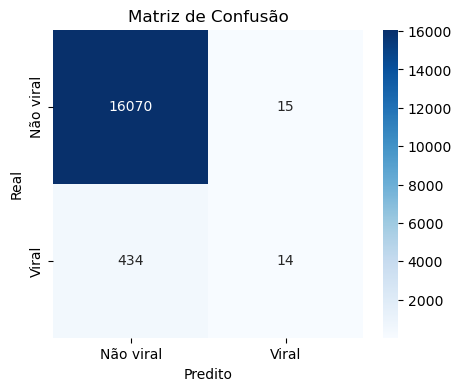

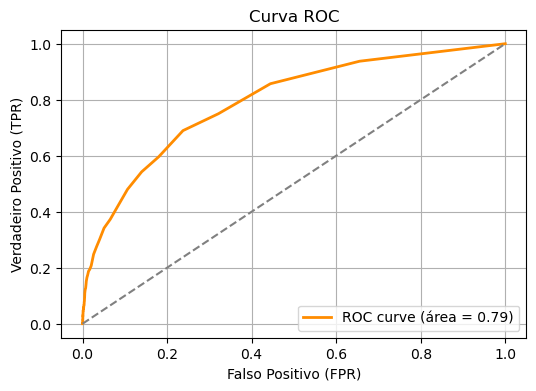

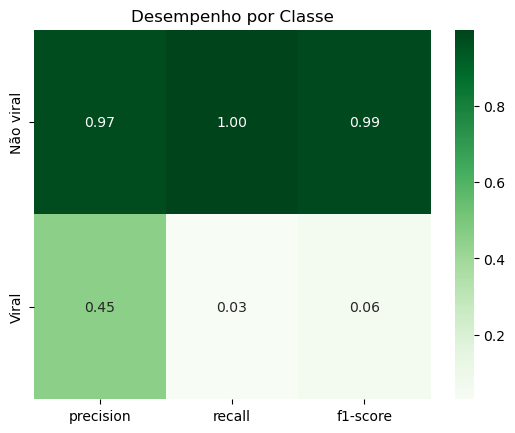


📌 Running Experiment 3/12
{'normalize': 'minmax', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=minmax, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.48      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.73      0.52      0.52     16533
weighted avg       0.96      0.97      0.96     16533



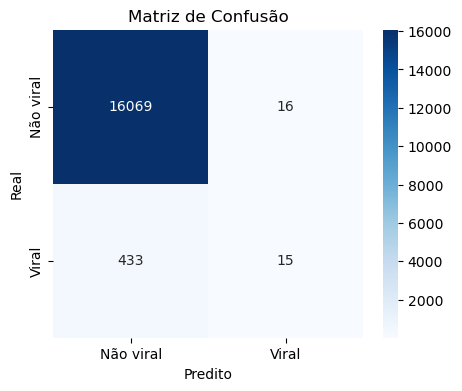

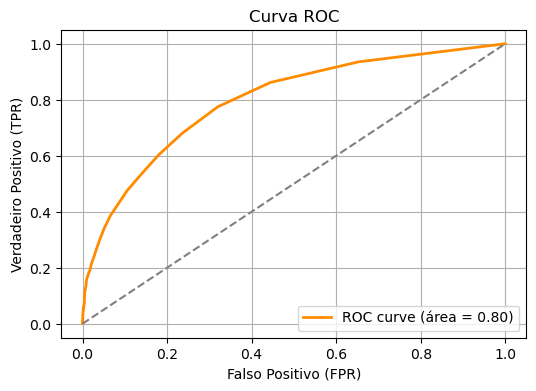

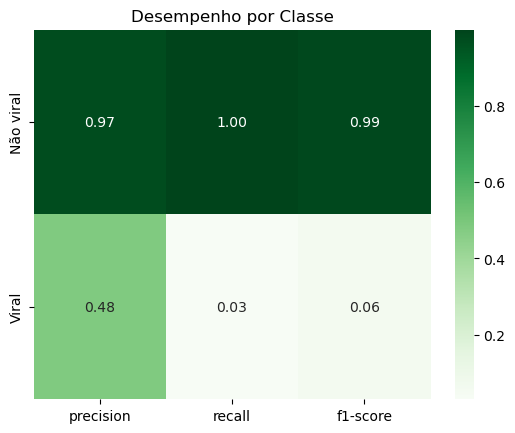


📌 Running Experiment 4/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config RF: balance=None, normalize=zscore, class_weight=balanced, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.52      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.75      0.52      0.52     16533
weighted avg       0.96      0.97      0.96     16533



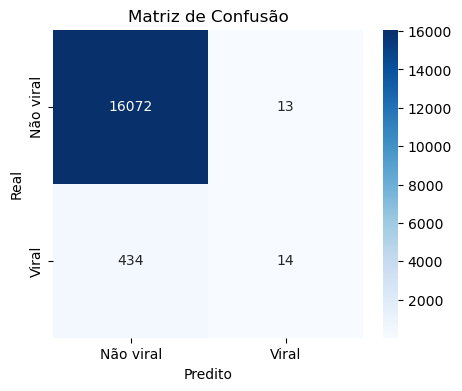

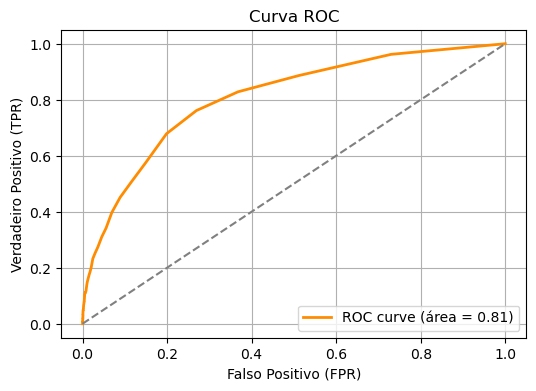

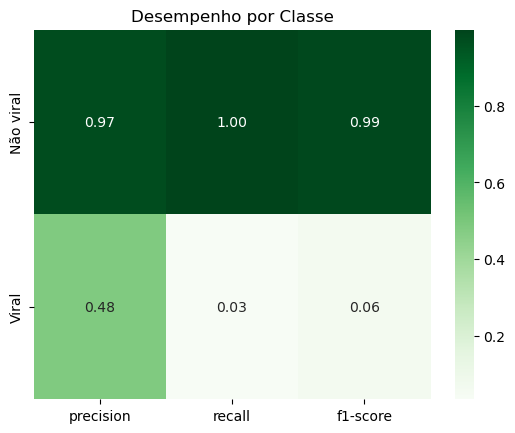


📌 Running Experiment 5/12
{'normalize': 'zscore', 'balance_strategy': 'smote', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=smote, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.34      0.04      0.08       448

    accuracy                           0.97     16533
   macro avg       0.66      0.52      0.53     16533
weighted avg       0.96      0.97      0.96     16533



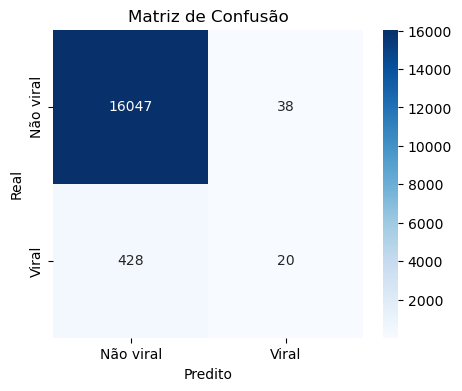

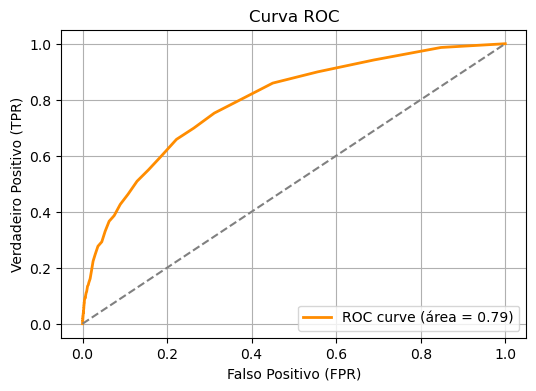

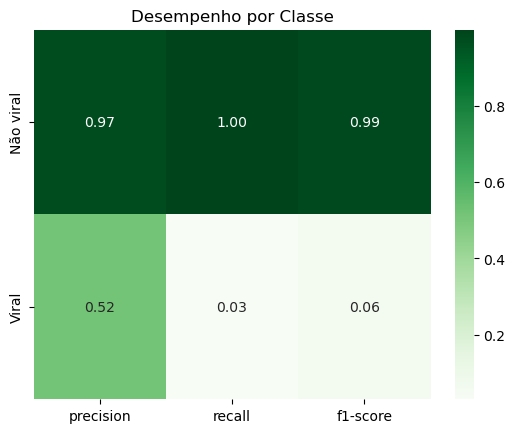


📌 Running Experiment 6/12
{'normalize': 'zscore', 'balance_strategy': 'ros', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=ros, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.45      0.07      0.12       448

    accuracy                           0.97     16533
   macro avg       0.71      0.53      0.55     16533
weighted avg       0.96      0.97      0.96     16533



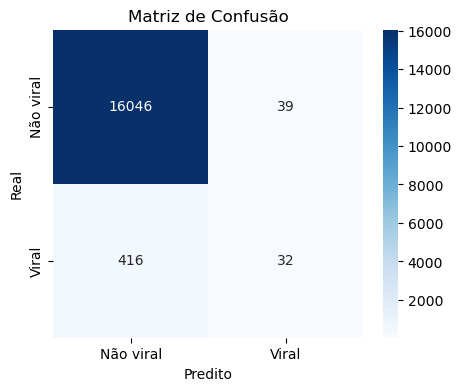

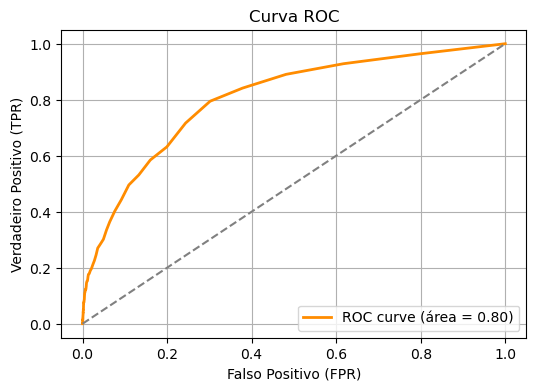

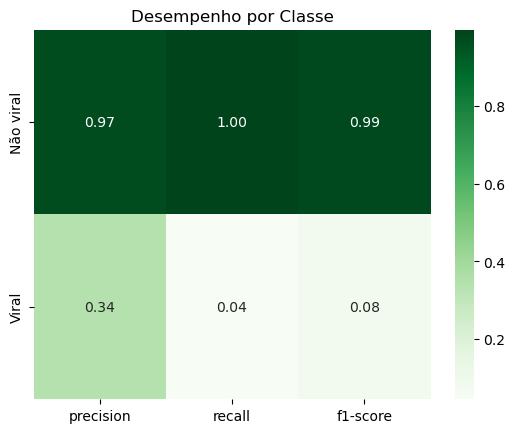


📌 Running Experiment 7/12
{'normalize': 'zscore', 'balance_strategy': 'rus', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=rus, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.71      0.83     16085
       Viral       0.07      0.78      0.13       448

    accuracy                           0.71     16533
   macro avg       0.53      0.75      0.48     16533
weighted avg       0.97      0.71      0.81     16533



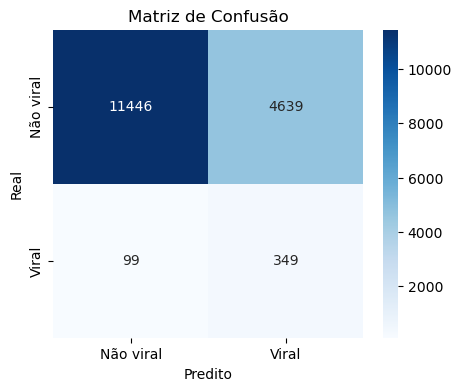

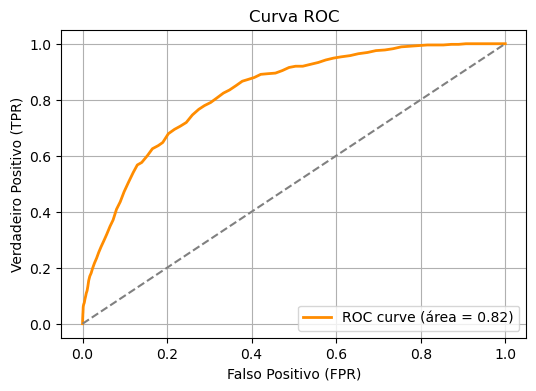

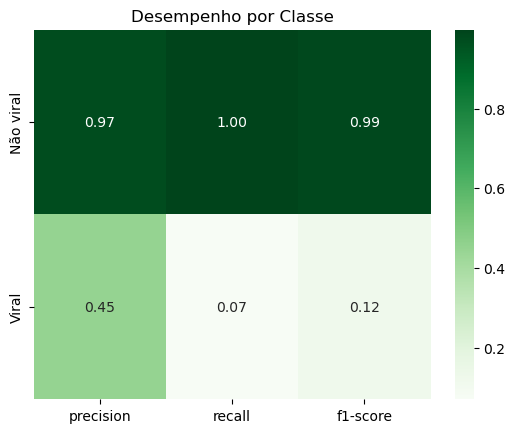


📌 Running Experiment 8/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 5, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.00      0.00      0.00       448

    accuracy                           0.97     16533
   macro avg       0.49      0.50      0.49     16533
weighted avg       0.95      0.97      0.96     16533



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


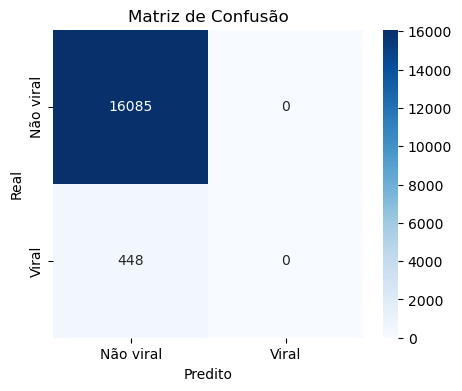

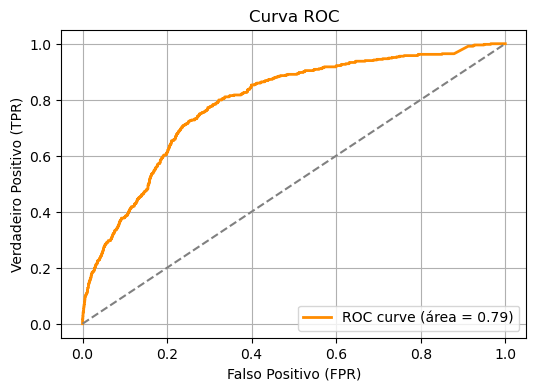

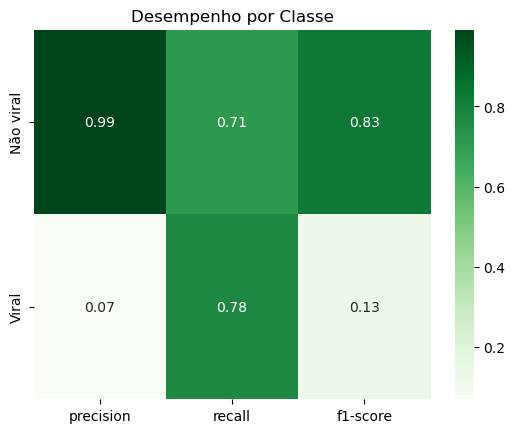

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📌 Running Experiment 9/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 10, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.00      0.00      0.00       448

    accuracy                           0.97     16533
   macro avg       0.49      0.50      0.49     16533
weighted avg       0.95      0.97      0.96     16533



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


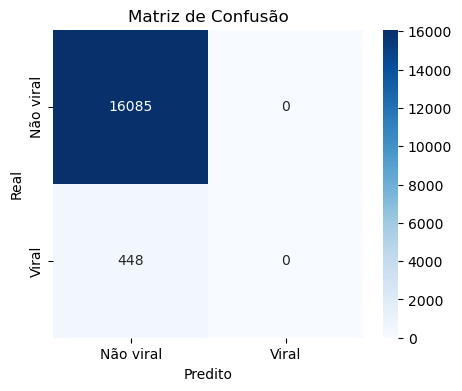

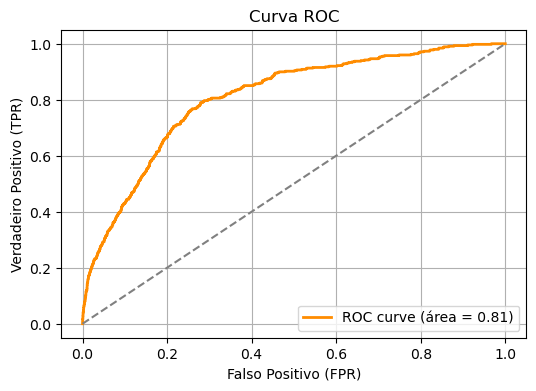

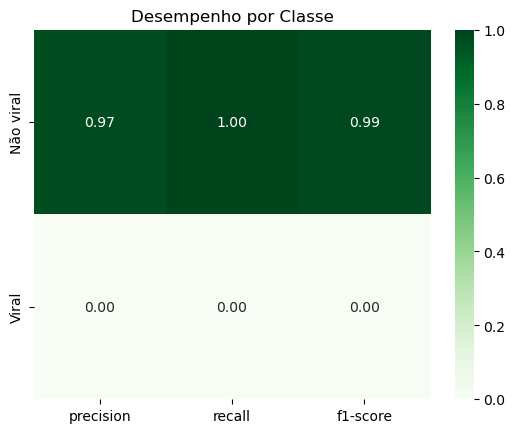

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📌 Running Experiment 10/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 20, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.43      0.02      0.04       448

    accuracy                           0.97     16533
   macro avg       0.70      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



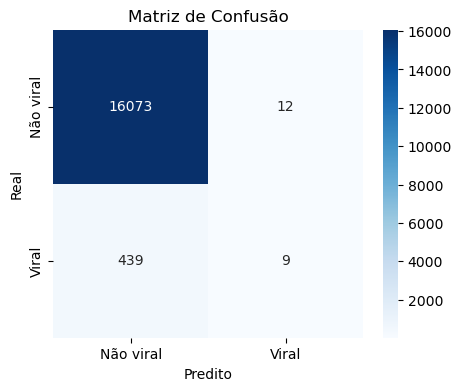

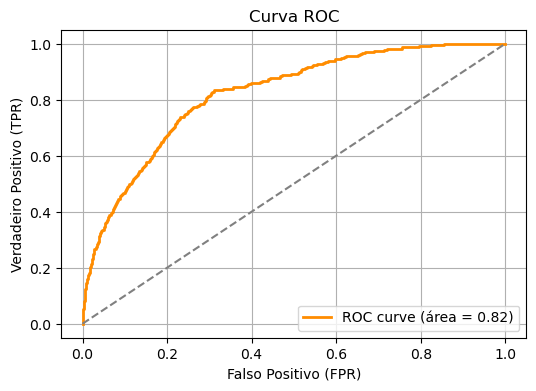

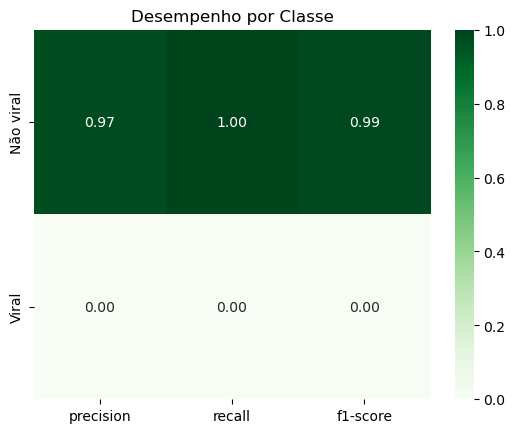


📌 Running Experiment 11/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 50, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=50

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.50      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.74      0.52      0.52     16533
weighted avg       0.96      0.97      0.96     16533



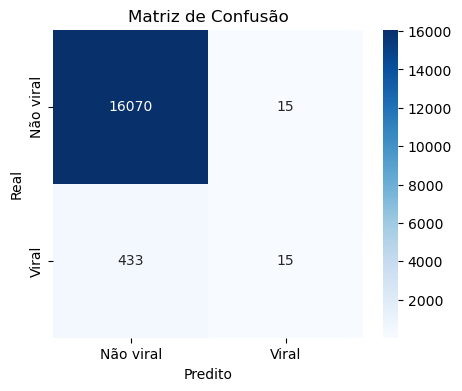

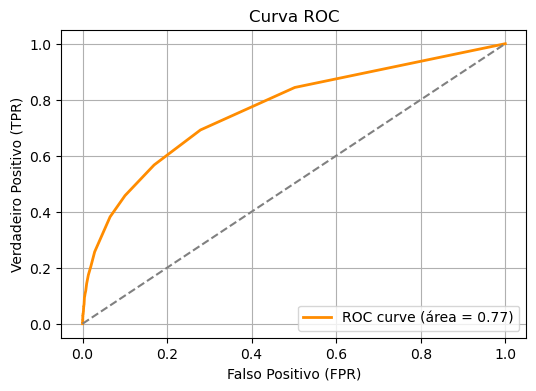

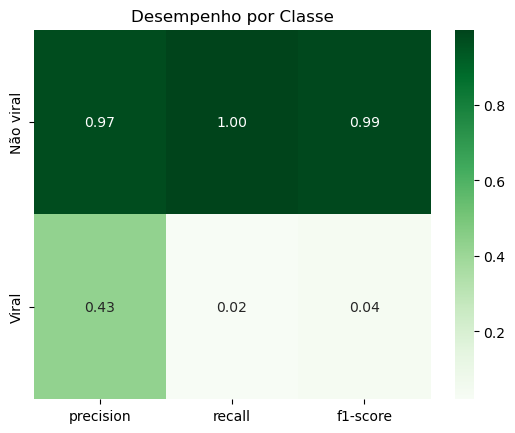


📌 Running Experiment 12/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 200, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=200

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.52      0.04      0.07       448

    accuracy                           0.97     16533
   macro avg       0.74      0.52      0.53     16533
weighted avg       0.96      0.97      0.96     16533



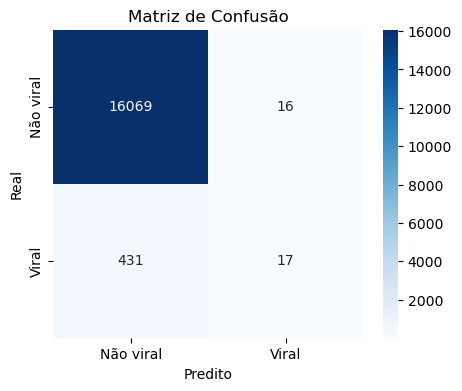

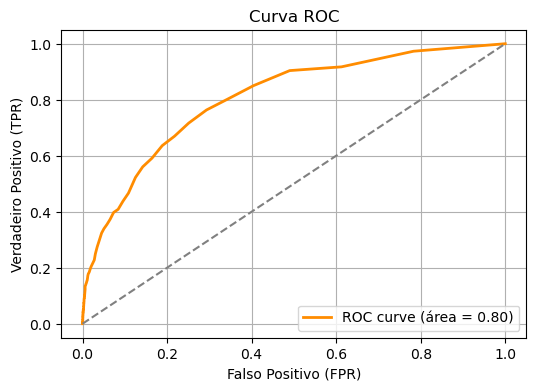

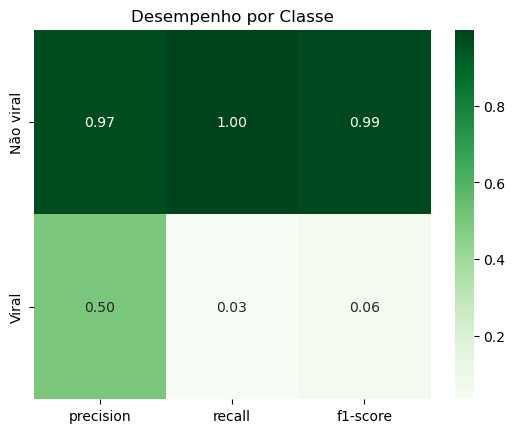

In [105]:
results_ensemble_bow = []

for i, config in enumerate(rf_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(rf_experiment_configs)}")
    print(config)

    report_dict = run_random_forest_experiment(
        X_bow_train, X_bow_test, y_bow_train, y_bow_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results_ensemble_bow.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### Word2Vec


📌 Running Experiment 1/12
{'normalize': None, 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=None, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.54      0.02      0.03       448

    accuracy                           0.97     16533
   macro avg       0.76      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



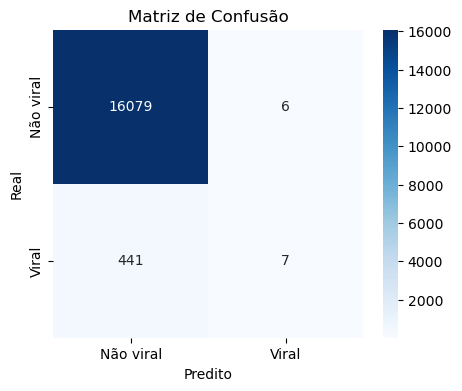

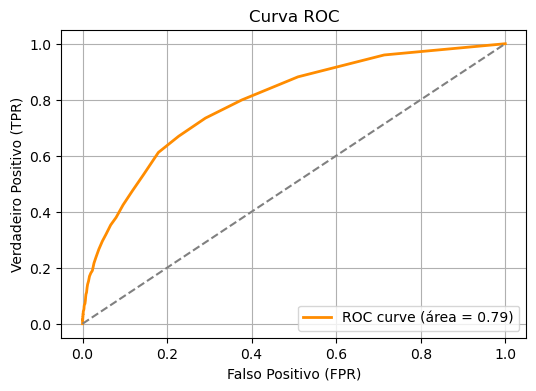

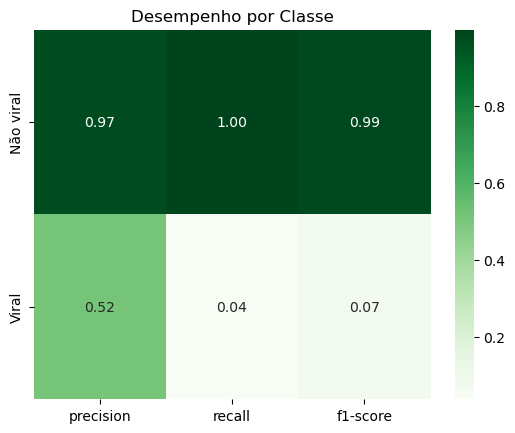


📌 Running Experiment 2/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.44      0.02      0.03       448

    accuracy                           0.97     16533
   macro avg       0.71      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



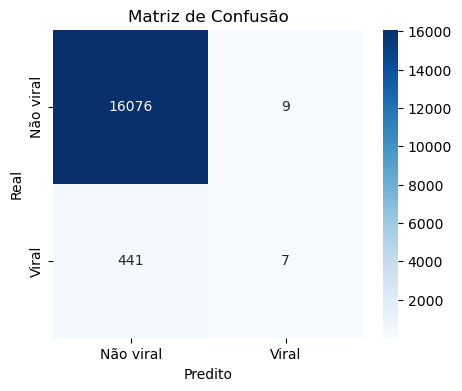

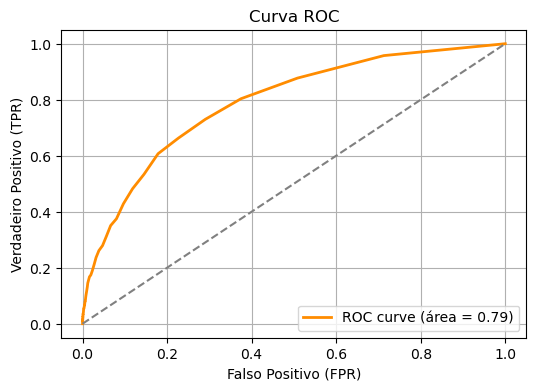

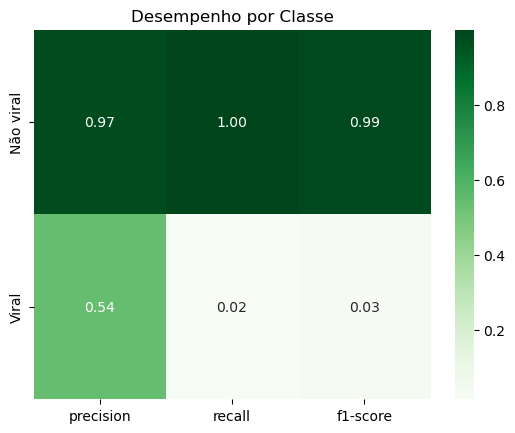


📌 Running Experiment 3/12
{'normalize': 'minmax', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=minmax, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.50      0.02      0.03       448

    accuracy                           0.97     16533
   macro avg       0.74      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



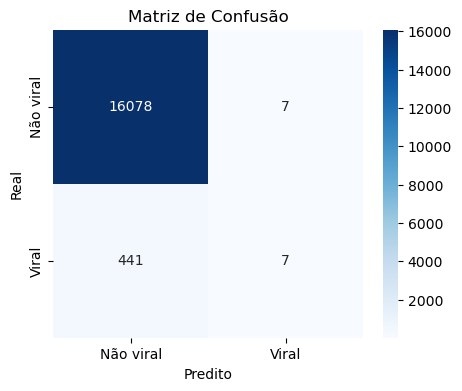

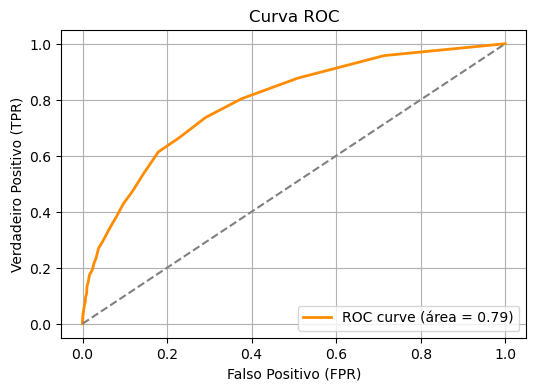

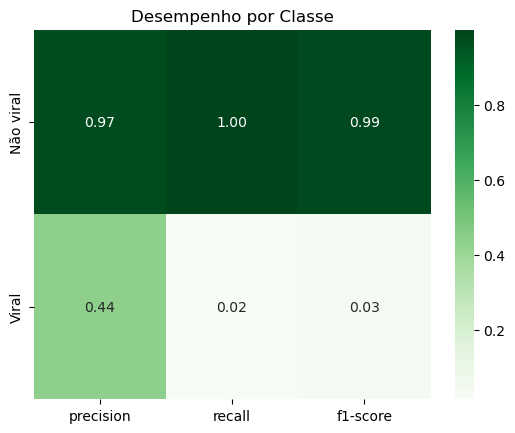


📌 Running Experiment 4/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config RF: balance=None, normalize=zscore, class_weight=balanced, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.50      0.01      0.03       448

    accuracy                           0.97     16533
   macro avg       0.74      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



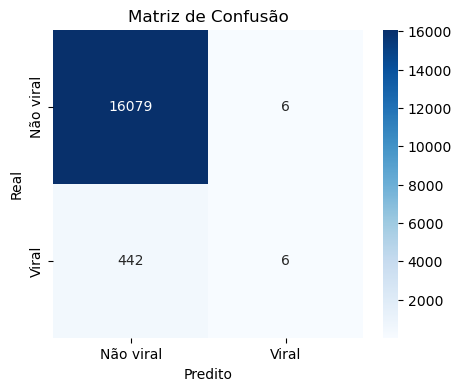

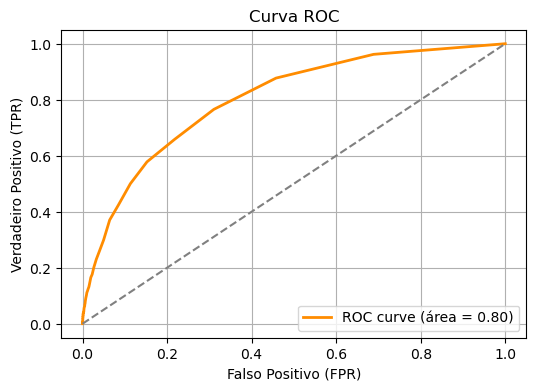

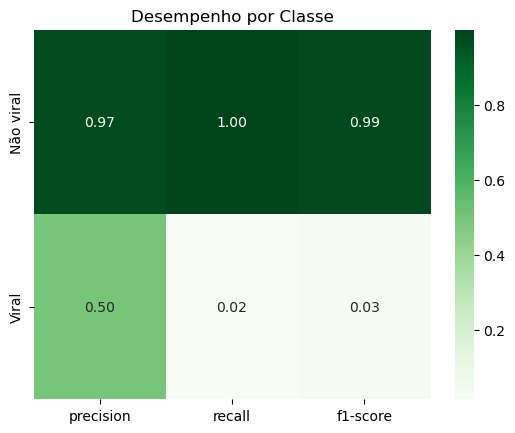


📌 Running Experiment 5/12
{'normalize': 'zscore', 'balance_strategy': 'smote', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=smote, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.98      0.99      0.98     16085
       Viral       0.21      0.14      0.17       448

    accuracy                           0.96     16533
   macro avg       0.59      0.56      0.57     16533
weighted avg       0.96      0.96      0.96     16533



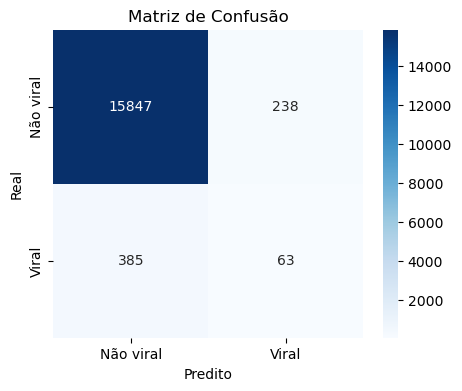

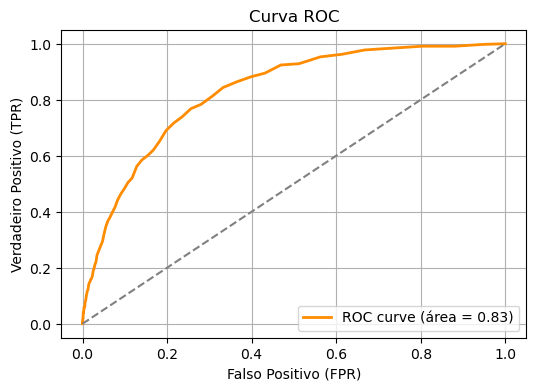

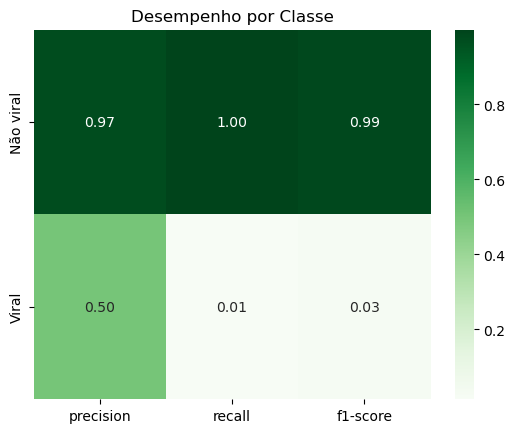


📌 Running Experiment 6/12
{'normalize': 'zscore', 'balance_strategy': 'ros', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=ros, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.35      0.03      0.06       448

    accuracy                           0.97     16533
   macro avg       0.66      0.51      0.52     16533
weighted avg       0.96      0.97      0.96     16533



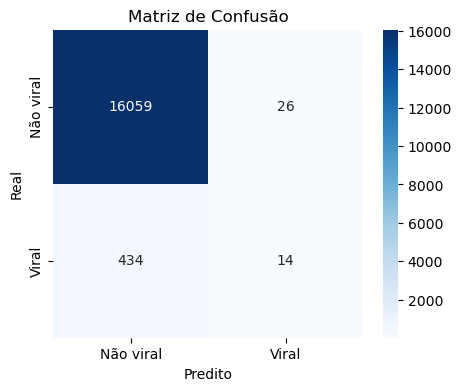

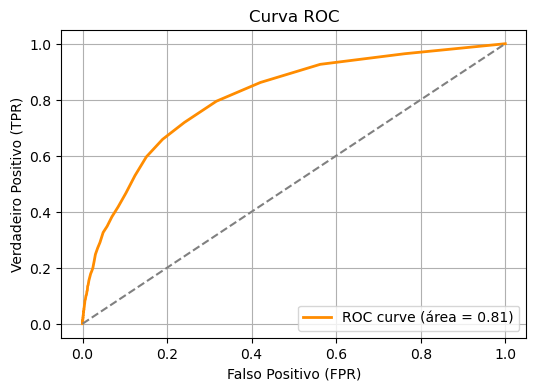

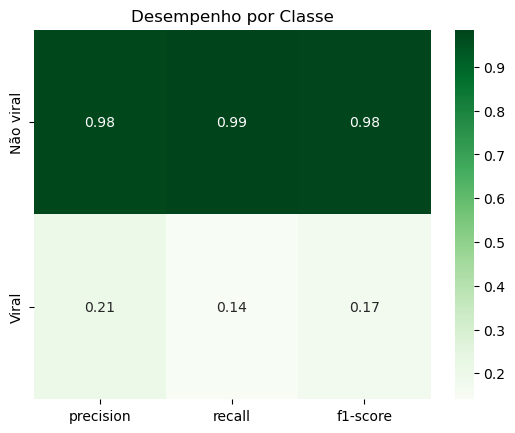


📌 Running Experiment 7/12
{'normalize': 'zscore', 'balance_strategy': 'rus', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=rus, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.99      0.73      0.84     16085
       Viral       0.07      0.76      0.13       448

    accuracy                           0.73     16533
   macro avg       0.53      0.74      0.48     16533
weighted avg       0.97      0.73      0.82     16533



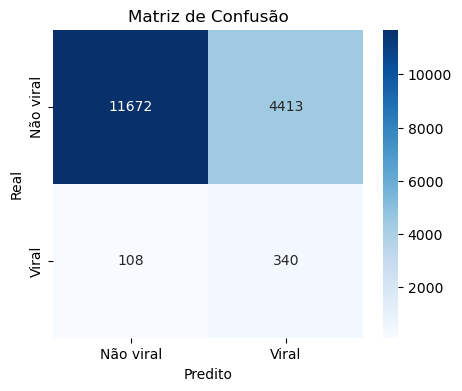

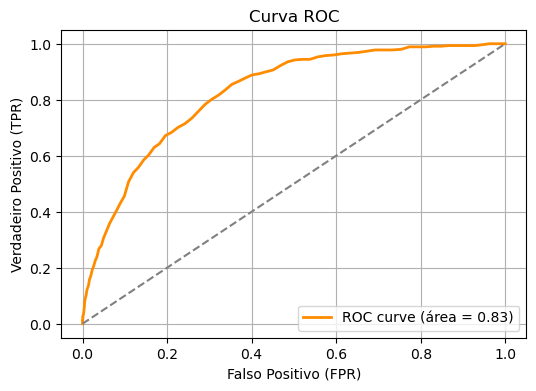

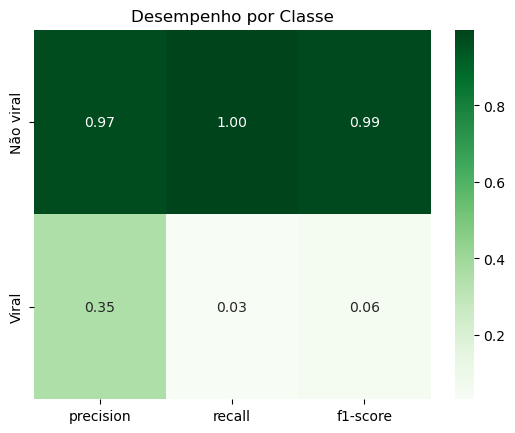


📌 Running Experiment 8/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 5, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.00      0.00      0.00       448

    accuracy                           0.97     16533
   macro avg       0.49      0.50      0.49     16533
weighted avg       0.95      0.97      0.96     16533



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


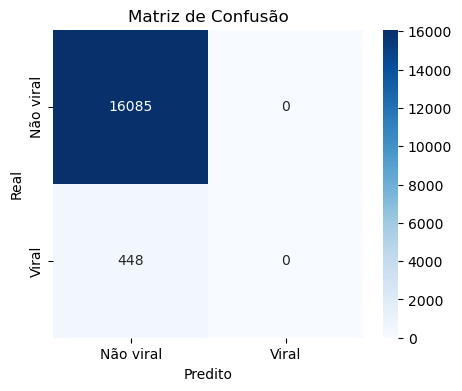

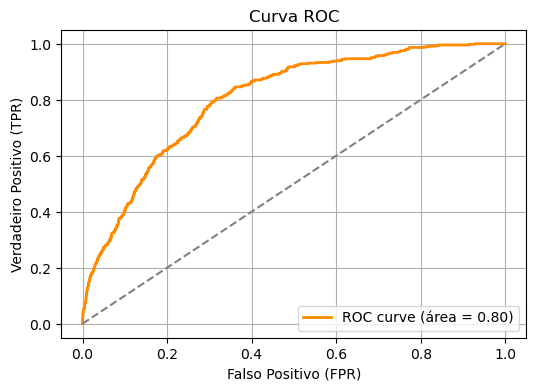

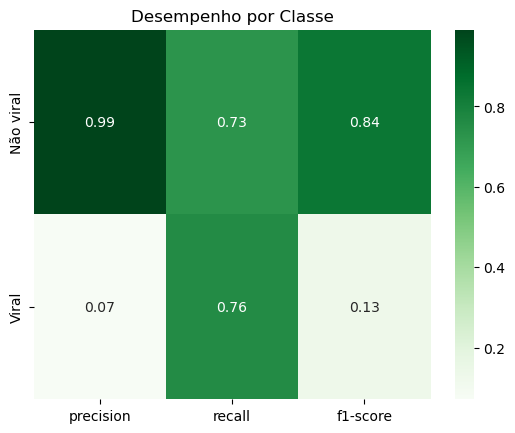

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📌 Running Experiment 9/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 10, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.50      0.01      0.01       448

    accuracy                           0.97     16533
   macro avg       0.74      0.50      0.50     16533
weighted avg       0.96      0.97      0.96     16533



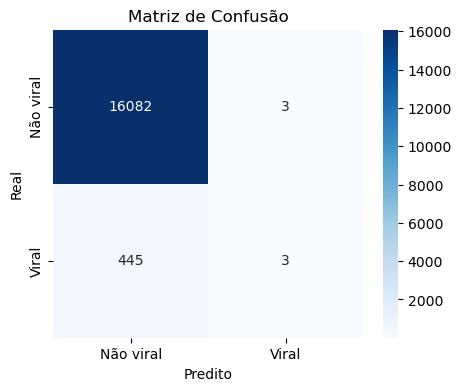

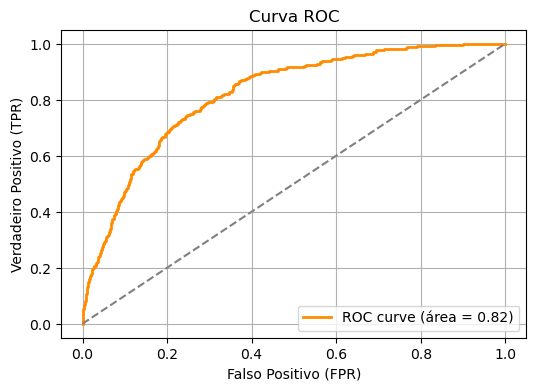

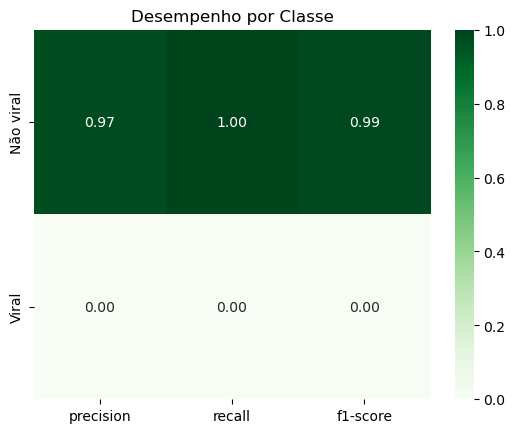


📌 Running Experiment 10/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 20, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.73      0.02      0.03       448

    accuracy                           0.97     16533
   macro avg       0.85      0.51      0.51     16533
weighted avg       0.97      0.97      0.96     16533



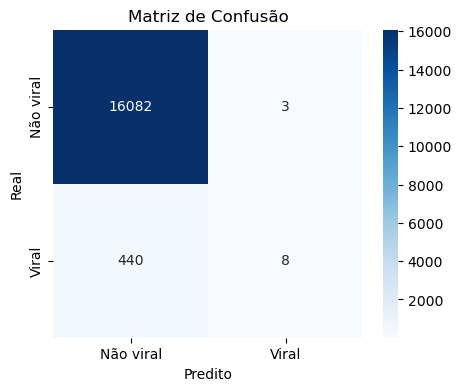

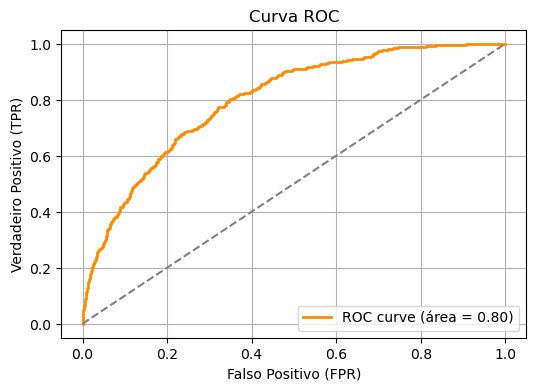

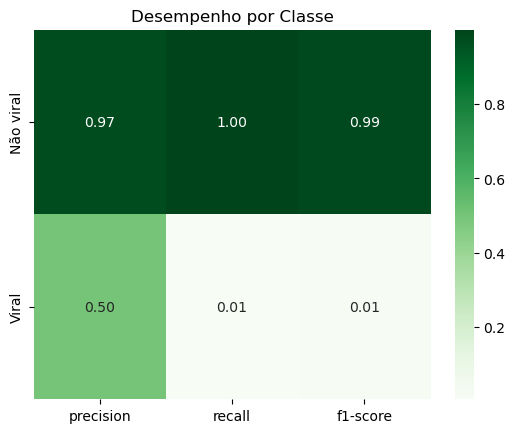


📌 Running Experiment 11/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 50, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=50

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.38      0.01      0.03       448

    accuracy                           0.97     16533
   macro avg       0.67      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



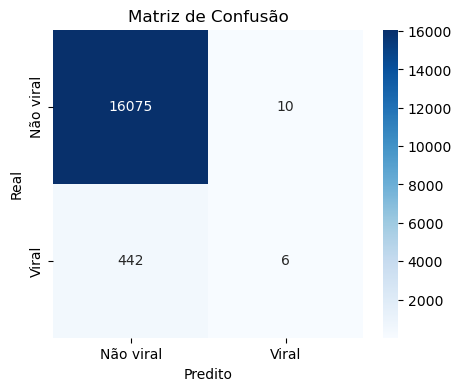

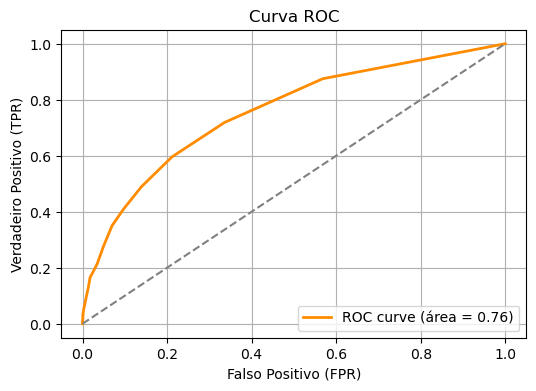

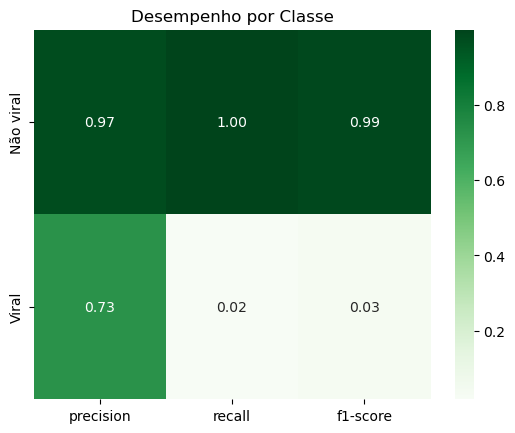


📌 Running Experiment 12/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 200, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=200

📊 Classification Report
              precision    recall  f1-score   support

   Não viral       0.97      1.00      0.99     16085
       Viral       0.53      0.02      0.03       448

    accuracy                           0.97     16533
   macro avg       0.75      0.51      0.51     16533
weighted avg       0.96      0.97      0.96     16533



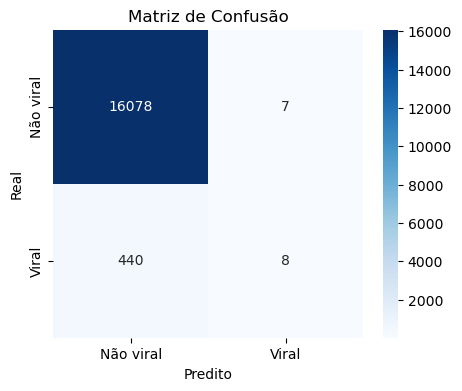

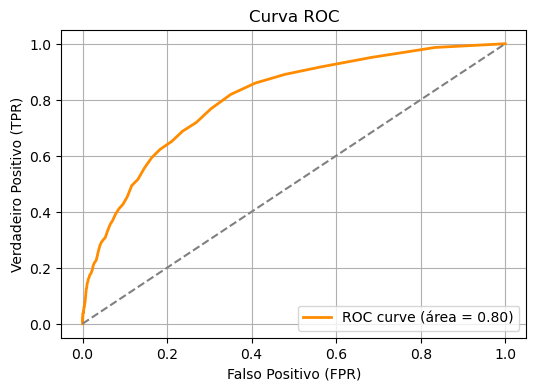

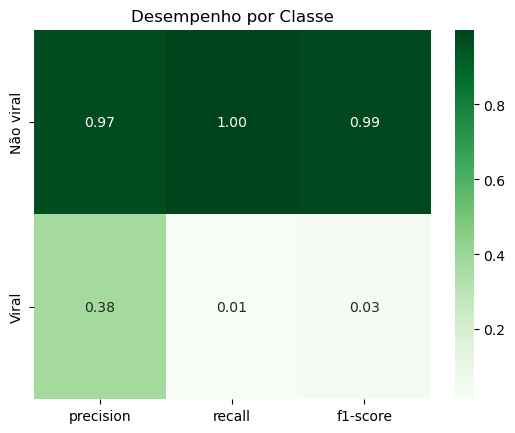

In [106]:
results_ensemble_word2vec = []

for i, config in enumerate(rf_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(rf_experiment_configs)}")
    print(config)

    report_dict = run_random_forest_experiment(
        X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    viral_f1 = report_dict["Viral"]["f1-score"]
    results_ensemble_word2vec.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })